In [1]:
import tables as tb
import numpy as np

from data_io.plot_utils import plot_3d_hits_double
import matplotlib.pyplot  as plt
import matplotlib         as mpl
from mpl_toolkits.mplot3d import Axes3D

from utils.data_utils      import get_event_id, get_mchits_info, histog_to_coord
from utils.histogram_utils import bin_creator, container_creator, mcimg
from utils.labelling_utils import voxel_labelling_MC
from utils.plotting_utils  import plot_3d_histo_hits, plot_3d_histo_vox

from invisible_cities.io import dst_io    as dio
from invisible_cities.io import mcinfo_io as mio

from next_sparseconvnet.data_io_scripts.dataset_labeling_utils import *

In [2]:
total_size = (440, 440, 550) 
voxel_size = (5, 5, 5) #equivalent to step
start_bin = (-220, -220, 0) #equivalent to x0

In [3]:
detector_frame = container_creator(total_size, voxel_size)

detector_bins = bin_creator(detector_frame, steps=voxel_size, x0=start_bin)

In [4]:
cutnum, num = '24', '6206'

In [5]:
dir_beersh = '/Users/mperez/NEXT/bersh_prod/prod_example/Tl208_NEW_v1_03_01_nexus_v5_03_04_cut{cut}.beersheba_{num}.root.h5'.format(cut = cutnum, num = num)

In [6]:
N = 33 #88 #19 #16
nevent = get_event_id(cutnum, N)
nevent

48000057

In [7]:
with tb.open_file(dir_beersh) as h5in:
    print(h5in)

/Users/mperez/NEXT/bersh_prod/prod_example/Tl208_NEW_v1_03_01_nexus_v5_03_04_cut24.beersheba_6206.root.h5 (File) ''
Last modif.: 'Sat Oct  9 12:33:38 2021'
Object Tree: 
/ (RootGroup) ''
/DECO (Group) ''
/DECO/Events (Table(2153387,), shuffle, zlib(4)) 'Deconvolved hits'
/DST (Group) ''
/DST/Events (Table(808,), shuffle, zlib(4)) 'KDST Events'
/MC (Group) ''
/MC/event_mapping (Table(571,), shuffle, zlib(4)) ''
/MC/generators (Table(0,), shuffle, zlib(4)) ''
/MC/hits (Table(143816,), shuffle, zlib(4)) ''
/MC/particles (Table(17519,), shuffle, zlib(4)) ''
/Run (Group) ''
/Run/events (Table(571,), shuffle, zlib(4)) 'event info table'
/Run/runInfo (Table(571,), shuffle, zlib(4)) 'run info table'
/Summary (Group) ''
/Summary/Events (Table(571,), shuffle, zlib(4)) 'Event summary information'



In [8]:
event_summary = dio.load_dst(dir_beersh, 'Summary', 'Events')
event_summary

event  evt_energy  evt_charge  evt_ntrks  evt_nhits   evt_x_avg  \
0    48000024    1.491870        -1.0          1        148   26.364922   
1    48000025    1.715727        -1.0          1        174  -37.792054   
2    48000026    1.459909        -1.0          1        156   26.625296   
3    48000027    1.756891        -1.0          1        176   44.005103   
4    48000028    1.486615        -1.0          1        116  104.059687   
..        ...         ...         ...        ...        ...         ...   
566  48000592    1.596888        -1.0          1        167  -35.248823   
567  48000593         NaN        -1.0          3        134         NaN   
568  48000595    1.604293        -1.0          1        139  122.319002   
569  48000596    1.796688        -1.0          2        192   70.762468   
570  48000597    1.620716        -1.0          1        156   26.682698   

      evt_y_avg   evt_z_avg   evt_r_avg  evt_x_min  evt_y_min   evt_z_min  \
0    155.769793  294.158620  158.280169       -5.0      125.0  279.156281   
1     99.763186  249.354229  108.601155      -65.0       65.0  226.196750   
2    -69.185566  274.214245   74.790404       -5.0     -105.0  260.050906   
3    -22.080207  393.215587   50.246160       15.0      -45.0  379.193719   
4     83.424757  280.849549  134.507965       85.0       55.0  257.039969   
..          ...         ...         ...        ...        ...         ...   
566   70.506928  182.951988   79.321513      -55.0       55.0  140.172766   
567         NaN         NaN         NaN     -145.0       85.0  162.202625   
568   52.125981   36.550079  133.206975       75.0       25.0    6.210953   
569   54.005922  189.297015   92.860320        5.0       35.0  166.121250   
570  -61.819834  334.389212   69.048055        5.0      -95.0  300.060625   

      evt_r_min  evt_x_max  evt_y_max   evt_z_max   evt_r_max  evt_out_of_map  
0    125.896783       45.0      185.0  306.695406  186.681547           False  
1     69.641941       -5.0      135.0  279.634813  142.302495           False  
2     35.355339       55.0      -25.0  281.593000  109.772492           False  
3     21.213203       65.0        5.0  412.616500   73.824115           False  
4    113.357840      135.0      125.0  320.786344  157.003185           False  
..          ...        ...        ...         ...         ...             ...  
566   60.415230      -15.0       95.0  223.614313  101.242284           False  
567  118.532696      -45.0      155.0  231.699062  205.060967            True  
568   87.464278      155.0       85.0   56.043766  172.191754           False  
569   43.011626      135.0      105.0  223.661656  171.026314           False  
570   35.355339       55.0      -15.0  357.686531   98.234414           False  

[571 rows x 18 columns]

In [9]:
event_numbers = event_summary.event.unique() #de acá saco los numeros de event sin repetir y todos

In [10]:
mcpart = dio.load_dst(dir_beersh, 'MC', 'particles') 
mchits = dio.load_dst(dir_beersh, 'MC', 'hits') 

In [11]:
mcpart_event = mcpart.loc[mcpart.event_id == nevent]
mchits_event = mchits.loc[mchits.event_id == nevent]

# Función para asignar labels de la binary classification

In [12]:
def add_binclass(mchits, mcpart):
    '''
    Adds binary class to each hit basing on the existence of an e+ in the event.
    The two classes are 0 - background, 1 - doublescape
    
    Args:
        mchits: DATAFRAME
    Contains the MC hits information of every event in a file.
    
        mcpart: DATAFRAME
    Contains the MC particles information for every event in a file.
    
    RETURNS:
        mchits_binclass: DATAFRAME
    The mchits df with a new column containing the binclass.
    
    '''
    class_label = mcpart.groupby('event_id').particle_name.apply(lambda x:sum(x=='e+')).astype(int)
    class_label.name = 'binclass'

    mchits_binclass  = pd.merge(mchits, class_label, on = 'event_id')
    return mchits_binclass

In [13]:
def add_binclass_test(directory):
    mcpart = dio.load_dst(directory, 'MC', 'particles') 
    mchits = dio.load_dst(directory, 'MC', 'hits') 
    mchits_binclass = add_binclass(mchits, mcpart)
    
    assert np.isin('binclass', mchits_binclass.columns)
    assert len(mchits) == len(mchits_binclass)

In [14]:
add_binclass_test(dir_beersh)

In [15]:
mchits_binclass = add_binclass(mchits, mcpart)

# Función para asignar labels a cada hit para la segmentación

Primero lo que hace es mergear hits y partículas: simplemente a los hits que sean de cierto evento y provengan de cierta partícula les añade la información de la partícula. Es decir, si cierta partícula depositó N hits, cada fila del DataFrame es un hit con la información específica del hit y a mayores todos esos hits tendrán la información de la partícula (igual para todos los hits obviamente)

In [16]:
pd.set_option('display.max_columns', None)
hits_part = pd.merge(mchits, mcpart, on = ['event_id', 'particle_id']) 
hits_part

event_id  particle_id  hit_id          x           y           z  \
0       48000024            8       0  26.949236  181.372101  285.124054   
1       48000024           11       0  -0.177897  166.336060  289.572571   
2       48000024           12       0  -0.213543  166.300186  289.564484   
3       48000024           12       1  -0.229083  166.303101  289.587982   
4       48000024           12       2  -0.221228  166.308075  289.599548   
...          ...          ...     ...        ...         ...         ...   
143811  48000597           20       9  36.669090  -49.727203  304.841309   
143812  48000597           21       0  25.682772  -62.683788  345.306335   
143813  48000597           23       0  26.329964  -63.877815  345.103729   
143814  48000597           24       0  26.328190  -63.877525  345.105164   
143815  48000597           22       0  25.682297  -62.685036  345.305359   

                time    energy   label particle_name  primary  mother_id  \
0       1.495737e+11  0.005104  ACTIVE         gamma    False          5   
1       1.495737e+11  0.004775  ACTIVE         gamma    False          8   
2       1.495737e+11  0.007767  ACTIVE            e-    False         11   
3       1.495737e+11  0.005722  ACTIVE            e-    False         11   
4       1.495737e+11  0.011188  ACTIVE            e-    False         11   
...              ...       ...     ...           ...      ...        ...   
143811  3.043607e+11  0.013409  ACTIVE            e-    False         12   
143812  3.043607e+11  0.000678  ACTIVE         gamma    False         12   
143813  3.043607e+11  0.000989  ACTIVE         gamma    False         21   
143814  3.043607e+11  0.003108  ACTIVE            e-    False         23   
143815  3.043607e+11  0.002433  ACTIVE            e-    False         21   

        initial_x   initial_y   initial_z     initial_t    final_x  \
0       -0.617729  317.260254  272.588837  1.495737e+11  26.949236   
1       26.949236  181.372101  285.124054  1.495737e+11  -0.177897   
2       -0.177897  166.336060  289.572571  1.495737e+11  -0.221228   
3       -0.177897  166.336060  289.572571  1.495737e+11  -0.221228   
4       -0.177897  166.336060  289.572571  1.495737e+11  -0.221228   
...           ...         ...         ...           ...        ...   
143811  36.682758  -50.228470  305.375977  3.043607e+11  36.669090   
143812  25.949812  -62.196259  345.195618  3.043607e+11  25.682772   
143813  25.682772  -62.683788  345.306335  3.043607e+11  26.329964   
143814  26.329964  -63.877815  345.103729  3.043607e+11  26.328190   
143815  25.682772  -62.683788  345.306335  3.043607e+11  25.682297   

           final_y     final_z       final_t initial_volume final_volume  \
0       181.372101  285.124054  1.495737e+11   SCREW_SOURCE       ACTIVE   
1       166.336060  289.572571  1.495737e+11         ACTIVE       ACTIVE   
2       166.308075  289.599548  1.495737e+11         ACTIVE       ACTIVE   
3       166.308075  289.599548  1.495737e+11         ACTIVE       ACTIVE   
4       166.308075  289.599548  1.495737e+11         ACTIVE       ACTIVE   
...            ...         ...           ...            ...          ...   
143811  -49.727203  304.841309  3.043607e+11         ACTIVE       ACTIVE   
143812  -62.683788  345.306335  3.043607e+11         ACTIVE       ACTIVE   
143813  -63.877815  345.103729  3.043607e+11         ACTIVE       ACTIVE   
143814  -63.877525  345.105164  3.043607e+11         ACTIVE       ACTIVE   
143815  -62.685036  345.305359  3.043607e+11         ACTIVE       ACTIVE   

        initial_momentum_x  initial_momentum_y  initial_momentum_z  \
0                -0.427115           -2.252873            1.256093   
1                -0.025499           -0.014133            0.004181   
2                -0.111859           -0.112577           -0.025362   
3                -0.111859           -0.112577           -0.025362   
4                -0.111859           -0.112577           -0.025362   
...     

In [17]:
mcpart

event_id  particle_id    particle_name  primary  mother_id  initial_x  \
0      48000024            1            Tl208     True          0  -0.617729   
1      48000024            4               e-    False          1  -0.617729   
2      48000024            3        anti_nu_e    False          1  -0.617729   
3      48000024            2  Pb208[3197.711]    False          1  -0.617729   
4      48000024            5  Pb208[2614.522]    False          2  -0.617730   
...         ...          ...              ...      ...        ...        ...   
17514  48000597           11               e-    False         10   7.276392   
17515  48000597           21            gamma    False         12  25.949812   
17516  48000597           23            gamma    False         21  25.682772   
17517  48000597           24               e-    False         23  26.329964   
17518  48000597           22               e-    False         21  25.682772   

        initial_y   initial_z     initial_t       final_x      final_y  \
0      317.260254  272.588837  0.000000e+00     -0.617729   317.260254   
1      317.260254  272.588837  1.495737e+11     -0.530838   317.200806   
2      317.260254  272.588837  1.495737e+11  12500.000000  6565.241699   
3      317.260254  272.588837  1.495737e+11     -0.617730   317.260254   
4      317.260254  272.588837  1.495737e+11     -0.617729   317.260254   
...           ...         ...           ...           ...          ...   
17514  287.398499  288.042511  3.043607e+11      7.285720   287.372955   
17515  -62.196259  345.195618  3.043607e+11     25.682772   -62.683788   
17516  -62.683788  345.306335  3.043607e+11     26.329964   -63.877815   
17517  -63.877815  345.103729  3.043607e+11     26.328190   -63.877525   
17518  -62.683788  345.306335  3.043607e+11     25.682297   -62.685036   

           final_z       final_t initial_volume  final_volume  \
0       272.588837  1.495737e+11   SCREW_SOURCE  SCREW_SOURCE   
1       272.572906  1.495737e+11   SCREW_SOURCE  SCREW_SOURCE   
2      6769.386719  1.495737e+11   SCREW_SOURCE         WORLD   
3       272.588837  1.495737e+11   SCREW_SOURCE  SCREW_SOURCE   
4       272.588837  1.495737e+11   SCREW_SOURCE  SCREW_SOURCE   
...            ...           ...            ...           ...   
17514   288.158875  3.043607e+11            ICS           ICS   
17515   345.306335  3.043607e+11         ACTIVE        ACTIVE   
17516   345.103729  3.043607e+11         ACTIVE        ACTIVE   
17517   345.105164  3.043607e+11         ACTIVE        ACTIVE   
17518   345.305359  3.043607e+11         ACTIVE        ACTIVE   

       initial_momentum_x  initial_momentum_y  initial_momentum_z  \
0                0.000000            0.000000            0.000000   
1                0.295509           -0.153660           -0.135797   
2                1.368585            0.684038            0.711279   
3               -1.664095           -0.530378           -0.575482   
4                0.143490            0.236953            0.513200   
...                   ...                 ...                 ...   
17514            0.223354           -0.434871            1.017579   
17515           -0.003396           -0.006200            0.001408   
17516            0.001931           -0.003563           -0.000605   
17517           -0.043506            0.007091            0.035251   
17518           -0.014454           -0.037847           -0.029175   

         kin_energy      creator_proc  final_momentum_x  final_momentum_y  \
0      0.000000e+00              none               NaN               NaN   
1      1.138991e-01  RadioactiveDecay               NaN               NaN   
2      1.687261e+00  RadioactiveDecay               NaN               NaN   
3      8.729607e-06  RadioactiveDecay               NaN               NaN   
4      8.779753e-07  RadioactiveDecay               NaN               NaN   
...             ...               ...               ...               ...   
17514  7

## quiero poner el mother_id_name, y ya si puedo su energía, para ver despues que todos los e- que escojo provienen del fotón energético...

## SI NO CONSIGO POS PASO I GUESS

Quizas es una columna que ya puedo añadir a mcpart por mi propio pie y luego cuando hago hits_part pues es una columna más que se une!!

Sería para un event_id, coger el mother_id y decirle: buscame qué partícula tiene este particle_id dentro del mismo evento y dame su info!!!

## Nada, no lo conseguí, paso creo

# Se consigue usando lo mismo que usé en la función de calcular la distancia, eso es utilizando .shift()

A continuacion juntamos de un mismo evento cada particula. Es casi como la información que tenemos de mcpart, pero al haberla juntado con la info de los hits, hacemos una agrupación de forma que tenemos la energía depositada por la partícula al sumar todos los hits (antes teníamos solo la energía cinética de la partícula, que no se corresponde con la energía depositada) y tb su tiempo minimo y maximo (que en este caso parece que no aporta mucha informacion no?)

Es decir, ahora por cada partícula tenemos info de toda su energía depositada (de forma bastante automática, yo pensaba hacerla más manual) y sus tiempos minimo y máximo

In [55]:
per_part_info = hits_part.groupby(['event_id', 'particle_id', 'particle_name', 'creator_proc']).agg(
        {'energy':[('track_ener', sum)]})
#'time':[('timemin',min), ('timemax',max)], 
#quité lo de time pq no sirve pa nas

In [56]:
per_part_info.columns = per_part_info.columns.get_level_values(1)

In [57]:
#per_part_info['DT']   = per_part_info.timemax-per_part_info.timemin
#de esto paso

In [58]:
per_part_info.reset_index(inplace=True)

Asi tenemos solo las particulas que depositan hits, es decir, un nuevo mcpart solo de las particulas con hit y además con nueva info (y otra info que pasamos de ella). Si quisieramos recuperar esta info habría que añadir columnas en la creación de per_part_info

In [59]:
per_part_info

event_id  particle_id particle_name      creator_proc  track_ener
0     48000024            8         gamma  RadioactiveDecay    0.005104
1     48000024           10            e-              phot    1.025724
2     48000024           11         gamma              phot    0.004775
3     48000024           12            e-              phot    0.024677
4     48000024           18            e-             eIoni    0.145368
...        ...          ...           ...               ...         ...
4933  48000597           20            e-             eIoni    0.106354
4934  48000597           21         gamma             eBrem    0.000678
4935  48000597           22            e-              phot    0.002433
4936  48000597           23         gamma              phot    0.000989
4937  48000597           24            e-              phot    0.003108

[4938 rows x 5 columns]

Eventos double scape:

In [60]:
positron_event_ids = per_part_info[per_part_info.particle_name == 'e+'].event_id.unique()

In [61]:
len(positron_event_ids)

144

Eventos bkg (tomando los event_ids que no son eventos de double scape):

In [62]:
electron_event_ids = np.setdiff1d(per_part_info.event_id.unique(), positron_event_ids)

In [63]:
len(electron_event_ids)

427

Para extraer las trazas principales es sencillo en eventos double scape porque el e+e- vienen del proceso de creacion conv

Comprobamos que del df de informacion por partícula cogemos solo las partículas que:
- Su evento está en la lista de eventos de double scape
- Es un e+ o un e-
- Fue creado por conversión

In [64]:
tracks_pos = per_part_info[(per_part_info.event_id.isin(positron_event_ids)) &\
                               (per_part_info.particle_name.isin(['e+', 'e-']) &\
                            (per_part_info.creator_proc == 'conv'))]

In [65]:
tracks_pos

event_id  particle_id particle_name creator_proc  track_ener
152   48000040           19            e-         conv    0.888315
153   48000040           20            e+         conv    0.474287
181   48000043            9            e-         conv    1.220167
182   48000043           10            e+         conv    0.326145
265   48000053            9            e-         conv    0.983419
...        ...          ...           ...          ...         ...
4852  48000587           20            e+         conv    0.208303
4897  48000592            9            e-         conv    0.808499
4898  48000592           10            e+         conv    0.677987
4914  48000595           13            e-         conv    0.119363
4915  48000595           14            e+         conv    1.251797

[288 rows x 5 columns]

Para las trazas de eventos de bkg hacemos algo similar:
- Cogemos solo partículas que están en la lista de bkg
- Cogemos solo e-
- Cogemos solo procesos creados por compton (esto well supongo q si no? los demas son eIoniz y fotoelectrico)

Entiendo que no consideramos los de efecto fotoelectrico porque son de poca energía? Rollo solo por compton se transfiere suficiente energía como para que un electrón se dé un voltio. De hecho normalmente el foton daba lugar a varios electrones, de los cuales la mayoría ni depositaban hits (tanto los de compton como los de fotoeléctrico). Sólo algunos por efecto compton lo hacían, y unos más que otros (los que más supongo que son los que tomaré como traza ppal)

In [66]:
tracks_el = per_part_info[(per_part_info.event_id.isin(electron_event_ids)) &\
                              (per_part_info.particle_name == 'e-')             &\
                              (per_part_info.creator_proc  == 'compt')]

In [67]:
tracks_el

event_id  particle_id particle_name creator_proc  track_ener
11    48000025            9            e-        compt    1.346115
24    48000026           10            e-        compt    1.269410
29    48000027           13            e-        compt    1.043674
43    48000028           11            e-        compt    1.077448
47    48000028           26            e-        compt    0.121121
...        ...          ...           ...          ...         ...
4889  48000591           11            e-        compt    0.854630
4901  48000593           13            e-        compt    1.140459
4902  48000593           14            e-        compt    0.128091
4921  48000596           13            e-        compt    1.535189
4932  48000597           12            e-        compt    1.498618

[471 rows x 5 columns]

Como de aquí por evento podemos tener más de un electrón que cumpla las características, Marija decidía escoger el que durara más tiempo. El caso es que según lo que veo, todos duran exactamente un tiempo de 0. Sin embargo, se lo escoge bien y no entiendo porqué, ya que no hay realmente información ahí y funciona igual. 

Comentar esto en la reunión. Además decir que yo creo que teniendo en cuenta que esa info no la tenemos, un buen criterio es cogiendo la partícula que en total depositó más energía... esa será la que crea la traza principal digo yo...

In [68]:
tracks_el_perener = tracks_el.loc[tracks_el.groupby('event_id').track_ener.idxmax()] #mi criterio

In [69]:
#tracks_el_pertime = tracks_el.loc[tracks_el.groupby('event_id').DT.idxmax()] #el de marija


Veo que el criterio de Marija y el mio no siempre coinciden.............. A ver donde está el conflicto

In [70]:
#wrong_ev_mask = (np.array(tracks_el_perener.particle_id) == np.array(tracks_el_pertime.particle_id)) == False

#electron_event_ids[wrong_ev_mask] 
#no coinciden porque electron_event_ids tiene eventos que seguramente luego no fueron considerados como 
#poseedores de traza al hacer tracks_el

In [71]:
#tracks_el_perener.loc[wrong_ev_mask]

In [72]:
#tracks_el_pertime.loc[wrong_ev_mask]

In [73]:
#tracks_el.loc[tracks_el.event_id == 48000328]

Veo que con el criterio de marija siempre se escoge la partícula que salió primero por así decirlo en el contaje, o más arriba (aunque aparentemente el criterio sea DT, como ya dije no entiendo que efecto tiene porque es siempre 0...).

Con mi criterio se cumple lo dicho, que cojo la partícula más energética y que supongo que depositó más hits...idk

Veo si la info temporal se perdio desde los ficheros q tengo o algo: parece que desde los penthesileas ya lo del tiempo no furrula bien...

Seguimos... Uso mi criterio:

In [74]:
tracks_el = tracks_el.loc[tracks_el.groupby('event_id').track_ener.idxmax()]

Esto de escoger el más energético está en principio de acuerdo con escoger el más largo (si no, mirar la gráfica de explore_blob_th con track_length vs track_energy)

In [75]:
tracks_info = pd.concat([tracks_el, tracks_pos]).sort_values('event_id')

In [76]:
tracks_info[tracks_info.event_id == 48000179]

event_id  particle_id particle_name creator_proc  track_ener
1375  48000179            9            e-        compt    1.371856

Es curioso que justo el primer evento no aparece, y es que resulta que tiene dos e- que se producen del gamma energético: uno por compton, que sería el que escogemos PERO no nos aparece porque no hay ningún hit de dicha partícula; otro por fotoelectrico, que sí deposita hits pero lo descartamos cuando dijimos de escoger solo compton.

Quizás en la selección de trazas de electrón no debería limitar el proceso creador, eso es algo que no sé la vd... Y luego simplemente escoger con el criterio de energía que ya hago (o el del DT) para quedarnos solo con un electrón...

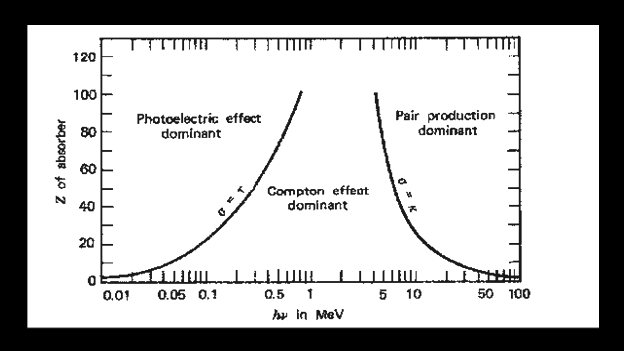

Según lo visto acá arriba, para el Xe que tiene Z = 54 y unos 2 MeV domina compton por lo que el efecto fotoeléctrico no es muy importante y entiendo que no llegará a crear trazas en sí, sino cosas residuales por ahí...

Sí llega a crear pares, una cosa no quita a la otra...

En la tesis de gonzalo martinez dice que el fondo es de eventos compton... rollo hay un pico de double scape sobre eventos compton

In [77]:
label_dict = {'rest':1, 'track':2, 'blob':3}

Asigno a estas tracks la label track!

In [78]:
tracks_info = tracks_info.assign(segclass = label_dict['track'])

In [79]:
tracks_info

event_id  particle_id particle_name creator_proc  track_ener  segclass
11    48000025            9            e-        compt    1.346115         2
24    48000026           10            e-        compt    1.269410         2
29    48000027           13            e-        compt    1.043674         2
43    48000028           11            e-        compt    1.077448         2
59    48000030           10            e-        compt    1.076926         2
...        ...          ...           ...          ...         ...       ...
4901  48000593           13            e-        compt    1.140459         2
4915  48000595           14            e+         conv    1.251797         2
4914  48000595           13            e-         conv    0.119363         2
4921  48000596           13            e-        compt    1.535189         2
4932  48000597           12            e-        compt    1.498618         2

[698 rows x 6 columns]

In [80]:
hits_part

index  event_id  particle_id  hit_id          x           y  \
0            0  48000024            8       0  26.949236  181.372101   
1            1  48000024           11       0  -0.177897  166.336060   
2            2  48000024           12       0  -0.213543  166.300186   
3            3  48000024           12       1  -0.229083  166.303101   
4            4  48000024           12       2  -0.221228  166.308075   
...        ...       ...          ...     ...        ...         ...   
143811  143811  48000597           20       9  36.669090  -49.727203   
143812  143812  48000597           21       0  25.682772  -62.683788   
143813  143813  48000597           23       0  26.329964  -63.877815   
143814  143814  48000597           24       0  26.328190  -63.877525   
143815  143815  48000597           22       0  25.682297  -62.685036   

                 z          time    energy   label particle_name  primary  \
0       285.124054  1.495737e+11  0.005104  ACTIVE         gamma    False   
1       289.572571  1.495737e+11  0.004775  ACTIVE         gamma    False   
2       289.564484  1.495737e+11  0.007767  ACTIVE            e-    False   
3       289.587982  1.495737e+11  0.005722  ACTIVE            e-    False   
4       289.599548  1.495737e+11  0.011188  ACTIVE            e-    False   
...            ...           ...       ...     ...           ...      ...   
143811  304.841309  3.043607e+11  0.013409  ACTIVE            e-    False   
143812  345.306335  3.043607e+11  0.000678  ACTIVE         gamma    False   
143813  345.103729  3.043607e+11  0.000989  ACTIVE         gamma    False   
143814  345.105164  3.043607e+11  0.003108  ACTIVE            e-    False   
143815  345.305359  3.043607e+11  0.002433  ACTIVE            e-    False   

        mother_id  initial_x   initial_y   initial_z     initial_t    final_x  \
0               5  -0.617729  317.260254  272.588837  1.495737e+11  26.949236   
1               8  26.949236  181.372101  285.124054  1.495737e+11  -0.177897   
2              11  -0.177897  166.336060  289.572571  1.495737e+11  -0.221228   
3              11  -0.177897  166.336060  289.572571  1.495737e+11  -0.221228   
4              11  -0.177897  166.336060  289.572571  1.495737e+11  -0.221228   
...           ...        ...         ...         ...           ...        ...   
143811         12  36.682758  -50.228470  305.375977  3.043607e+11  36.669090   
143812         12  25.949812  -62.196259  345.195618  3.043607e+11  25.682772   
143813         21  25.682772  -62.683788  345.306335  3.043607e+11  26.329964   
143814         23  26.329964  -63.877815  345.103729  3.043607e+11  26.328190   
143815         21  25.682772  -62.683788  345.306335  3.043607e+11  25.682297   

           final_y     final_z       final_t initial_volume final_volume  \
0       181.372101  285.124054  1.495737e+11   SCREW_SOURCE       ACTIVE   
1       166.336060  289.572571  1.495737e+11         ACTIVE       ACTIVE   
2       166.308075  289.599548  1.495737e+11         ACTIVE       ACTIVE   
3       166.308075  289.599548  1.495737e+11         ACTIVE       ACTIVE   
4       166.308075  289.599548  1.495737e+11         ACTIVE       ACTIVE   
...            ...         ...           ...            ...          ...   
143811  -49.727203  304.841309  3.043607e+11         ACTIVE       ACTIVE   
143812  -62.683788  345.306335  3.043607e+11         ACTIVE       ACTIVE   
143813  -63.877815  345.103729  3.043607e+11         ACTIVE       ACTIVE   
143814  -63.877525  345.105164  3.043607e+11         ACTIVE       ACTIVE   
143815  -62.685036  345.305359  3.043607e+11         ACTIVE       ACTIVE   

        initial_momentum_x  initial_momentum_y  initial_momentum_z  \
0                -0.427115           -2.252873            1.256093   
1                -0.025499           -0.014133            0.004181   
2                -0.111859           -0.112577           -0.025362   
3                -0.111859           -0.112577       

In [81]:
hits_part = hits_part.reset_index()

In [82]:
hits_part

level_0   index  event_id  particle_id  hit_id          x           y  \
0             0       0  48000024            8       0  26.949236  181.372101   
1             1       1  48000024           11       0  -0.177897  166.336060   
2             2       2  48000024           12       0  -0.213543  166.300186   
3             3       3  48000024           12       1  -0.229083  166.303101   
4             4       4  48000024           12       2  -0.221228  166.308075   
...         ...     ...       ...          ...     ...        ...         ...   
143811   143811  143811  48000597           20       9  36.669090  -49.727203   
143812   143812  143812  48000597           21       0  25.682772  -62.683788   
143813   143813  143813  48000597           23       0  26.329964  -63.877815   
143814   143814  143814  48000597           24       0  26.328190  -63.877525   
143815   143815  143815  48000597           22       0  25.682297  -62.685036   

                 z          time    energy   label particle_name  primary  \
0       285.124054  1.495737e+11  0.005104  ACTIVE         gamma    False   
1       289.572571  1.495737e+11  0.004775  ACTIVE         gamma    False   
2       289.564484  1.495737e+11  0.007767  ACTIVE            e-    False   
3       289.587982  1.495737e+11  0.005722  ACTIVE            e-    False   
4       289.599548  1.495737e+11  0.011188  ACTIVE            e-    False   
...            ...           ...       ...     ...           ...      ...   
143811  304.841309  3.043607e+11  0.013409  ACTIVE            e-    False   
143812  345.306335  3.043607e+11  0.000678  ACTIVE         gamma    False   
143813  345.103729  3.043607e+11  0.000989  ACTIVE         gamma    False   
143814  345.105164  3.043607e+11  0.003108  ACTIVE            e-    False   
143815  345.305359  3.043607e+11  0.002433  ACTIVE            e-    False   

        mother_id  initial_x   initial_y   initial_z     initial_t    final_x  \
0               5  -0.617729  317.260254  272.588837  1.495737e+11  26.949236   
1               8  26.949236  181.372101  285.124054  1.495737e+11  -0.177897   
2              11  -0.177897  166.336060  289.572571  1.495737e+11  -0.221228   
3              11  -0.177897  166.336060  289.572571  1.495737e+11  -0.221228   
4              11  -0.177897  166.336060  289.572571  1.495737e+11  -0.221228   
...           ...        ...         ...         ...           ...        ...   
143811         12  36.682758  -50.228470  305.375977  3.043607e+11  36.669090   
143812         12  25.949812  -62.196259  345.195618  3.043607e+11  25.682772   
143813         21  25.682772  -62.683788  345.306335  3.043607e+11  26.329964   
143814         23  26.329964  -63.877815  345.103729  3.043607e+11  26.328190   
143815         21  25.682772  -62.683788  345.306335  3.043607e+11  25.682297   

           final_y     final_z       final_t initial_volume final_volume  \
0       181.372101  285.124054  1.495737e+11   SCREW_SOURCE       ACTIVE   
1       166.336060  289.572571  1.495737e+11         ACTIVE       ACTIVE   
2       166.308075  289.599548  1.495737e+11         ACTIVE       ACTIVE   
3       166.308075  289.599548  1.495737e+11         ACTIVE       ACTIVE   
4       166.308075  289.599548  1.495737e+11         ACTIVE       ACTIVE   
...            ...         ...           ...            ...          ...   
143811  -49.727203  304.841309  3.043607e+11         ACTIVE       ACTIVE   
143812  -62.683788  345.306335  3.043607e+11         ACTIVE       ACTIVE   
143813  -63.877815  345.103729  3.043607e+11         ACTIVE       ACTIVE   
143814  -63.877525  345.105164  3.043607e+11         ACTIVE       ACTIVE   
143815  -62.685036  345.305359  3.043607e+11         ACTIVE       ACTIVE   

        initial_momentum_x  initial_momentum_y  initial_momentum_z  \
0                -0.427115           -2.252873            1.256093   
1                -0.025499           -0.014133            0.004181   
2             

Añado las partículas traza a la infor total de las hits_part, para luego hacer que todas las otras partículas tengan seglass 'rest'

In [83]:
hits_label = hits_part.merge(tracks_info[['event_id', 'particle_id', 'track_ener', 'segclass']],
how='outer', on=['event_id', 'particle_id'])

El outer quiere decir: mantenme las filas del df principal (hits_part) y llena de NaN los huecos vacíos

A la columna de segclass todos los hits que no son track automaticamente lo hago de clase rest. Los NaN que obtengo de time (que no nos importa su infor supongo) quedan así en principio no?

In [84]:
hits_label.segclass = hits_label.segclass.fillna(label_dict['rest']) 

In [88]:
hits_label

level_0   index  event_id  particle_id  hit_id          x           y  \
0             0       0  48000024            8       0  26.949236  181.372101   
1             1       1  48000024           11       0  -0.177897  166.336060   
2             2       2  48000024           12       0  -0.213543  166.300186   
3             3       3  48000024           12       1  -0.229083  166.303101   
4             4       4  48000024           12       2  -0.221228  166.308075   
...         ...     ...       ...          ...     ...        ...         ...   
143811   143811  143811  48000597           20       9  36.669090  -49.727203   
143812   143812  143812  48000597           21       0  25.682772  -62.683788   
143813   143813  143813  48000597           23       0  26.329964  -63.877815   
143814   143814  143814  48000597           24       0  26.328190  -63.877525   
143815   143815  143815  48000597           22       0  25.682297  -62.685036   

                 z          time    energy   label particle_name  primary  \
0       285.124054  1.495737e+11  0.005104  ACTIVE         gamma    False   
1       289.572571  1.495737e+11  0.004775  ACTIVE         gamma    False   
2       289.564484  1.495737e+11  0.007767  ACTIVE            e-    False   
3       289.587982  1.495737e+11  0.005722  ACTIVE            e-    False   
4       289.599548  1.495737e+11  0.011188  ACTIVE            e-    False   
...            ...           ...       ...     ...           ...      ...   
143811  304.841309  3.043607e+11  0.013409  ACTIVE            e-    False   
143812  345.306335  3.043607e+11  0.000678  ACTIVE         gamma    False   
143813  345.103729  3.043607e+11  0.000989  ACTIVE         gamma    False   
143814  345.105164  3.043607e+11  0.003108  ACTIVE            e-    False   
143815  345.305359  3.043607e+11  0.002433  ACTIVE            e-    False   

        mother_id  initial_x   initial_y   initial_z     initial_t    final_x  \
0               5  -0.617729  317.260254  272.588837  1.495737e+11  26.949236   
1               8  26.949236  181.372101  285.124054  1.495737e+11  -0.177897   
2              11  -0.177897  166.336060  289.572571  1.495737e+11  -0.221228   
3              11  -0.177897  166.336060  289.572571  1.495737e+11  -0.221228   
4              11  -0.177897  166.336060  289.572571  1.495737e+11  -0.221228   
...           ...        ...         ...         ...           ...        ...   
143811         12  36.682758  -50.228470  305.375977  3.043607e+11  36.669090   
143812         12  25.949812  -62.196259  345.195618  3.043607e+11  25.682772   
143813         21  25.682772  -62.683788  345.306335  3.043607e+11  26.329964   
143814         23  26.329964  -63.877815  345.103729  3.043607e+11  26.328190   
143815         21  25.682772  -62.683788  345.306335  3.043607e+11  25.682297   

           final_y     final_z       final_t initial_volume final_volume  \
0       181.372101  285.124054  1.495737e+11   SCREW_SOURCE       ACTIVE   
1       166.336060  289.572571  1.495737e+11         ACTIVE       ACTIVE   
2       166.308075  289.599548  1.495737e+11         ACTIVE       ACTIVE   
3       166.308075  289.599548  1.495737e+11         ACTIVE       ACTIVE   
4       166.308075  289.599548  1.495737e+11         ACTIVE       ACTIVE   
...            ...         ...           ...            ...          ...   
143811  -49.727203  304.841309  3.043607e+11         ACTIVE       ACTIVE   
143812  -62.683788  345.306335  3.043607e+11         ACTIVE       ACTIVE   
143813  -63.877815  345.103729  3.043607e+11         ACTIVE       ACTIVE   
143814  -63.877525  345.105164  3.043607e+11         ACTIVE       ACTIVE   
143815  -62.685036  345.305359  3.043607e+11         ACTIVE       ACTIVE   

        initial_momentum_x  initial_momentum_y  initial_momentum_z  \
0                -0.427115           -2.252873            1.256093   
1                -0.025499           -0.014133            0.004181   
2             

Ahora hacemos una suma acumulativa de los hits etiquetados como trazas, empezando desde el último hit

Luego el estudio q haré del pico de bragg será decidir cual es el corte en energía estudiando el pico en la distancia recorrida de hit...

Primero se ordenan los hits por evento, particle, y hit_id pero al revés

In [89]:
hits_label = hits_label.sort_values(['event_id', 'particle_id', 'hit_id'], ascending=[True, True, False])

Le incluimos una nueva columna con cumenergy de cada hit!! Tenemos que agrupar por evento y particula, y aplicamos a la columna energy la función cumsum(), y lo almacenamos en la columna

In [90]:
hits_label = hits_label.assign(cumenergy = hits_label.groupby(['event_id', 'particle_id']).energy.cumsum())

In [91]:
hits_label

level_0   index  event_id  particle_id  hit_id          x           y  \
0             0       0  48000024            8       0  26.949236  181.372101   
175         175     175  48000024           10     170  28.933611  155.286072   
174         174     174  48000024           10     169  28.933075  155.284714   
173         173     173  48000024           10     168  28.914318  155.271744   
172         172     172  48000024           10     167  28.878639  155.215439   
...         ...     ...       ...          ...     ...        ...         ...   
143802   143802  143802  48000597           20       0  36.252510  -50.282032   
143812   143812  143812  48000597           21       0  25.682772  -62.683788   
143815   143815  143815  48000597           22       0  25.682297  -62.685036   
143813   143813  143813  48000597           23       0  26.329964  -63.877815   
143814   143814  143814  48000597           24       0  26.328190  -63.877525   

                 z          time    energy   label particle_name  primary  \
0       285.124054  1.495737e+11  0.005104  ACTIVE         gamma    False   
175     300.268463  1.495737e+11  0.008812  ACTIVE            e-    False   
174     300.278625  1.495737e+11  0.008001  ACTIVE            e-    False   
173     300.295013  1.495737e+11  0.012594  ACTIVE            e-    False   
172     300.306458  1.495737e+11  0.017115  ACTIVE            e-    False   
...            ...           ...       ...     ...           ...      ...   
143802  305.196533  3.043607e+11  0.009767  ACTIVE            e-    False   
143812  345.306335  3.043607e+11  0.000678  ACTIVE         gamma    False   
143815  345.305359  3.043607e+11  0.002433  ACTIVE            e-    False   
143813  345.103729  3.043607e+11  0.000989  ACTIVE         gamma    False   
143814  345.105164  3.043607e+11  0.003108  ACTIVE            e-    False   

        mother_id  initial_x   initial_y   initial_z     initial_t    final_x  \
0               5  -0.617729  317.260254  272.588837  1.495737e+11  26.949236   
175             8  26.949236  181.372101  285.124054  1.495737e+11  28.933611   
174             8  26.949236  181.372101  285.124054  1.495737e+11  28.933611   
173             8  26.949236  181.372101  285.124054  1.495737e+11  28.933611   
172             8  26.949236  181.372101  285.124054  1.495737e+11  28.933611   
...           ...        ...         ...         ...           ...        ...   
143802         12  36.682758  -50.228470  305.375977  3.043607e+11  36.669090   
143812         12  25.949812  -62.196259  345.195618  3.043607e+11  25.682772   
143815         21  25.682772  -62.683788  345.306335  3.043607e+11  25.682297   
143813         21  25.682772  -62.683788  345.306335  3.043607e+11  26.329964   
143814         23  26.329964  -63.877815  345.103729  3.043607e+11  26.328190   

           final_y     final_z       final_t initial_volume final_volume  \
0       181.372101  285.124054  1.495737e+11   SCREW_SOURCE       ACTIVE   
175     155.286072  300.268463  1.495737e+11         ACTIVE       ACTIVE   
174     155.286072  300.268463  1.495737e+11         ACTIVE       ACTIVE   
173     155.286072  300.268463  1.495737e+11         ACTIVE       ACTIVE   
172     155.286072  300.268463  1.495737e+11         ACTIVE       ACTIVE   
...            ...         ...           ...            ...          ...   
143802  -49.727203  304.841309  3.043607e+11         ACTIVE       ACTIVE   
143812  -62.683788  345.306335  3.043607e+11         ACTIVE       ACTIVE   
143815  -62.685036  345.305359  3.043607e+11         ACTIVE       ACTIVE   
143813  -63.877815  345.103729  3.043607e+11         ACTIVE       ACTIVE   
143814  -63.877525  345.105164  3.043607e+11         ACTIVE       ACTIVE   

        initial_momentum_x  initial_momentum_y  initial_momentum_z  \
0                -0.427115           -2.252873            1.256093   
175              -0.295611           -1.364650            1.247818   
174           

In [98]:
max((hits_label.cumenergy / hits_label.track_ener).fillna(0))

1.0

Ahora hace 2 cosas, según tengas un threshold temporal o en energía. Como yo solo tengo en energía en ppio (lo sacaré del análisis q haré luego) pues paso del temporal en ppio...

No solo haré análisis del pico de bragg según la energía, si no que también miraré lo bien que coinciden las trazas largas con las más energéticas, no vaya a ser que haya algún tipo de desacuerdo en eso (puede ser que esté escogiendo los electrones más energéticos, pero que no tengan trazas tochas ni nada!!). Esto lo hago además después de escoger en compton, que es otra cosa que no sé si tengo muy clara (rollo pq no valen electrones de fotoeléctrico que sí tengan traza, sobre todo cuando no hay ninguno de compton?)

In [101]:
delta_e = 0.4

In [102]:
blob_mask = (hits_label.cumenergy<delta_e)

Entonces finalmente pilla todos los hits que tengan menos energía que delta_e y que además estén etiquetados como track (es decir, va a coger una serie de últimos hits) y los etiqueta como blob!!

In [103]:
hits_label.loc[(hits_label.segclass==label_dict['track'])& blob_mask, 'segclass'] = label_dict['blob']

Finalmente añadiremos la distancia de los hits de traza!!

In [104]:
hits_label = hits_label.loc[hits_label.label == 'ACTIVE']  #hago esta cosa ya sabemos pq

hits_label = hits_label.sort_values(['event_id', 'particle_id', 'hit_id'], ascending=[True, True, True])
    

Tomando tracks_info, hago un df con la información de los hits de las tracks solo, que incluya el hit_id, las coordenadas y la energía

In [105]:
hits_tracks = tracks_info[['event_id', 
                           'particle_id',
                           'creator_proc']].merge(hits_label[['event_id', 
                                                            'particle_id', 
                                                            'hit_id', 
                                                            'x', 'y', 'z', 
                                                            'energy']], 
                                                             on = ['event_id', 'particle_id'])

In [106]:
hits_tracks

event_id  particle_id creator_proc  hit_id          x           y  \
0       48000025            9        compt       0 -10.232615  130.326630   
1       48000025            9        compt       1 -10.180497  129.346741   
2       48000025            9        compt       2 -10.200663  128.350739   
3       48000025            9        compt       3 -10.146321  127.383324   
4       48000025            9        compt       4 -10.149337  126.408508   
...          ...          ...          ...     ...        ...         ...   
117827  48000597           12        compt     252  17.727882  -86.270172   
117828  48000597           12        compt     253  17.686977  -86.212891   
117829  48000597           12        compt     254  17.642962  -86.215347   
117830  48000597           12        compt     255  17.653267  -86.242455   
117831  48000597           12        compt     256  17.651085  -86.239822   

                 z    energy  
0       277.471436  0.004958  
1       277.648651  0.007001  
2       277.692017  0.003255  
3       277.457123  0.003337  
4       277.250122  0.008451  
...            ...       ...  
117827  354.765961  0.021267  
117828  354.812683  0.008560  
117829  354.782166  0.007195  
117830  354.794708  0.012554  
117831  354.790619  0.005646  

[117832 rows x 8 columns]

Cojo para cada hit la información de la posición del siguiente hit, salvo para los hits con id 0 (ya que son el primer hit)

In [107]:
hits_tracks[['x1', 'y1', 'z1']] = hits_tracks[['x', 'y', 'z']].shift(1)

In [108]:
hits_tracks

event_id  particle_id creator_proc  hit_id          x           y  \
0       48000025            9        compt       0 -10.232615  130.326630   
1       48000025            9        compt       1 -10.180497  129.346741   
2       48000025            9        compt       2 -10.200663  128.350739   
3       48000025            9        compt       3 -10.146321  127.383324   
4       48000025            9        compt       4 -10.149337  126.408508   
...          ...          ...          ...     ...        ...         ...   
117827  48000597           12        compt     252  17.727882  -86.270172   
117828  48000597           12        compt     253  17.686977  -86.212891   
117829  48000597           12        compt     254  17.642962  -86.215347   
117830  48000597           12        compt     255  17.653267  -86.242455   
117831  48000597           12        compt     256  17.651085  -86.239822   

                 z    energy         x1          y1          z1  
0       277.471436  0.004958        NaN         NaN         NaN  
1       277.648651  0.007001 -10.232615  130.326630  277.471436  
2       277.692017  0.003255 -10.180497  129.346741  277.648651  
3       277.457123  0.003337 -10.200663  128.350739  277.692017  
4       277.250122  0.008451 -10.146321  127.383324  277.457123  
...            ...       ...        ...         ...         ...  
117827  354.765961  0.021267  17.648399  -86.183128  354.631317  
117828  354.812683  0.008560  17.727882  -86.270172  354.765961  
117829  354.782166  0.007195  17.686977  -86.212891  354.812683  
117830  354.794708  0.012554  17.642962  -86.215347  354.782166  
117831  354.790619  0.005646  17.653267  -86.242455  354.794708  

[117832 rows x 11 columns]

Calculo la distancia entre hits

In [109]:
hits_tracks['dist_hits'] = np.linalg.norm(
    hits_tracks[['x', 'y', 'z']].values 
    - hits_tracks[['x1', 'y1', 'z1']].values, axis=1)

In [110]:
hits_tracks.loc[hits_tracks.hit_id == 0, 'dist_hits'] = 0

In [111]:
hits_tracks[hits_tracks.event_id == 48000034]

event_id  particle_id creator_proc  hit_id          x           y  \
1617  48000034            9        compt       0 -41.011421  100.788895   
1618  48000034            9        compt       1 -41.250267   99.985077   
1619  48000034            9        compt       2 -41.459465   99.245285   
1620  48000034            9        compt       3 -41.774479   98.479614   
1621  48000034            9        compt       4 -41.978638   97.657700   
...        ...          ...          ...     ...        ...         ...   
1873  48000034            9        compt     256 -15.456436   97.921890   
1874  48000034            9        compt     257 -15.464881   97.878143   
1875  48000034            9        compt     258 -15.460279   97.892761   
1876  48000034            9        compt     259 -15.455297   97.905548   
1877  48000034            9        compt     260 -15.454938   97.904961   

               z    energy         x1          y1          z1  dist_hits  
1617  316.243225  0.001263 -78.836441  148.243454  425.447815   0.000000  
1618  316.781067  0.005221 -41.011421  100.788895  316.243225   0.996215  
1619  317.414917  0.003759 -41.250267   99.985077  316.781067   0.996404  
1620  317.961700  0.005349 -41.459465   99.245285  317.414917   0.992198  
1621  318.481842  0.004740 -41.774479   98.479614  317.961700   0.993867  
...          ...       ...        ...         ...         ...        ...  
1873  266.828033  0.010196 -15.534897   97.921227  266.775391   0.094487  
1874  266.792480  0.006948 -15.456436   97.921890  266.828033   0.057001  
1875  266.823761  0.008402 -15.464881   97.878143  266.792480   0.034833  
1876  266.818970  0.009827 -15.460279   97.892761  266.823761   0.014535  
1877  266.818970  0.001212 -15.455297   97.905548  266.818970   0.000689  

[261 rows x 12 columns]

In [112]:
hits_tracks = hits_tracks.assign(cumdist = hits_tracks.groupby(['event_id', 'particle_id']).dist_hits.cumsum())

In [113]:
hits_tracks

event_id  particle_id creator_proc  hit_id          x           y  \
0       48000025            9        compt       0 -10.232615  130.326630   
1       48000025            9        compt       1 -10.180497  129.346741   
2       48000025            9        compt       2 -10.200663  128.350739   
3       48000025            9        compt       3 -10.146321  127.383324   
4       48000025            9        compt       4 -10.149337  126.408508   
...          ...          ...          ...     ...        ...         ...   
117827  48000597           12        compt     252  17.727882  -86.270172   
117828  48000597           12        compt     253  17.686977  -86.212891   
117829  48000597           12        compt     254  17.642962  -86.215347   
117830  48000597           12        compt     255  17.653267  -86.242455   
117831  48000597           12        compt     256  17.651085  -86.239822   

                 z    energy         x1          y1          z1  dist_hits  \
0       277.471436  0.004958        NaN         NaN         NaN   0.000000   
1       277.648651  0.007001 -10.232615  130.326630  277.471436   0.997148   
2       277.692017  0.003255 -10.180497  129.346741  277.648651   0.997150   
3       277.457123  0.003337 -10.200663  128.350739  277.692017   0.997005   
4       277.250122  0.008451 -10.146321  127.383324  277.457123   0.996556   
...            ...       ...        ...         ...         ...        ...   
117827  354.765961  0.021267  17.648399  -86.183128  354.631317   0.178950   
117828  354.812683  0.008560  17.727882  -86.270172  354.765961   0.084483   
117829  354.782166  0.007195  17.686977  -86.212891  354.812683   0.053617   
117830  354.794708  0.012554  17.642962  -86.215347  354.782166   0.031596   
117831  354.790619  0.005646  17.653267  -86.242455  354.794708   0.005330   

           cumdist  
0         0.000000  
1         0.997148  
2         1.994298  
3         2.991303  
4         3.987859  
...            ...  
117827  231.638031  
117828  231.722504  
117829  231.776123  
117830  231.807724  
117831  231.813049  

[117832 rows x 13 columns]

In [114]:
hits_label_dist = hits_label.merge(hits_tracks[['event_id', 'particle_id', 'hit_id', 'dist_hits', 'cumdist']],
                                   how = 'outer',
                                  on = ['event_id', 'particle_id', 'hit_id'])

In [115]:
hits_label_dist.dist_hits = hits_label_dist.dist_hits.fillna(0)
hits_label_dist.cumdist = hits_label_dist.cumdist.fillna(0)


In [116]:
hits_label_dist = hits_label_dist[['event_id', 'x', 'y', 'z', 
                                   'energy', 'segclass', 'cumenergy', 
                                   'dist_hits', 'cumdist']].reset_index(drop=True)

In [117]:
hits_label_dist

event_id          x           y           z    energy  segclass  \
0       48000024  26.949236  181.372101  285.124054  0.005104       1.0   
1       48000024  26.678534  180.700729  285.803558  0.003391       1.0   
2       48000024  26.359673  180.022491  286.443512  0.004142       1.0   
3       48000024  25.943626  179.287827  286.973358  0.006741       1.0   
4       48000024  25.443466  178.509872  287.325806  0.004898       1.0   
...          ...        ...         ...         ...       ...       ...   
143261  48000597  36.669090  -49.727203  304.841309  0.013409       1.0   
143262  48000597  25.682772  -62.683788  345.306335  0.000678       1.0   
143263  48000597  25.682297  -62.685036  345.305359  0.002433       1.0   
143264  48000597  26.329964  -63.877815  345.103729  0.000989       1.0   
143265  48000597  26.328190  -63.877525  345.105164  0.003108       1.0   

        cumenergy  dist_hits  cumdist  
0        0.005104        0.0      0.0  
1        1.025724        0.0      0.0  
2        1.022333        0.0      0.0  
3        1.018191        0.0      0.0  
4        1.011450        0.0      0.0  
...           ...        ...      ...  
143261   0.013409        0.0      0.0  
143262   0.000678        0.0      0.0  
143263   0.002433        0.0      0.0  
143264   0.000989        0.0      0.0  
143265   0.003108        0.0      0.0  

[143266 rows x 9 columns]

In [118]:
def calculate_track_distances(tracks_info, hits_label):
    '''
    Function to use inside the add_segclass function (because it has the tracks info),
    after being already assigned the seglabels. If we wanted to do this before those are asigned, 
    our output would be named hits_part inside the add_segclass function.
    
    Args:
        tracks_info: DATAFRAME
    Contains the particle information (ids, name, creator process, all its energy...). It is
    a dataframe created in the add_segclass function.
        
        hits_label: DATAFRAME
    Contains the hits information (ids, name, energy, segclass...). It is the final step inside the
    add_segclass function (the argument takes the last hits_label in the function). It can be just hits_part,
    but in our case we will use it with more information.
        
    RETURNS:
        hits_dist: DATAFRAME
    Same dataframe as hits_label with a new column: the hits distances for the track hits.
    
    '''
    #Delete hits with BUFFER label (otherwise some hits are duplicated)
    hits_label = hits_label.loc[hits_label.label == 'ACTIVE'] 
    
    #Reordes hits with ascendent ID
    hits_label = hits_label.sort_values(['event_id', 'particle_id', 'hit_id'], ascending=[True, True, True])
    
    #Stick the hits_label info to the tracks info to have the hits of the tracks (doesn't have to be hits_label,
    #can be mchits but in the end we will add to the DF the distances data, so we want the DF with the segclass
    #already, as it is used at the end of the add_segclass function)
    hits_tracks = tracks_info[['event_id', 
                               'particle_id',
                               'creator_proc']].merge(hits_label[['event_id', 
                                                                'particle_id', 
                                                                'hit_id', 
                                                                'x', 'y', 'z', 
                                                                'energy']], 
                                                                 on = ['event_id', 'particle_id'])
    
    #Add next row coordinates to new columns to compare, without the first hits
    hits_tracks[['x1', 'y1', 'z1']] = hits_tracks[['x', 'y', 'z']].shift(1)
    
    #Compute the distance for each hit with the previous one, except from the first hits
    hits_tracks['dist_hits'] = np.linalg.norm(
                                                hits_tracks[['x', 'y', 'z']].values 
                                                - hits_tracks[['x1', 'y1', 'z1']].values, axis=1)

    #The first hits distances are set to 0 as we don't want to be compared with other events
    hits_tracks.loc[hits_tracks.hit_id == 0, 'dist_hits'] = 0

    #We compute the cumulative sum    
    hits_tracks = hits_tracks.assign(cumdist = hits_tracks.groupby(['event_id', 'particle_id']).dist_hits.cumsum())
    
    #Merge the particle info with the new distance info for the hits in the tracks
    hits_dist = hits_label.merge(hits_tracks[['event_id', 'particle_id', 'hit_id', 'dist_hits', 'cumdist']],
                                   how = 'outer',
                                  on = ['event_id', 'particle_id', 'hit_id'])
    hits_dist.dist_hits = hits_dist.dist_hits.fillna(0)
    hits_dist.cumdist   = hits_dist.cumdist.fillna(0)
    return hits_dist

In [119]:
hits_tracks

event_id  particle_id creator_proc  hit_id          x           y  \
0       48000025            9        compt       0 -10.232615  130.326630   
1       48000025            9        compt       1 -10.180497  129.346741   
2       48000025            9        compt       2 -10.200663  128.350739   
3       48000025            9        compt       3 -10.146321  127.383324   
4       48000025            9        compt       4 -10.149337  126.408508   
...          ...          ...          ...     ...        ...         ...   
117827  48000597           12        compt     252  17.727882  -86.270172   
117828  48000597           12        compt     253  17.686977  -86.212891   
117829  48000597           12        compt     254  17.642962  -86.215347   
117830  48000597           12        compt     255  17.653267  -86.242455   
117831  48000597           12        compt     256  17.651085  -86.239822   

                 z    energy         x1          y1          z1  dist_hits  \
0       277.471436  0.004958        NaN         NaN         NaN   0.000000   
1       277.648651  0.007001 -10.232615  130.326630  277.471436   0.997148   
2       277.692017  0.003255 -10.180497  129.346741  277.648651   0.997150   
3       277.457123  0.003337 -10.200663  128.350739  277.692017   0.997005   
4       277.250122  0.008451 -10.146321  127.383324  277.457123   0.996556   
...            ...       ...        ...         ...         ...        ...   
117827  354.765961  0.021267  17.648399  -86.183128  354.631317   0.178950   
117828  354.812683  0.008560  17.727882  -86.270172  354.765961   0.084483   
117829  354.782166  0.007195  17.686977  -86.212891  354.812683   0.053617   
117830  354.794708  0.012554  17.642962  -86.215347  354.782166   0.031596   
117831  354.790619  0.005646  17.653267  -86.242455  354.794708   0.005330   

           cumdist  
0         0.000000  
1         0.997148  
2         1.994298  
3         2.991303  
4         3.987859  
...            ...  
117827  231.638031  
117828  231.722504  
117829  231.776123  
117830  231.807724  
117831  231.813049  

[117832 rows x 13 columns]

In [120]:
prueba = calculate_track_distances(tracks_info, hits_label)

In [122]:
prueba

level_0   index  event_id  particle_id  hit_id          x           y  \
0             0       0  48000024            8       0  26.949236  181.372101   
1             5       5  48000024           10       0  26.678534  180.700729   
2             6       6  48000024           10       1  26.359673  180.022491   
3             7       7  48000024           10       2  25.943626  179.287827   
4             8       8  48000024           10       3  25.443466  178.509872   
...         ...     ...       ...          ...     ...        ...         ...   
143261   143811  143811  48000597           20       9  36.669090  -49.727203   
143262   143812  143812  48000597           21       0  25.682772  -62.683788   
143263   143815  143815  48000597           22       0  25.682297  -62.685036   
143264   143813  143813  48000597           23       0  26.329964  -63.877815   
143265   143814  143814  48000597           24       0  26.328190  -63.877525   

                 z          time    energy   label particle_name  primary  \
0       285.124054  1.495737e+11  0.005104  ACTIVE         gamma    False   
1       285.803558  1.495737e+11  0.003391  ACTIVE            e-    False   
2       286.443512  1.495737e+11  0.004142  ACTIVE            e-    False   
3       286.973358  1.495737e+11  0.006741  ACTIVE            e-    False   
4       287.325806  1.495737e+11  0.004898  ACTIVE            e-    False   
...            ...           ...       ...     ...           ...      ...   
143261  304.841309  3.043607e+11  0.013409  ACTIVE            e-    False   
143262  345.306335  3.043607e+11  0.000678  ACTIVE         gamma    False   
143263  345.305359  3.043607e+11  0.002433  ACTIVE            e-    False   
143264  345.103729  3.043607e+11  0.000989  ACTIVE         gamma    False   
143265  345.105164  3.043607e+11  0.003108  ACTIVE            e-    False   

        mother_id  initial_x   initial_y   initial_z     initial_t    final_x  \
0               5  -0.617729  317.260254  272.588837  1.495737e+11  26.949236   
1               8  26.949236  181.372101  285.124054  1.495737e+11  28.933611   
2               8  26.949236  181.372101  285.124054  1.495737e+11  28.933611   
3               8  26.949236  181.372101  285.124054  1.495737e+11  28.933611   
4               8  26.949236  181.372101  285.124054  1.495737e+11  28.933611   
...           ...        ...         ...         ...           ...        ...   
143261         12  36.682758  -50.228470  305.375977  3.043607e+11  36.669090   
143262         12  25.949812  -62.196259  345.195618  3.043607e+11  25.682772   
143263         21  25.682772  -62.683788  345.306335  3.043607e+11  25.682297   
143264         21  25.682772  -62.683788  345.306335  3.043607e+11  26.329964   
143265         23  26.329964  -63.877815  345.103729  3.043607e+11  26.328190   

           final_y     final_z       final_t initial_volume final_volume  \
0       181.372101  285.124054  1.495737e+11   SCREW_SOURCE       ACTIVE   
1       155.286072  300.268463  1.495737e+11         ACTIVE       ACTIVE   
2       155.286072  300.268463  1.495737e+11         ACTIVE       ACTIVE   
3       155.286072  300.268463  1.495737e+11         ACTIVE       ACTIVE   
4       155.286072  300.268463  1.495737e+11         ACTIVE       ACTIVE   
...            ...         ...           ...            ...          ...   
143261  -49.727203  304.841309  3.043607e+11         ACTIVE       ACTIVE   
143262  -62.683788  345.306335  3.043607e+11         ACTIVE       ACTIVE   
143263  -62.685036  345.305359  3.043607e+11         ACTIVE       ACTIVE   
143264  -63.877815  345.103729  3.043607e+11         ACTIVE       ACTIVE   
143265  -63.877525  345.105164  3.043607e+11         ACTIVE       ACTIVE   

        initial_momentum_x  initial_momentum_y  initial_momentum_z  \
0                -0.427115           -2.252873            1.256093   
1                -0.295611           -1.364650            1.247818   
2             

In [101]:
def get_tracks_info(hits_part):
    pass

Quizas estaría bien quitar de segclass toda la parte de obtener la información de las trazas, nose

In [128]:
def add_segclass(mchits, mcpart, delta_loss = None, delta_e = None, label_dict={'rest':1, 'track':2, 'blob':3}): 
    '''
    Add segmentation class to each hit in the file, after being filled with the binclass.
    The classes are 1 - rest, 2 - track, 3 - blob
    It also computes the distance between the hits of the tracks (we take advantage of the tracks info 
    extraction being done here to perform this calculation)
    
    Args:
        mchits: DATAFRAME
    Contains the hits information plus the binclass. It is the output of the add_binclass() function.
    
        mcpart: DATAFRAME
    Contains the particle information.
    
        delta_loss: FLOAT
    Energy loss threshold in percentage (respect to the total track energy) for the last hits of a 
    track to become blob class.
    
        delta_e: FLOAT
    Energy threshold for the last hits of a track to become blob class.
    
        label_dict: DICTIONARY
    Has the correspondence for the class names.
    
    RETURN:
        hits_label: DATAFRAME
    Contains the hits information with event_id, coordinates, energy, segclass, binclass
    and hits distances of the tracks (also creator and particle to get the traces and do the bragg peak study)
    
    '''
    #Unimos los df de hits y particulas, haciendo que a cada hit de mchits se le añada la información 
    #de la partícula que viene en mcpart
    hits_part = pd.merge(mchits, mcpart, on = ['event_id', 'particle_id']) 
    
    #Agrupamos todos los hits de cada partícula de cada evento y sumamos su energía para obtener la
    #energía depositada por cada partícula (más otra información)
    per_part_info = hits_part.groupby(['event_id', 
                                       'particle_id', 
                                       'particle_name', 
                                       'creator_proc']).agg({'energy':[('track_ener', sum)]})
    per_part_info.columns = per_part_info.columns.get_level_values(1)
    per_part_info.reset_index(inplace=True)
    
    #Seleccionamos los eventos de double scape y background
    doublescape_event_ids = per_part_info[per_part_info.particle_name == 'e+'].event_id.unique()
    background_event_ids  = np.setdiff1d(per_part_info.event_id.unique(), doublescape_event_ids)
    
    #Seleccionamos las trazas de cada evento
    #Para double scape es sencillo, cogemos los e+e- cuyo proceso de creación sea conv, tendremos 2 trazas/evento
    tracks_dsc = per_part_info[(per_part_info.event_id.isin(doublescape_event_ids)) &\
                                   (per_part_info.particle_name.isin(['e+', 'e-']) &\
                                   (per_part_info.creator_proc == 'conv'))]
    
    #Para background cogemos los electrones que fueron creados por compton, y de ellos escogemos el más energético
    #Tendremos 1 traza/evento
    tracks_bkg = per_part_info[(per_part_info.event_id.isin(background_event_ids)) &\
                                   (per_part_info.particle_name == 'e-') &\
                                   (per_part_info.creator_proc  == 'compt')]
    
    tracks_bkg = tracks_bkg.loc[tracks_bkg.groupby('event_id').track_ener.idxmax()] #seleccionamos el más energético
    
    #Unimos la información de todas las trazas y le añadimos la etiqueta track en una nueva columna segclass
    tracks_info = pd.concat([tracks_bkg, tracks_dsc]).sort_values('event_id')
    tracks_info = tracks_info.assign(segclass = label_dict['track'])
    
    #Añadimos al df de información de hits y partículas la nueva columna de etiquetas de voxel
    hits_part  = hits_part.reset_index()
    hits_label = hits_part.merge(tracks_info[['event_id', 'particle_id', 'track_ener', 'segclass']], 
                                 how='outer', on=['event_id', 'particle_id'])
    
    #Todas las partículas que ahora en segclass no tienen valor se les adjudica la etiqueta rest
    hits_label.segclass = hits_label.segclass.fillna(label_dict['rest']) 
    
    #Ordeno los hits en orden descendente y hago suma cumulativa de energías de hit en una columna, cumenergy
    hits_label = hits_label.sort_values(['event_id', 'particle_id', 'hit_id'], ascending=[True, True, False])
    hits_label = hits_label.assign(cumenergy = hits_label.groupby(['event_id', 'particle_id']).energy.cumsum())
    
    #Creo la columna de porcentaje de energía perdida
    hits_label = hits_label.assign(lost_ener = (hits_label.cumenergy / hits_label.track_ener).fillna(0))
    
    if delta_e is not None:
        #Escojo los hits que de forma acumulada sumen menos de delta_e energía
        blob_mask = (hits_label.cumenergy < delta_e)
    
    if delta_loss is not None:
        #Escojo los hits según hayan perdido un porcentaje determinado de energía de su total
        #Primero calculo la energía total de cada traza
        blob_mask = (hits_label.lost_ener < delta_loss)
    
    if delta_e == None and delta_loss == None:
        raise ValueError('Neither delta_e nor delta_loss has been given a value to define the blobs')
        
    #Ahora, dentro de todos los hits, escojo los últimos hits de clase track que sumen menos de delta_e
    hits_label.loc[(hits_label.segclass==label_dict['track'])& blob_mask, 'segclass'] = label_dict['blob']
    
    #Calculo la distancia entre hits de las trazas y lo añado al df de información que tenía
    hits_label_dist = calculate_track_distances(tracks_info, hits_label)
    
    #Escojo solo la información que me interesa
    hits_label_dist = hits_label_dist[['event_id', 'x', 'y', 'z', 'hit_id', 'energy', 'segclass', 'binclass', 'dist_hits', 'cumdist', 'particle_name', 'creator_proc']].reset_index(drop=True)
    
    return hits_label_dist

test function??

# Función para añadir etiquetas de segmentation y binary

Aplicar add_binclass antes de add_segclass

In [126]:
hits_clf = add_binclass(mchits, mcpart)
hits_clf_seg = add_segclass(hits_clf, mcpart, 0.25)


hits_clf_seg.loc[(hits_clf_seg.event_id == 48000179) & (hits_clf_seg.segclass.isin([2, 3]))]

event_id          x          y           z  hit_id    energy  segclass  \
38804  48000179 -35.309902 -52.268673  462.531281       0  0.004043       2.0   
38805  48000179 -35.407276 -53.221313  462.808868       1  0.002003       2.0   
38806  48000179 -35.476074 -54.206512  462.904449       2  0.003274       2.0   
38807  48000179 -35.531502 -55.200722  462.904083       3  0.006902       2.0   
38808  48000179 -35.531525 -56.194107  462.842957       4  0.007166       2.0   
...         ...        ...        ...         ...     ...       ...       ...   
39031  48000179 -54.224487 -58.091183  529.770813     227  0.007571       3.0   
39032  48000179 -54.220535 -58.039986  529.859680     228  0.011474       3.0   
39033  48000179 -54.161541 -58.038345  529.849976     229  0.007252       3.0   
39034  48000179 -54.175392 -58.070724  529.841492     230  0.011450       3.0   
39035  48000179 -54.170322 -58.078022  529.845459     231  0.008497       3.0   

       binclass  dist_hits     cumdist particle_name creator_proc  
38804         0   0.000000    0.000000            e-        compt  
38805         0   0.997026    0.997026            e-        compt  
38806         0   0.992213    1.989239            e-        compt  
38807         0   0.995753    2.984992            e-        compt  
38808         0   0.995264    3.980256            e-        compt  
...         ...        ...         ...           ...          ...  
39031         0   0.135848  205.076950            e-        compt  
39032         0   0.102636  205.179581            e-        compt  
39033         0   0.059810  205.239395            e-        compt  
39034         0   0.036225  205.275620            e-        compt  
39035         0   0.009731  205.285355            e-        compt  

[232 rows x 12 columns]

# CAMBIAR MCHIT Y MCPART POR UN DIRECTORIO?

In [129]:
def add_hits_labels_MC(mchits, mcpart, blob_ener_loss_th = None, blob_ener_th = None):
    '''
    Add binclass and segclass to the raw MC hits dataframe.
    
    Args:
        mchits: DATAFRAME
    Contains the MC hits information of every event in a file.
    
        mcpart: DATAFRAME
    Contains the MC particles information for every event in a file.
    
        blob_energy_th: FLOAT
    Energy threshold for the last hits of a track to become blob class.
    
    RETURNS:
        hits_clf_seg: DATAFRAME
    The mchits df with the binclass and segclass.    
    
    '''
    hits_clf = add_binclass(mchits, mcpart)
    hits_clf_seg = add_segclass(hits_clf, mcpart, delta_loss = blob_ener_loss_th, delta_e = blob_ener_th)
    return hits_clf_seg

In [105]:
def add_hits_labels_MC_test():
    return

Comprobamos q tal va la vaina

In [135]:
label_hits = add_hits_labels_MC(mchits, mcpart, blob_ener_loss_th=0.25)

In [136]:
label_hits

event_id          x           y           z  hit_id    energy  \
0       48000024  26.949236  181.372101  285.124054       0  0.005104   
1       48000024  26.678534  180.700729  285.803558       0  0.003391   
2       48000024  26.359673  180.022491  286.443512       1  0.004142   
3       48000024  25.943626  179.287827  286.973358       2  0.006741   
4       48000024  25.443466  178.509872  287.325806       3  0.004898   
...          ...        ...         ...         ...     ...       ...   
143261  48000597  36.669090  -49.727203  304.841309       9  0.013409   
143262  48000597  25.682772  -62.683788  345.306335       0  0.000678   
143263  48000597  25.682297  -62.685036  345.305359       0  0.002433   
143264  48000597  26.329964  -63.877815  345.103729       0  0.000989   
143265  48000597  26.328190  -63.877525  345.105164       0  0.003108   

        segclass  binclass  dist_hits  cumdist particle_name      creator_proc  
0            1.0         0        0.0      0.0         gamma  RadioactiveDecay  
1            1.0         0        0.0      0.0            e-              phot  
2            1.0         0        0.0      0.0            e-              phot  
3            1.0         0        0.0      0.0            e-              phot  
4            1.0         0        0.0      0.0            e-              phot  
...          ...       ...        ...      ...           ...               ...  
143261       1.0         0        0.0      0.0            e-             eIoni  
143262       1.0         0        0.0      0.0         gamma             eBrem  
143263       1.0         0        0.0      0.0            e-              phot  
143264       1.0         0        0.0      0.0         gamma              phot  
143265       1.0         0        0.0      0.0            e-              phot  

[143266 rows x 12 columns]

In [196]:
label_hits.loc[(label_hits.segclass == 1) & (label_hits.creator_proc == 'compt')]

event_id           x           y           z  hit_id    energy  \
1163    48000028  105.277428   84.252357  269.965057       0  0.008161   
1164    48000028  105.083817   84.685310  269.806610       1  0.014173   
1165    48000028  105.128075   84.857674  269.413361       2  0.016643   
1166    48000028  104.831528   84.997177  269.367767       3  0.007352   
1167    48000028  104.694221   84.947998  269.122498       4  0.008394   
...          ...         ...         ...         ...     ...       ...   
142405  48000593  -52.117073  148.173218  163.060974       8  0.001984   
142406  48000593  -52.067139  148.147095  163.035797       9  0.008973   
142407  48000593  -52.057564  148.118240  163.048798      10  0.008559   
142408  48000593  -52.050457  148.128693  163.046738      11  0.008723   
142409  48000593  -52.049999  148.127930  163.046722      12  0.001490   

        segclass  binclass  dist_hits  cumdist particle_name creator_proc  
1163         1.0         0        0.0      0.0            e-        compt  
1164         1.0         0        0.0      0.0            e-        compt  
1165         1.0         0        0.0      0.0            e-        compt  
1166         1.0         0        0.0      0.0            e-        compt  
1167         1.0         0        0.0      0.0            e-        compt  
...          ...       ...        ...      ...           ...          ...  
142405       1.0         0        0.0      0.0            e-        compt  
142406       1.0         0        0.0      0.0            e-        compt  
142407       1.0         0        0.0      0.0            e-        compt  
142408       1.0         0        0.0      0.0            e-        compt  
142409       1.0         0        0.0      0.0            e-        compt  

[1377 rows x 12 columns]

In [197]:
track_hits = label_hits.loc[(label_hits.particle_name.isin(['e-', 'e+'])) &(label_hits.segclass.isin([2, 3]))]
track_hits

event_id          x           y           z  hit_id    energy  \
218     48000025 -10.232615  130.326630  277.471436       0  0.004958   
219     48000025 -10.180497  129.346741  277.648651       1  0.007001   
220     48000025 -10.200663  128.350739  277.692017       2  0.003255   
221     48000025 -10.146321  127.383324  277.457123       3  0.003337   
222     48000025 -10.149337  126.408508  277.250122       4  0.008451   
...          ...        ...         ...         ...     ...       ...   
143247  48000597  17.727882  -86.270172  354.765961     252  0.021267   
143248  48000597  17.686977  -86.212891  354.812683     253  0.008560   
143249  48000597  17.642962  -86.215347  354.782166     254  0.007195   
143250  48000597  17.653267  -86.242455  354.794708     255  0.012554   
143251  48000597  17.651085  -86.239822  354.790619     256  0.005646   

        segclass  binclass  dist_hits     cumdist particle_name creator_proc  
218          2.0         0   0.997148    0.997148            e-        compt  
219          2.0         0   0.997150    1.994298            e-        compt  
220          2.0         0   0.997005    2.991303            e-        compt  
221          2.0         0   0.996556    3.987859            e-        compt  
222          2.0         0   0.592616    4.580475            e-        compt  
...          ...       ...        ...         ...           ...          ...  
143247       3.0         0   0.084483  231.722504            e-        compt  
143248       3.0         0   0.053617  231.776123            e-        compt  
143249       3.0         0   0.031596  231.807724            e-        compt  
143250       3.0         0   0.005330  231.813049            e-        compt  
143251       3.0         0   0.000000    0.000000            e-        compt  

[117832 rows x 12 columns]

(48000025, 'e-')


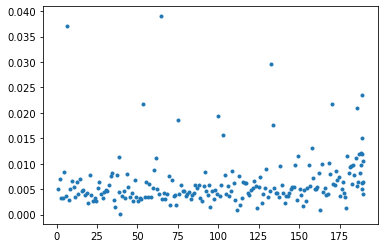

(48000026, 'e-')


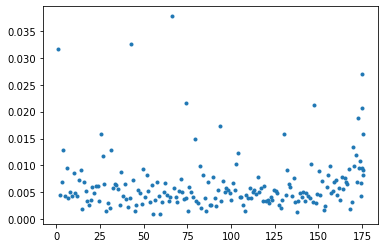

(48000027, 'e-')


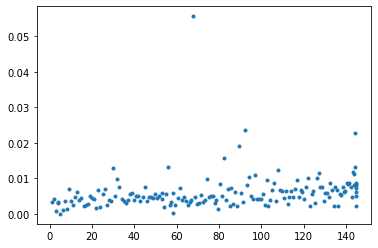

(48000028, 'e-')


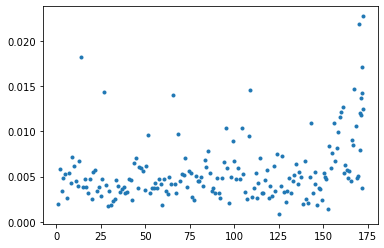

(48000030, 'e-')


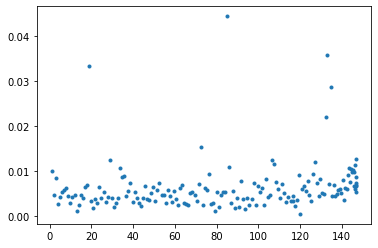

(48000031, 'e-')


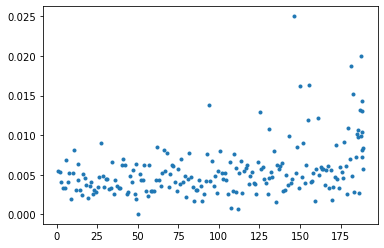

(48000032, 'e-')


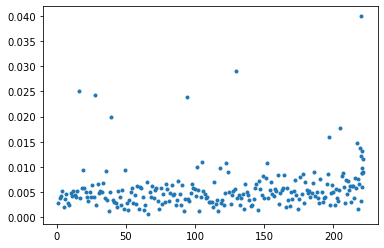

(48000033, 'e-')


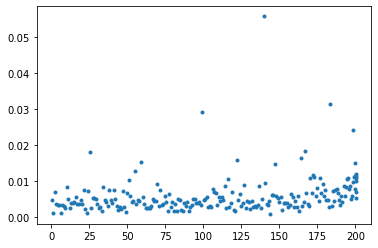

(48000034, 'e-')


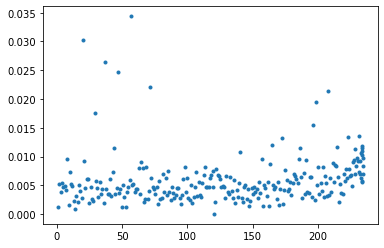

(48000035, 'e-')


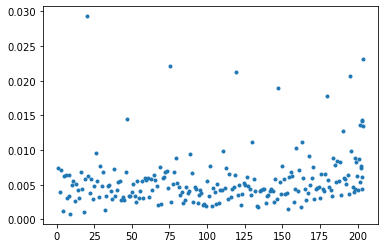

(48000036, 'e-')


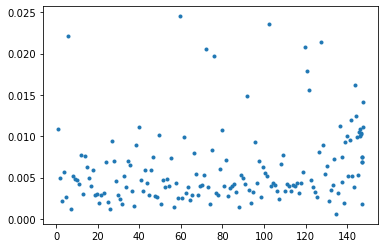

(48000037, 'e-')


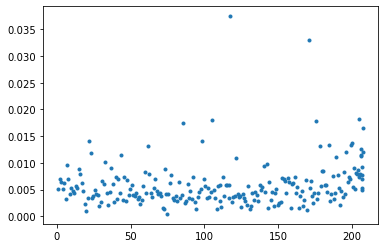

(48000038, 'e-')


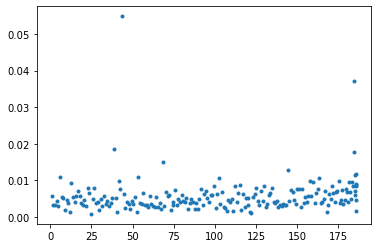

(48000039, 'e-')


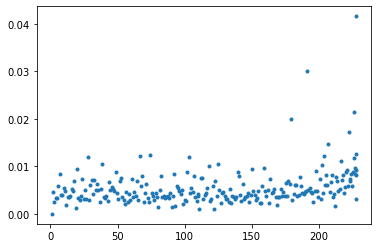

(48000040, 'e+')


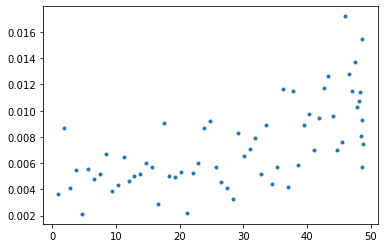

(48000040, 'e-')


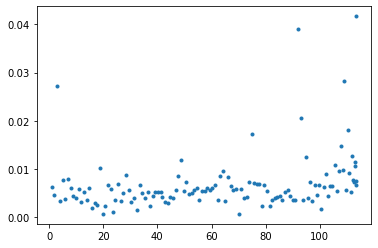

(48000041, 'e-')


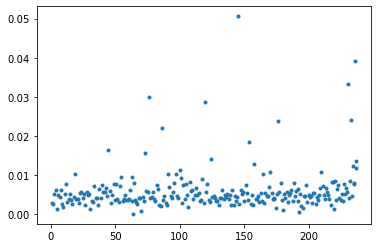

(48000042, 'e-')


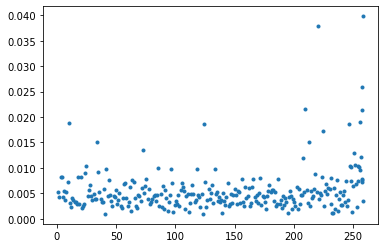

(48000043, 'e+')


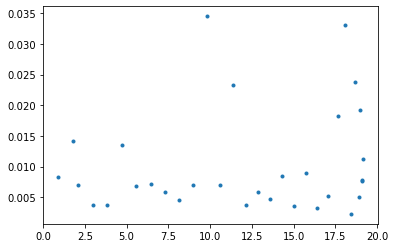

(48000043, 'e-')


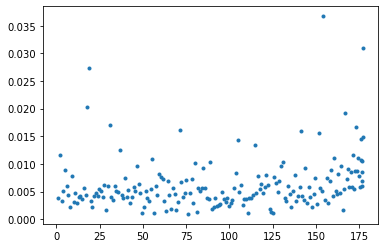

(48000044, 'e-')


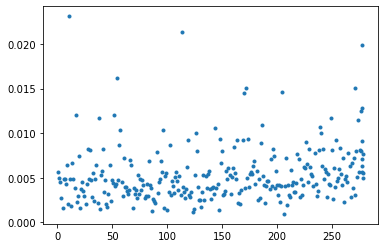

(48000045, 'e-')


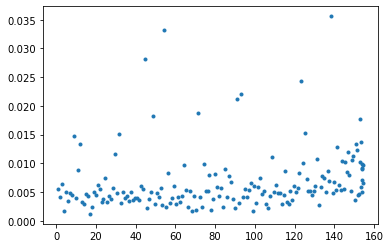

(48000046, 'e-')


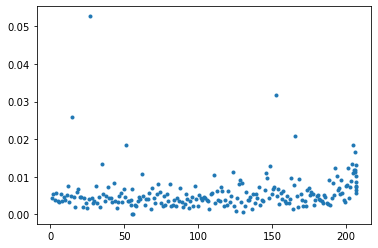

(48000047, 'e-')


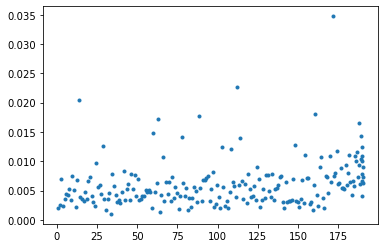

(48000048, 'e-')


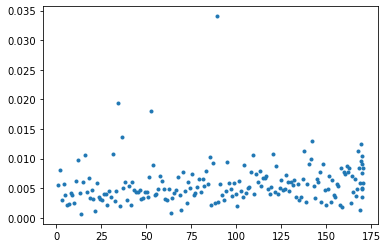

(48000049, 'e-')


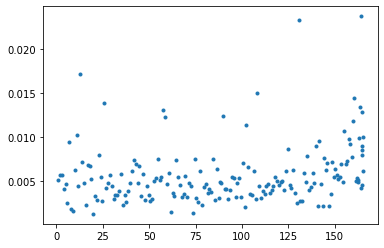

(48000050, 'e-')


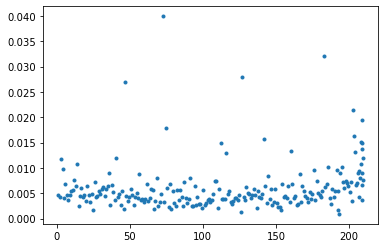

(48000051, 'e-')


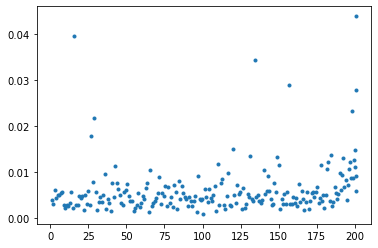

(48000052, 'e-')


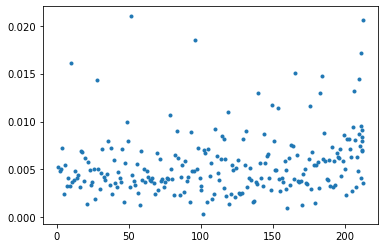

(48000053, 'e+')


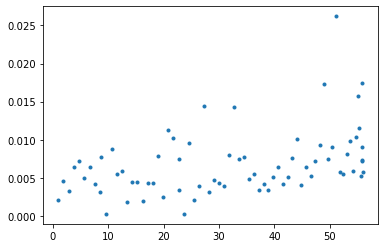

(48000053, 'e-')


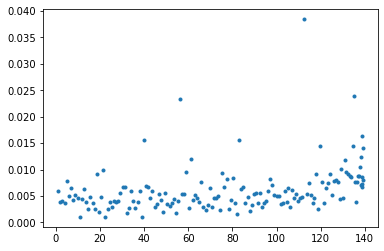

(48000054, 'e-')


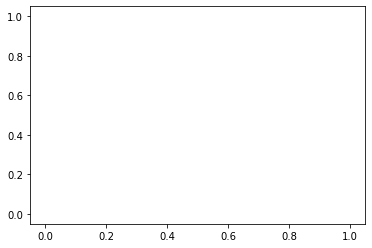

(48000055, 'e-')


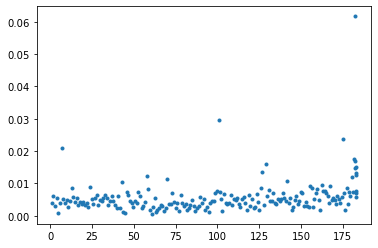

(48000056, 'e-')


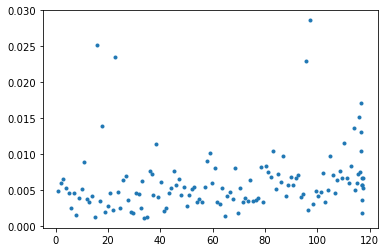

(48000057, 'e-')


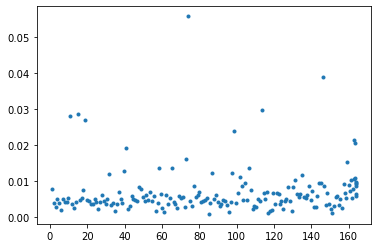

(48000058, 'e+')


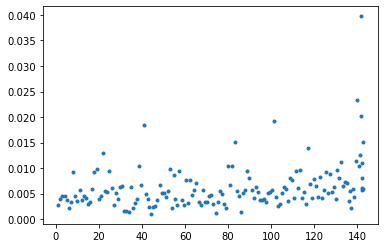

(48000058, 'e-')


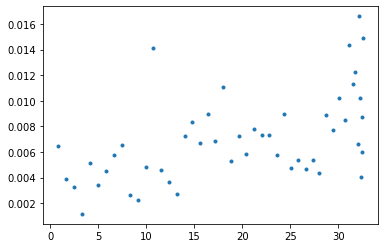

(48000059, 'e-')


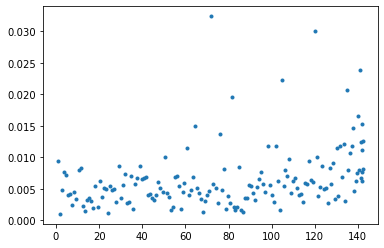

(48000060, 'e+')


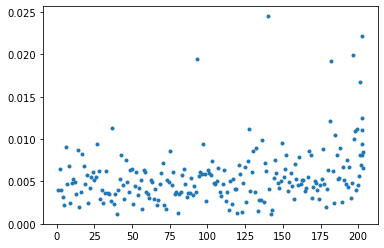

(48000060, 'e-')


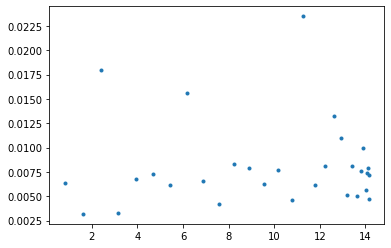

(48000061, 'e-')


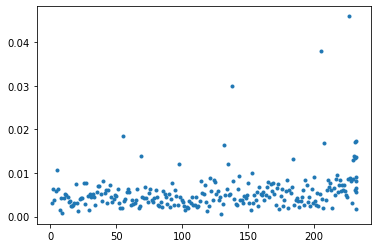

(48000062, 'e-')


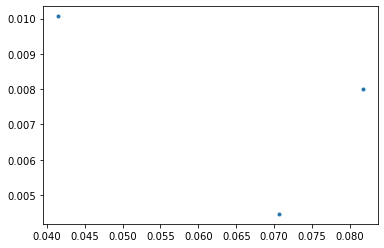

(48000063, 'e-')


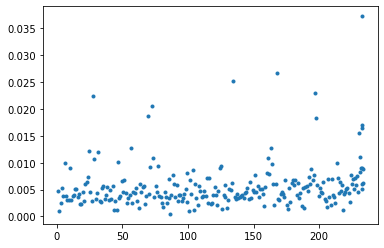

(48000064, 'e+')


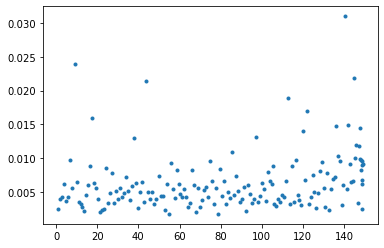

(48000064, 'e-')


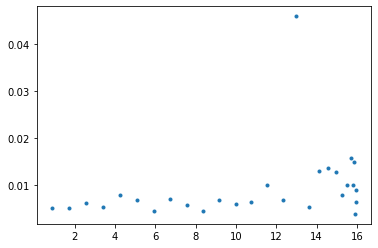

(48000066, 'e+')


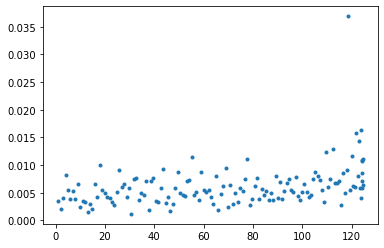

(48000066, 'e-')


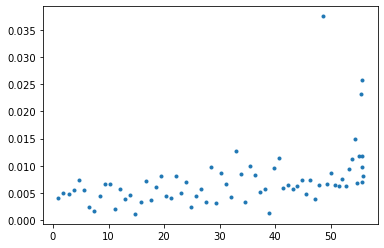

(48000067, 'e-')


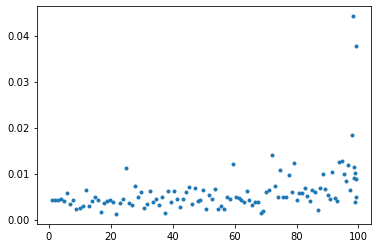

(48000068, 'e+')


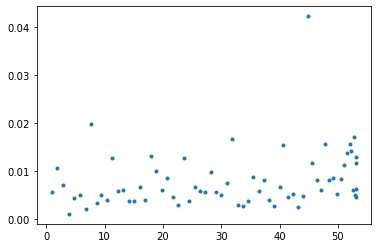

(48000068, 'e-')


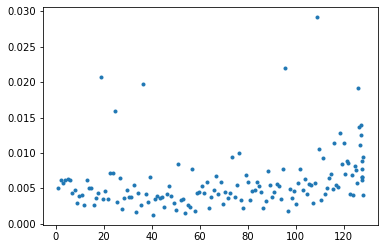

(48000069, 'e+')


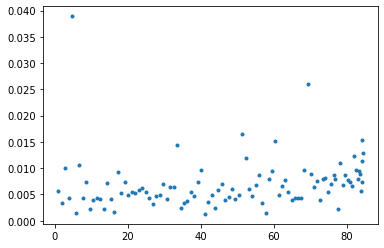

(48000069, 'e-')


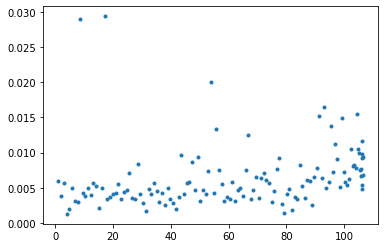

(48000070, 'e+')


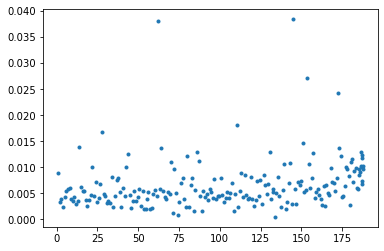

(48000070, 'e-')


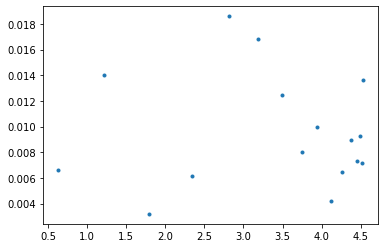

(48000071, 'e+')


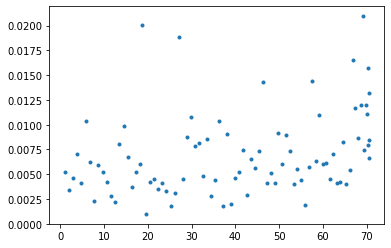

(48000071, 'e-')


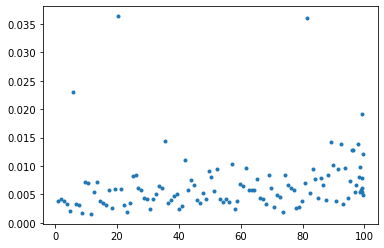

(48000073, 'e-')


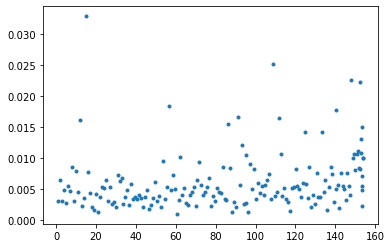

(48000074, 'e-')


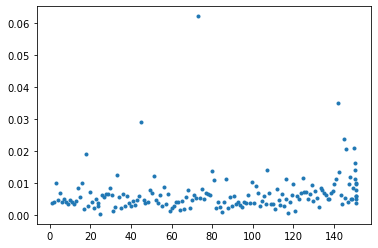

(48000075, 'e-')


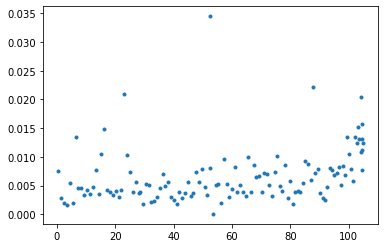

(48000076, 'e+')


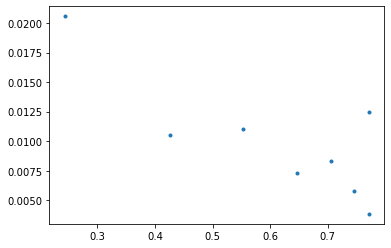

(48000076, 'e-')


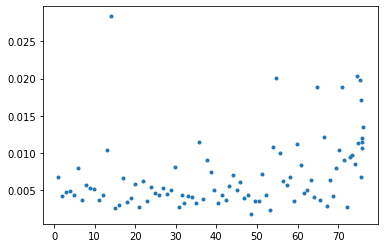

(48000077, 'e-')


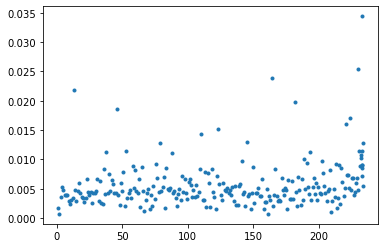

(48000078, 'e-')


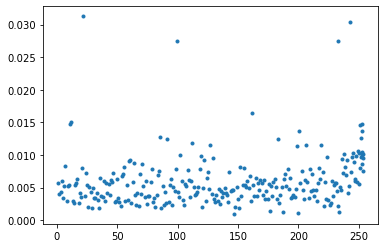

(48000079, 'e+')


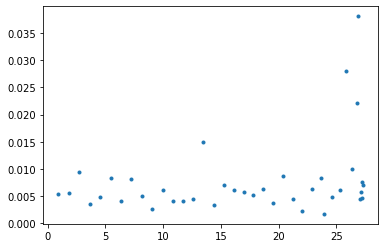

(48000079, 'e-')


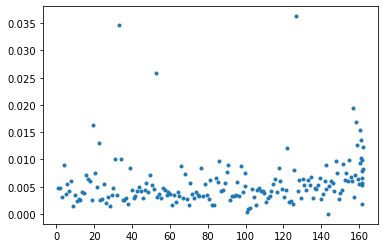

(48000080, 'e-')


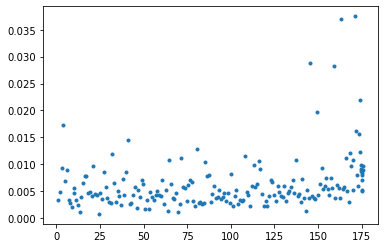

(48000081, 'e+')


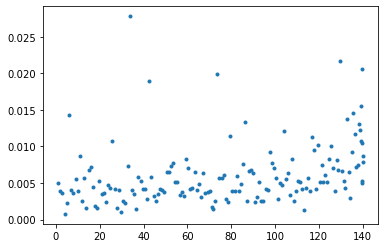

(48000081, 'e-')


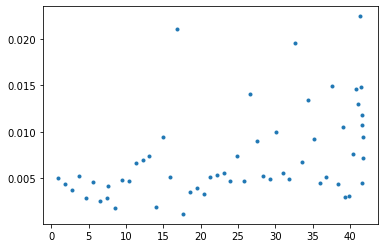

(48000082, 'e-')


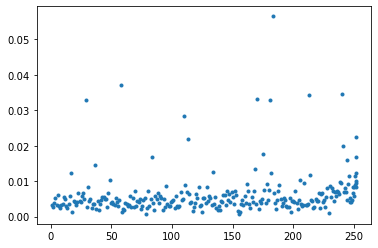

(48000083, 'e+')


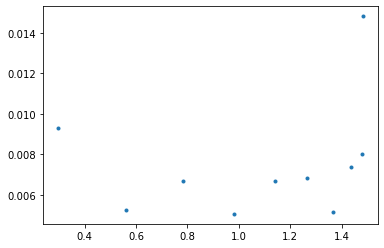

(48000083, 'e-')


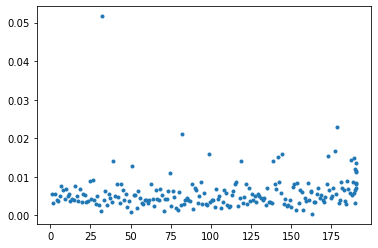

(48000084, 'e-')


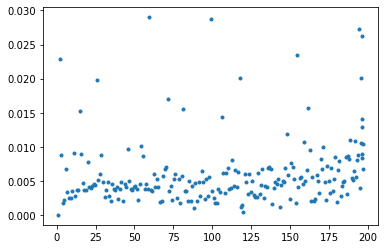

(48000085, 'e-')


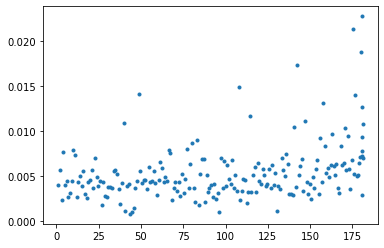

(48000086, 'e-')


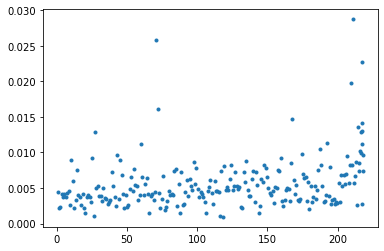

(48000087, 'e+')


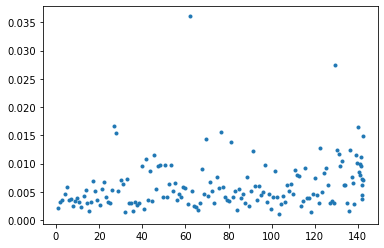

(48000087, 'e-')


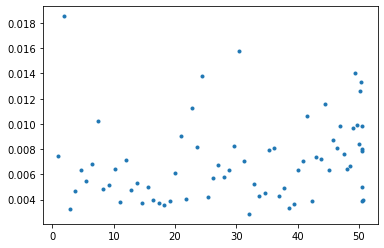

(48000088, 'e-')


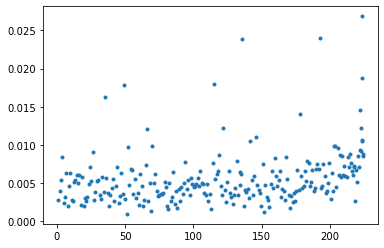

(48000089, 'e-')


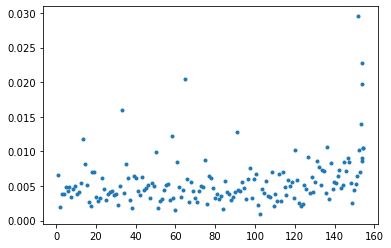

(48000090, 'e-')


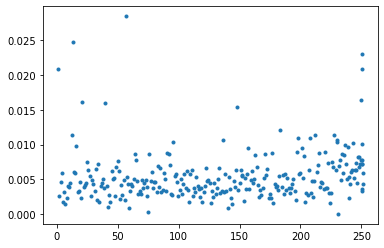

(48000091, 'e-')


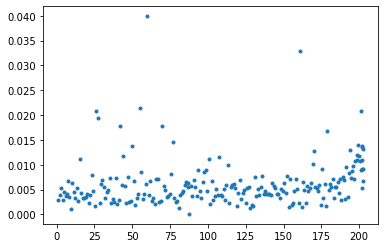

(48000092, 'e-')


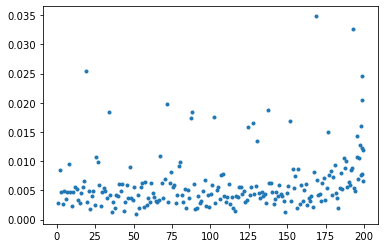

(48000093, 'e+')


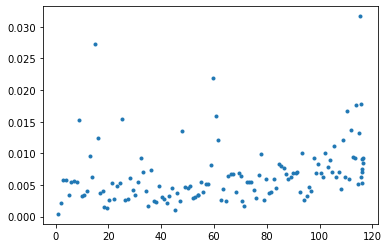

(48000093, 'e-')


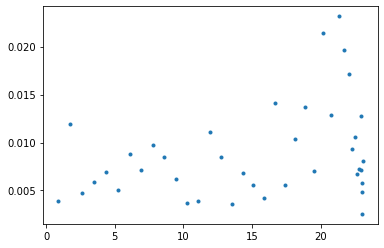

(48000094, 'e-')


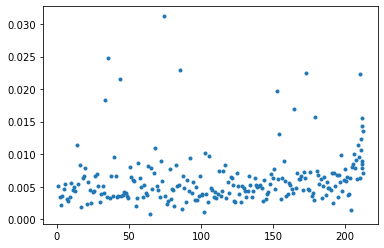

(48000096, 'e+')


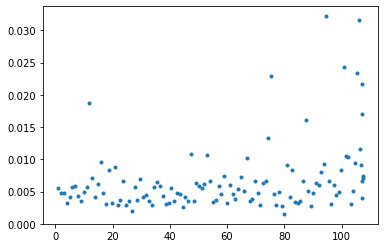

(48000096, 'e-')


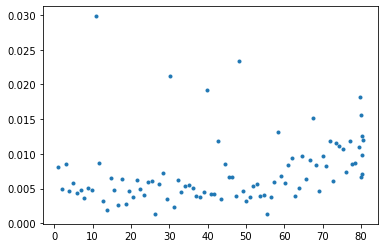

(48000097, 'e-')


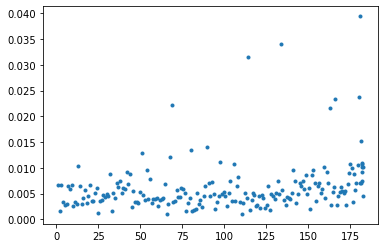

(48000098, 'e+')


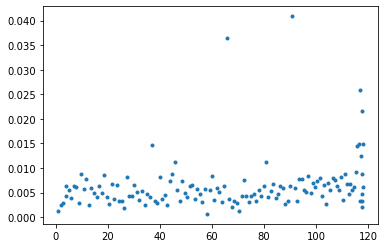

(48000098, 'e-')


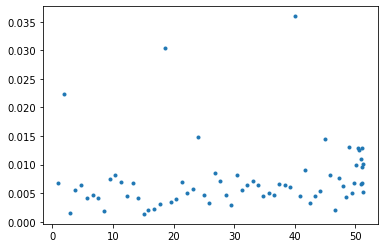

(48000099, 'e-')


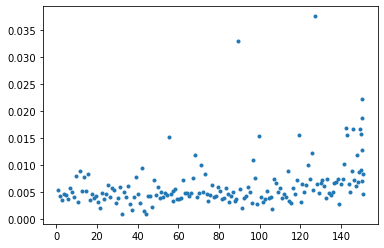

(48000101, 'e-')


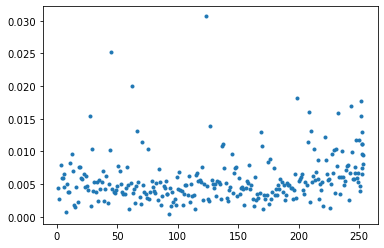

(48000102, 'e+')


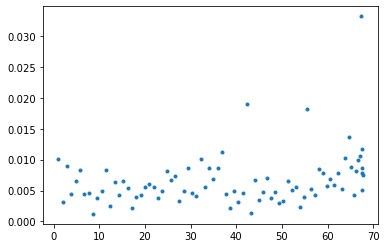

(48000102, 'e-')


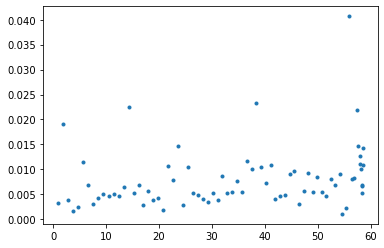

(48000103, 'e-')


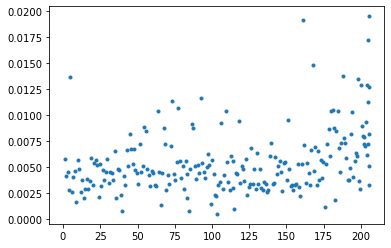

(48000104, 'e-')


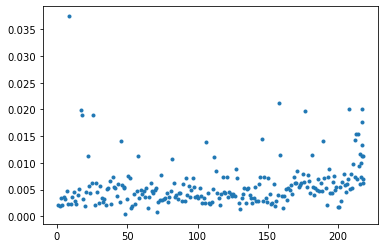

(48000106, 'e-')


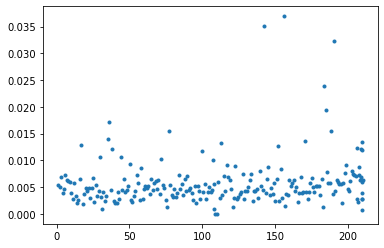

(48000107, 'e-')


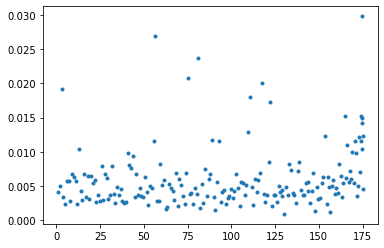

(48000108, 'e-')


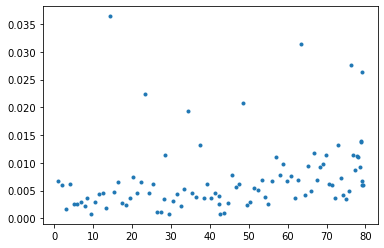

(48000109, 'e-')


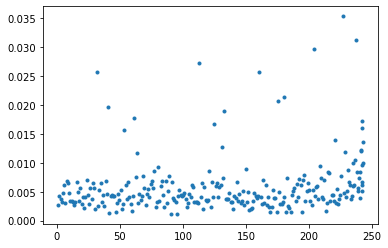

(48000110, 'e-')


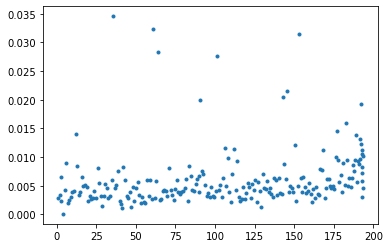

(48000111, 'e-')


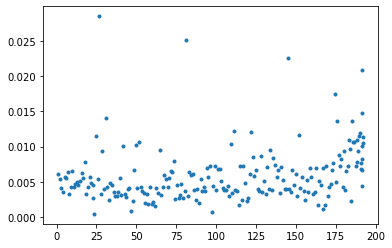

(48000112, 'e+')


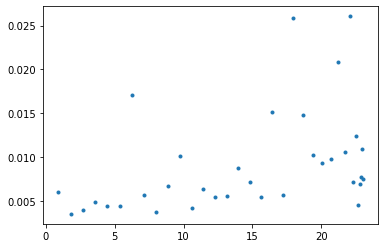

(48000112, 'e-')


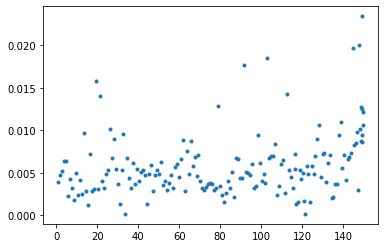

(48000113, 'e-')


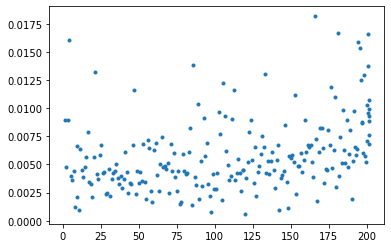

(48000114, 'e-')


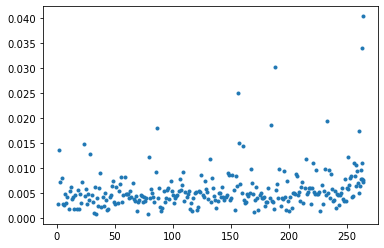

(48000115, 'e-')


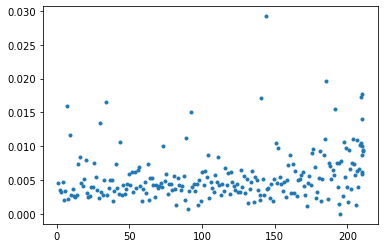

(48000116, 'e-')


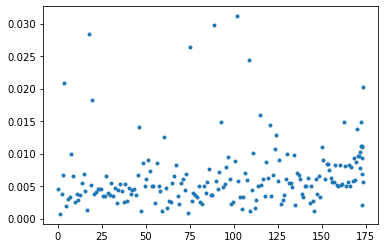

(48000117, 'e-')


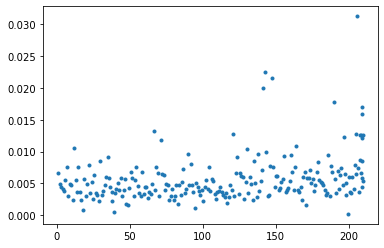

(48000118, 'e-')


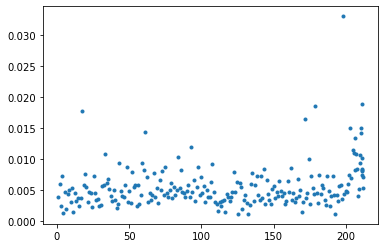

(48000119, 'e-')


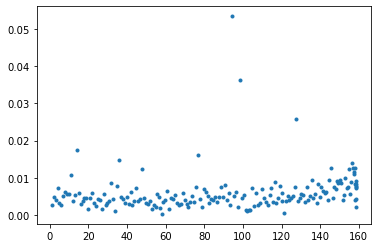

(48000120, 'e+')


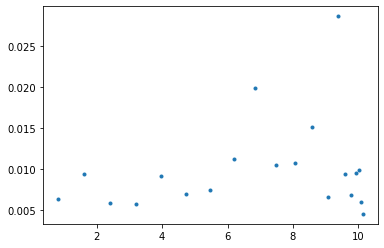

(48000120, 'e-')


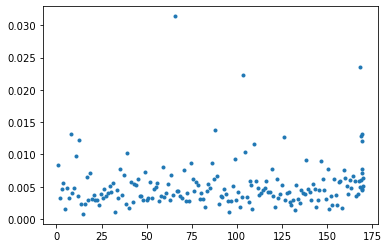

(48000121, 'e-')


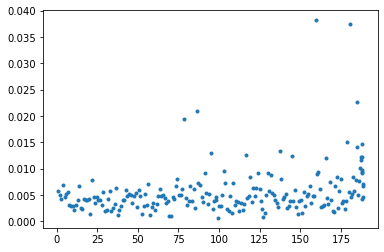

(48000122, 'e+')


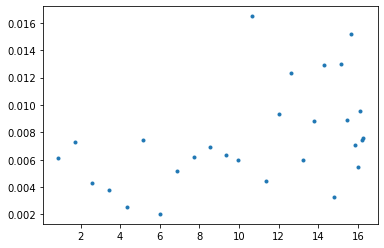

(48000122, 'e-')


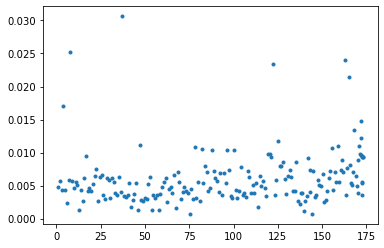

(48000123, 'e-')


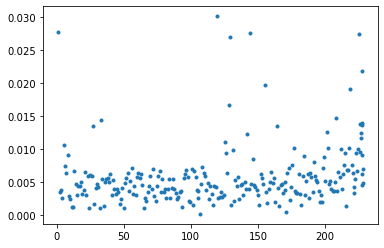

(48000124, 'e+')


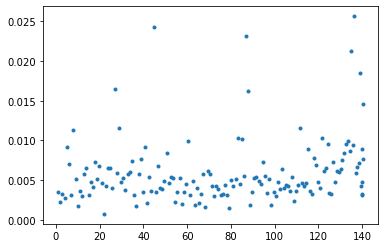

(48000124, 'e-')


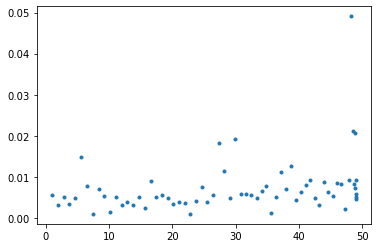

(48000125, 'e-')


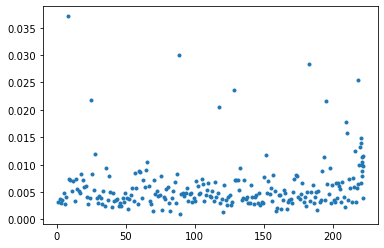

(48000126, 'e-')


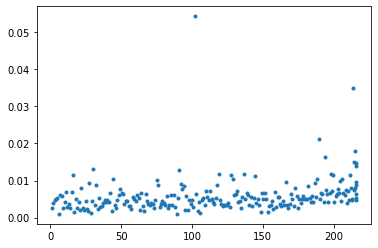

(48000127, 'e-')


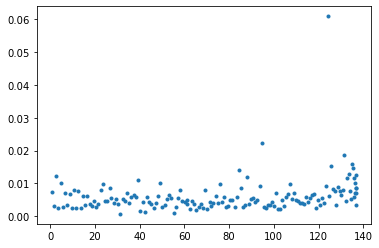

(48000128, 'e-')


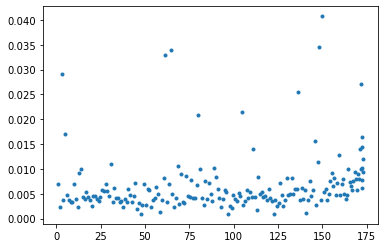

(48000129, 'e+')


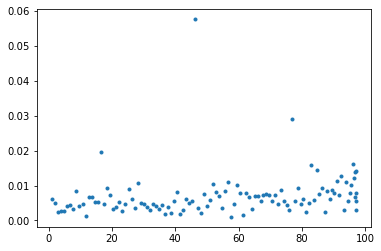

(48000129, 'e-')


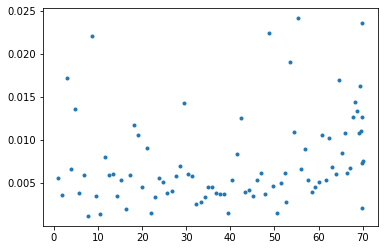

(48000130, 'e-')


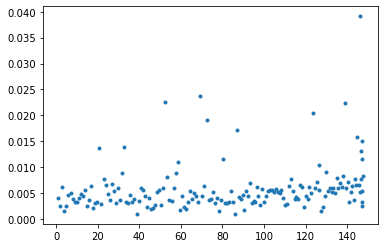

(48000131, 'e+')


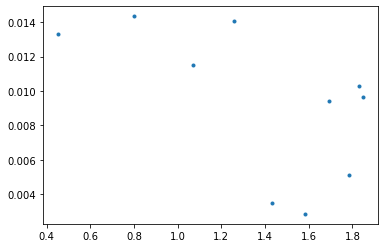

(48000131, 'e-')


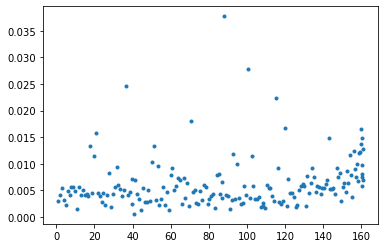

(48000132, 'e-')


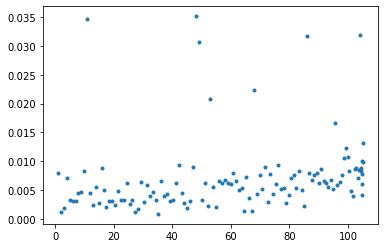

(48000133, 'e-')


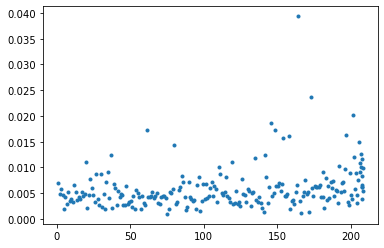

(48000134, 'e-')


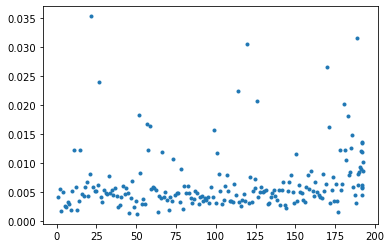

(48000135, 'e-')


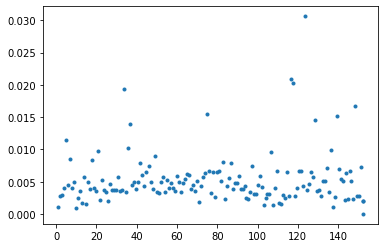

(48000136, 'e-')


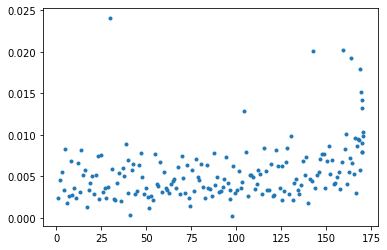

(48000137, 'e-')


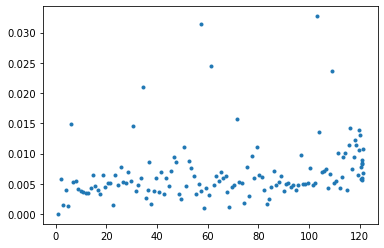

(48000138, 'e-')


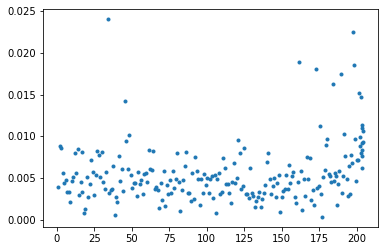

(48000139, 'e-')


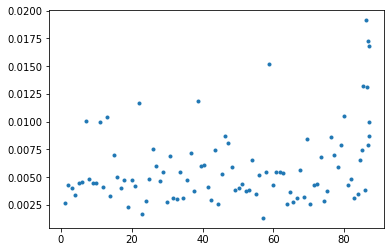

(48000140, 'e-')


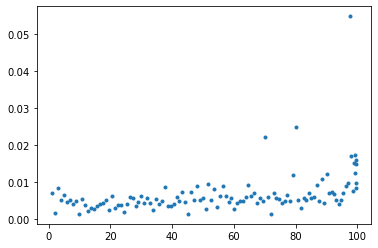

(48000141, 'e-')


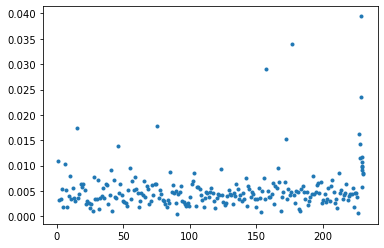

(48000142, 'e-')


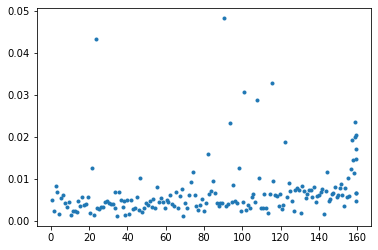

(48000143, 'e-')


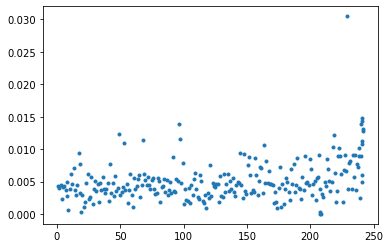

(48000144, 'e+')


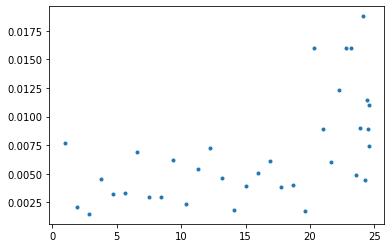

(48000144, 'e-')


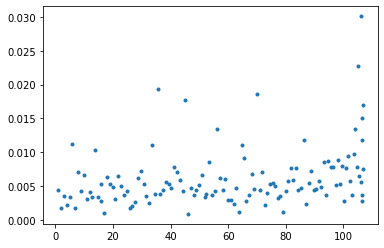

(48000145, 'e+')


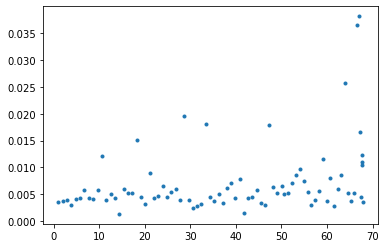

(48000145, 'e-')


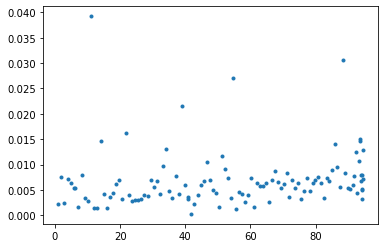

(48000146, 'e-')


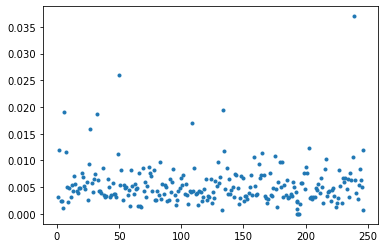

(48000147, 'e-')


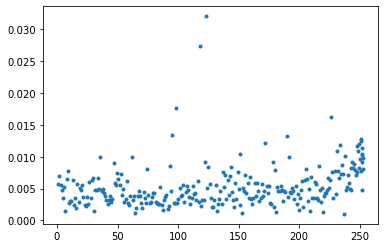

(48000148, 'e-')


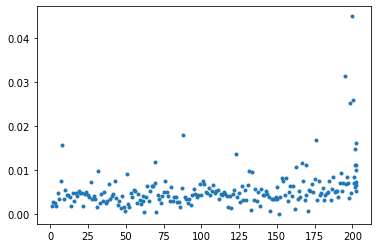

(48000149, 'e-')


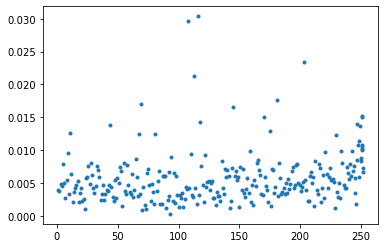

(48000150, 'e-')


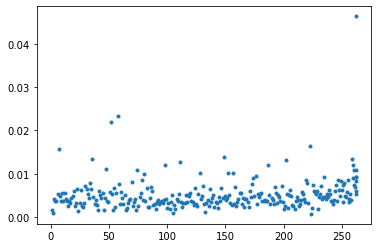

(48000151, 'e+')


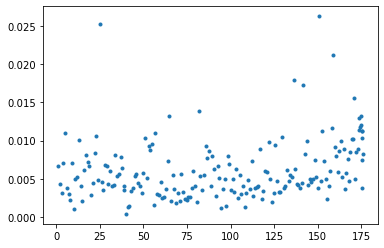

(48000151, 'e-')


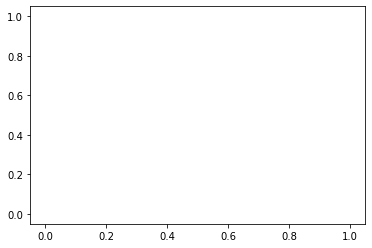

(48000152, 'e+')


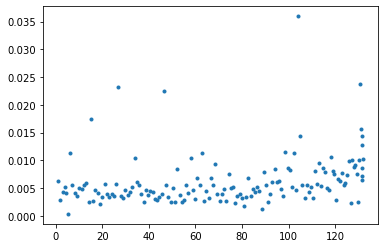

(48000152, 'e-')


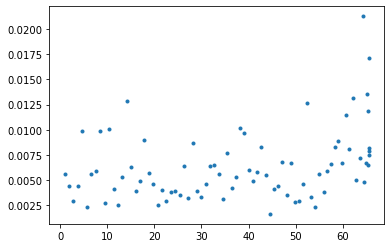

(48000153, 'e+')


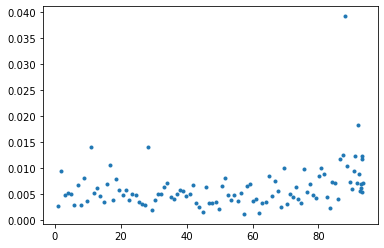

(48000153, 'e-')


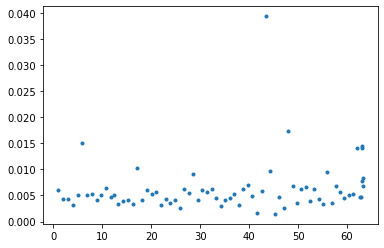

(48000154, 'e+')


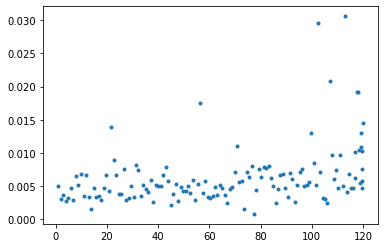

(48000154, 'e-')


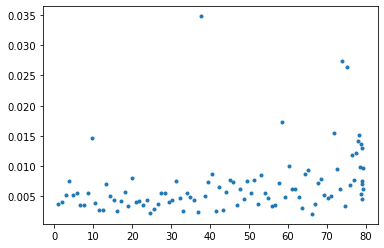

(48000155, 'e-')


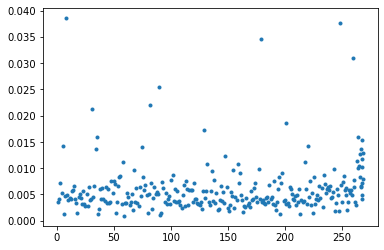

(48000156, 'e-')


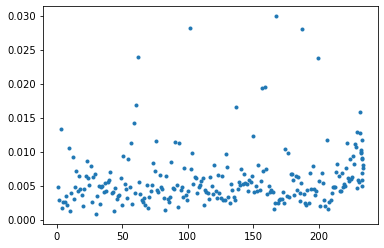

(48000157, 'e-')


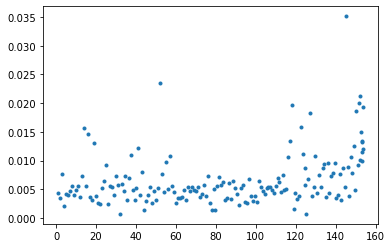

(48000158, 'e+')


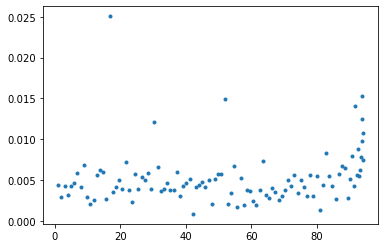

(48000158, 'e-')


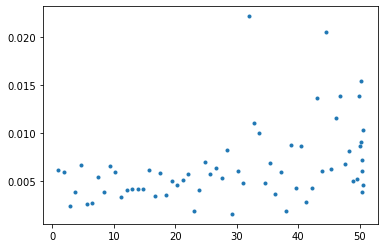

(48000159, 'e-')


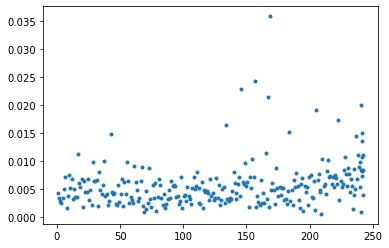

(48000160, 'e-')


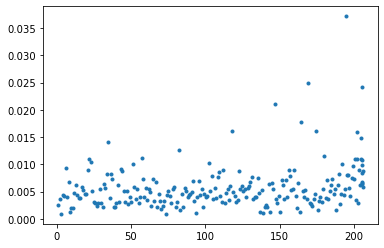

(48000161, 'e-')


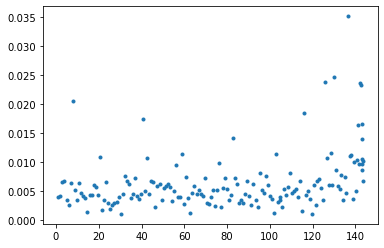

(48000162, 'e-')


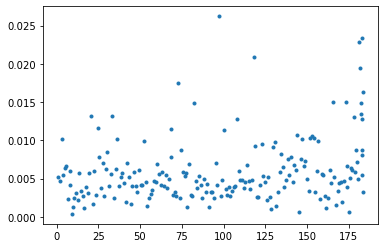

(48000163, 'e+')


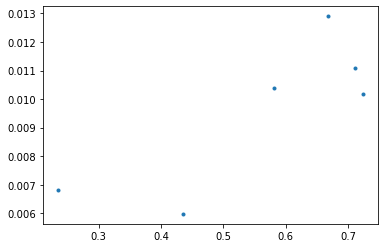

(48000163, 'e-')


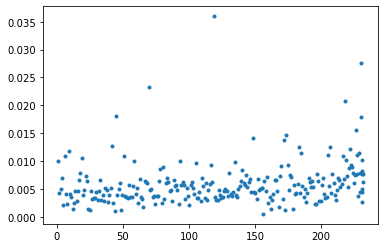

(48000164, 'e-')


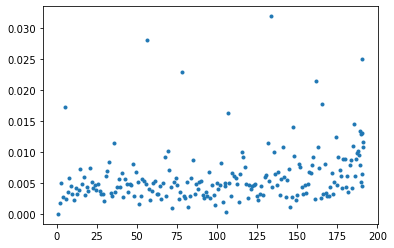

(48000165, 'e-')


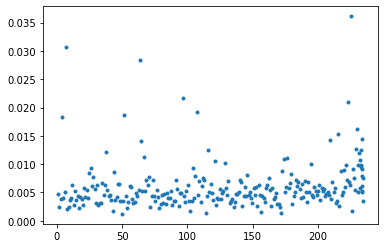

(48000166, 'e-')


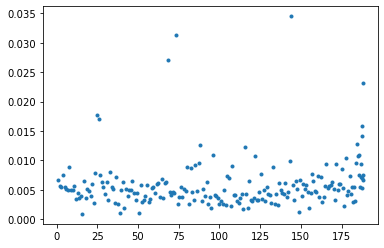

(48000167, 'e-')


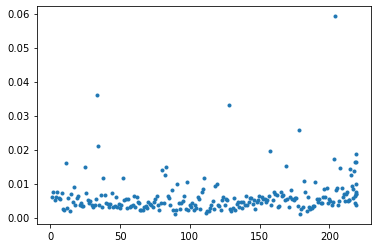

(48000168, 'e+')


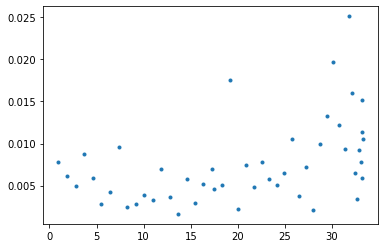

(48000168, 'e-')


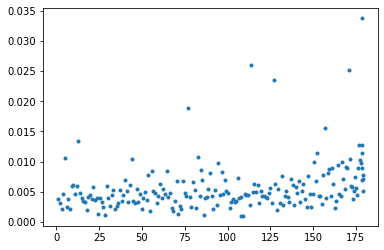

(48000169, 'e+')


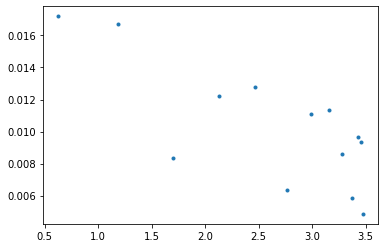

(48000169, 'e-')


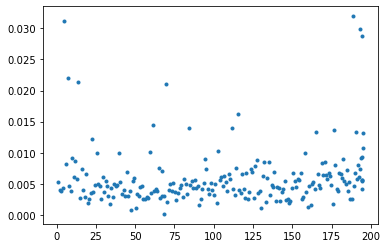

(48000170, 'e+')


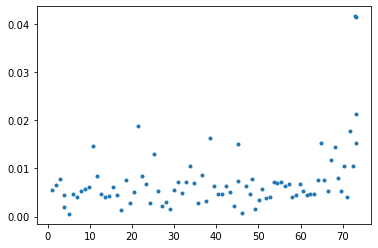

(48000170, 'e-')


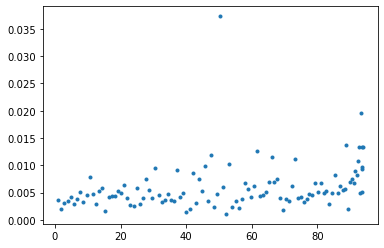

(48000171, 'e+')


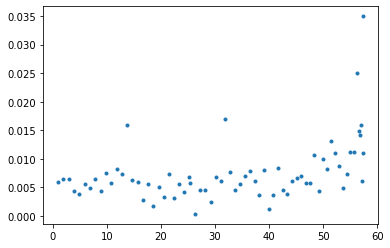

(48000171, 'e-')


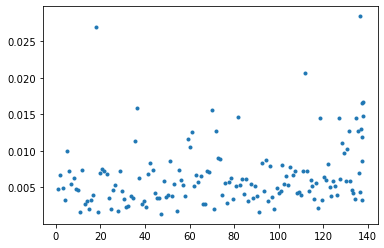

(48000172, 'e-')


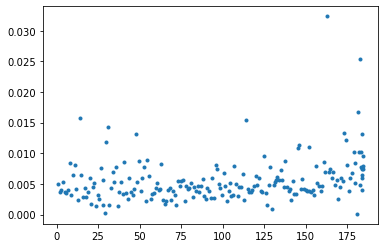

(48000173, 'e-')


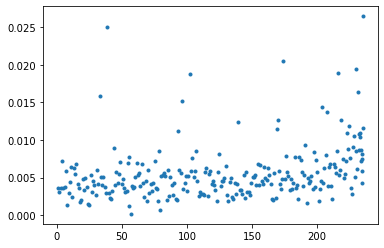

(48000174, 'e+')


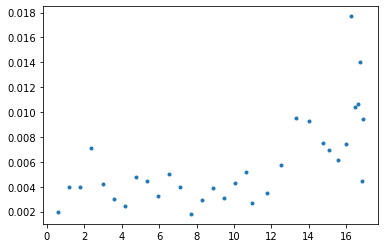

(48000174, 'e-')


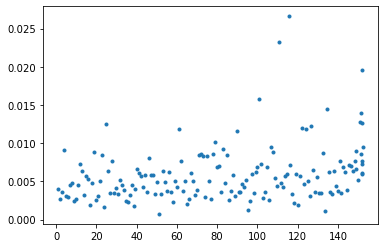

(48000175, 'e-')


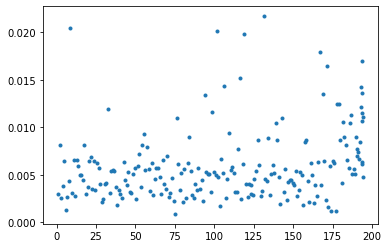

(48000176, 'e-')


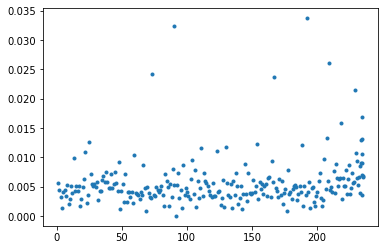

(48000177, 'e-')


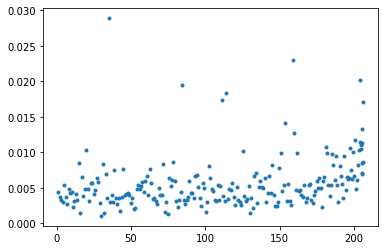

(48000178, 'e+')


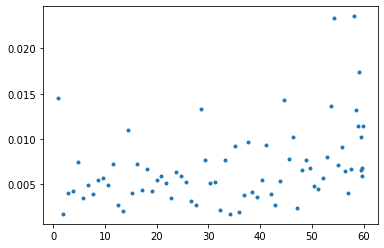

(48000178, 'e-')


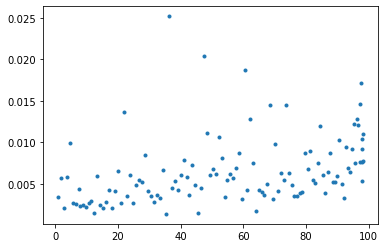

(48000179, 'e-')


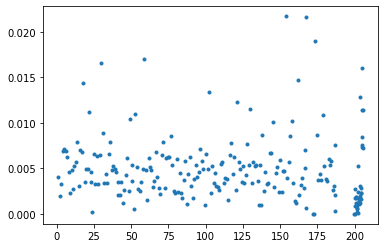

(48000180, 'e-')


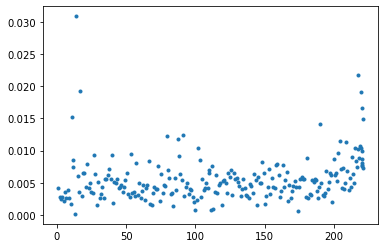

(48000181, 'e+')


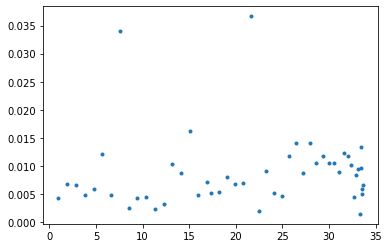

(48000181, 'e-')


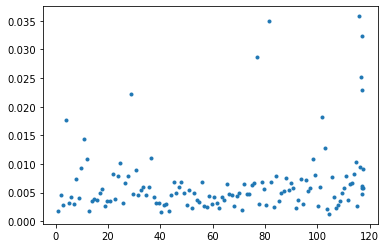

(48000182, 'e-')


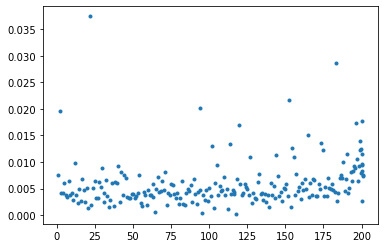

(48000183, 'e-')


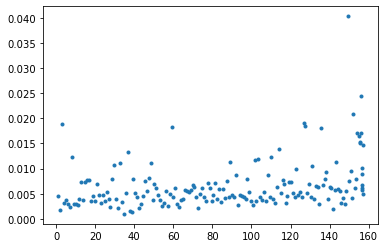

(48000184, 'e+')


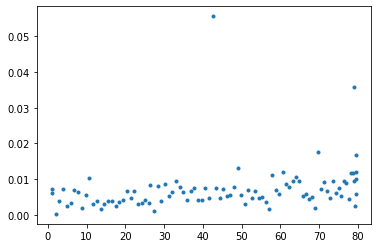

(48000184, 'e-')


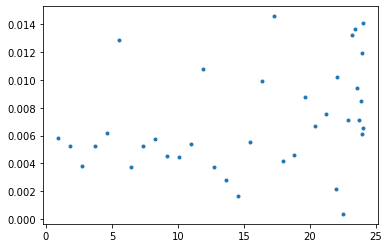

(48000185, 'e+')


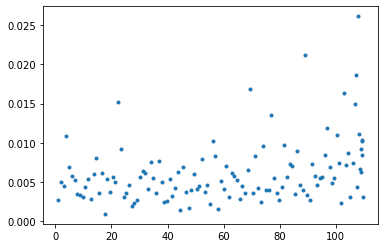

(48000185, 'e-')


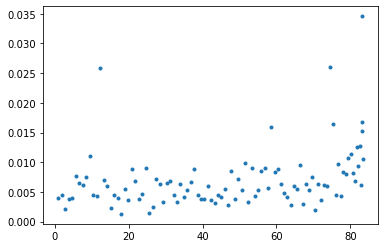

(48000186, 'e-')


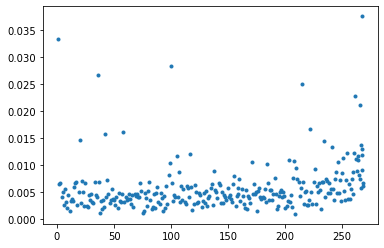

(48000187, 'e+')


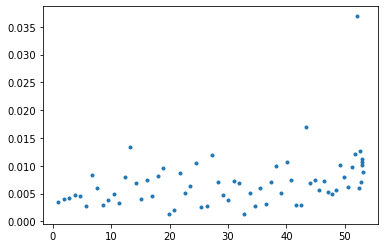

(48000187, 'e-')


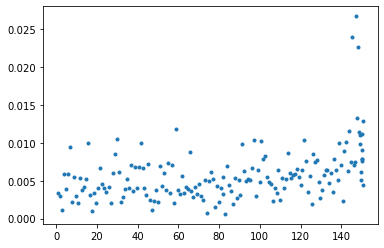

(48000188, 'e+')


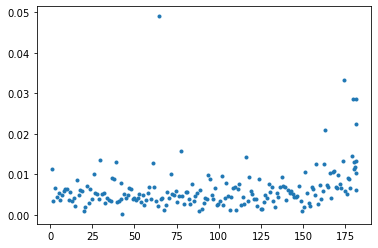

(48000188, 'e-')


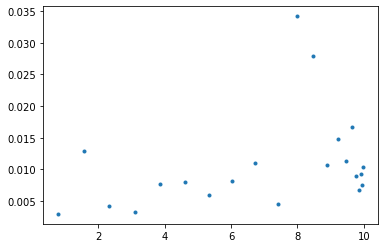

(48000189, 'e-')


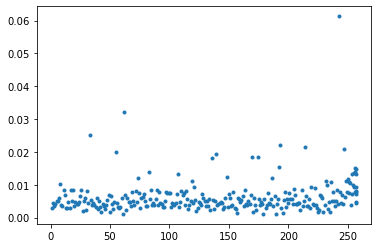

(48000190, 'e-')


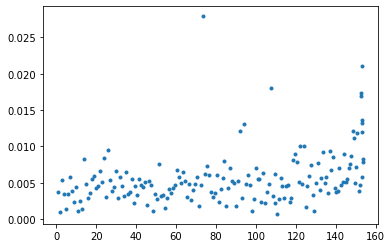

(48000191, 'e+')


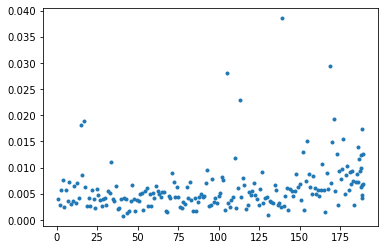

(48000191, 'e-')


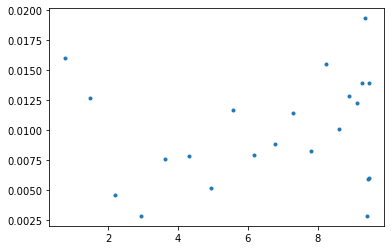

(48000192, 'e+')


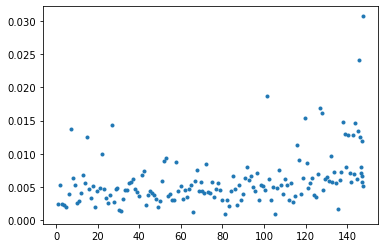

(48000192, 'e-')


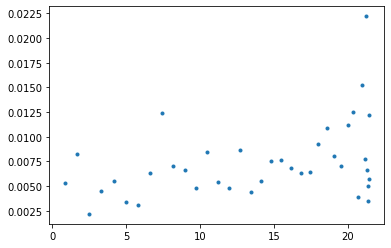

(48000193, 'e-')


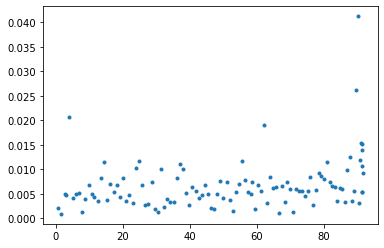

(48000194, 'e-')


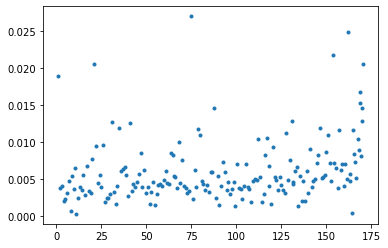

(48000195, 'e-')


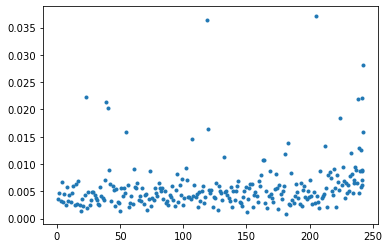

(48000196, 'e-')


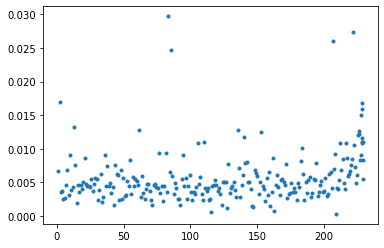

(48000197, 'e-')


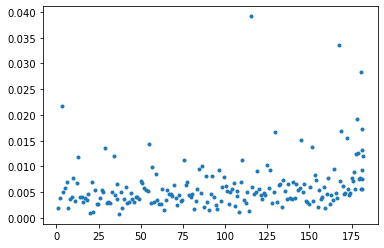

(48000198, 'e-')


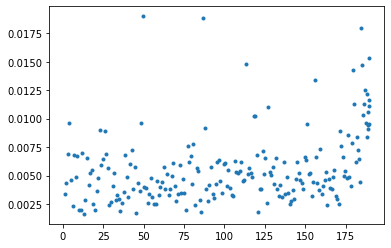

(48000199, 'e-')


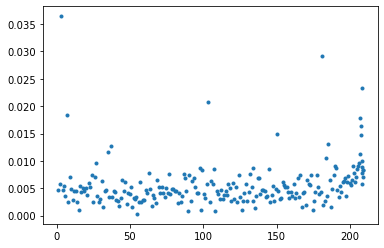

(48000200, 'e-')


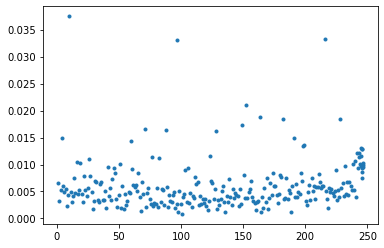

(48000202, 'e-')


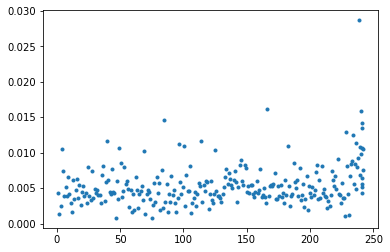

(48000203, 'e-')


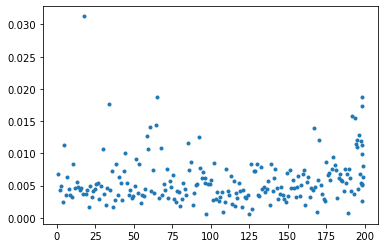

(48000204, 'e-')


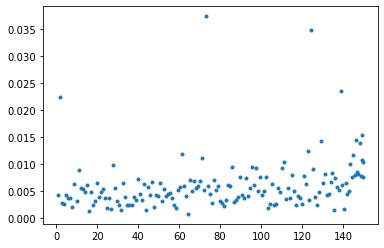

(48000205, 'e-')


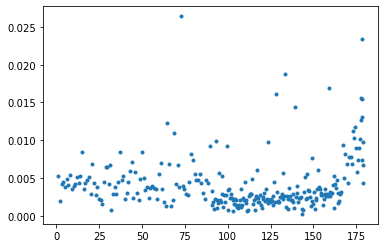

(48000206, 'e-')


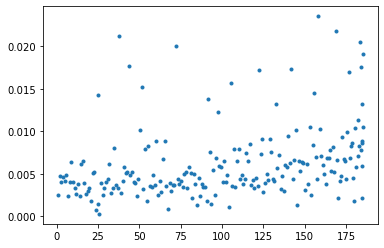

(48000207, 'e-')


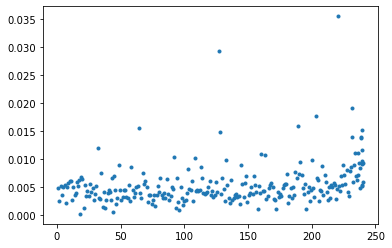

(48000208, 'e-')


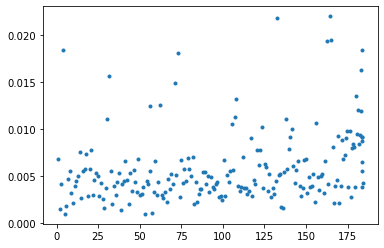

(48000209, 'e-')


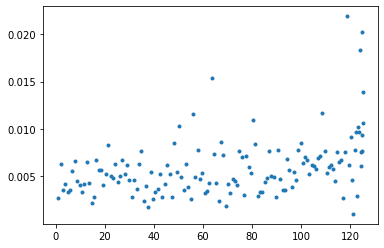

(48000210, 'e-')


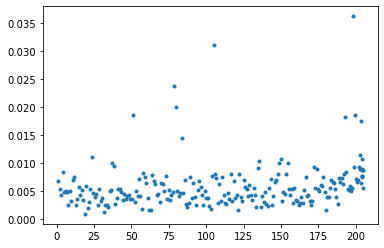

(48000211, 'e-')


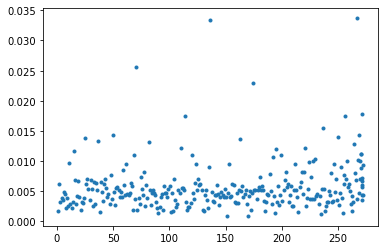

(48000212, 'e-')


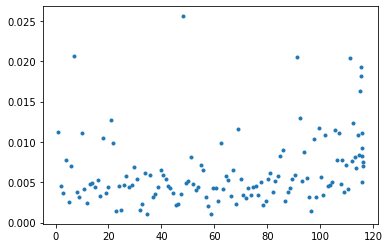

(48000213, 'e-')


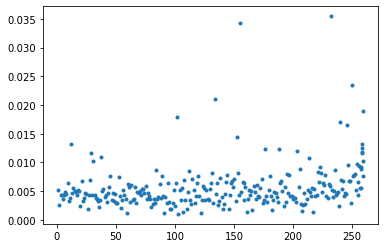

(48000214, 'e-')


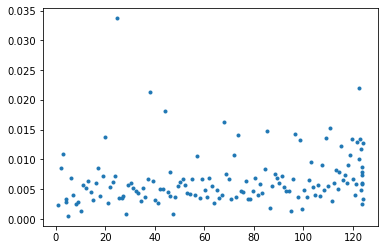

(48000215, 'e-')


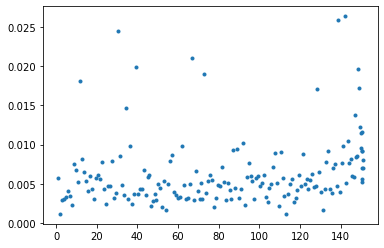

(48000216, 'e-')


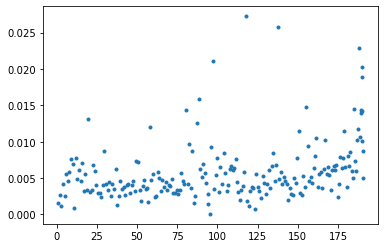

(48000217, 'e+')


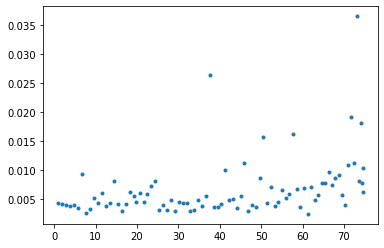

(48000217, 'e-')


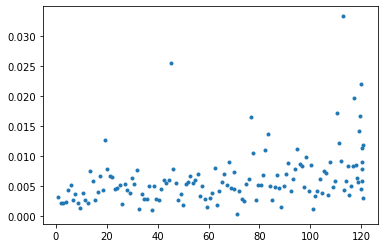

(48000218, 'e-')


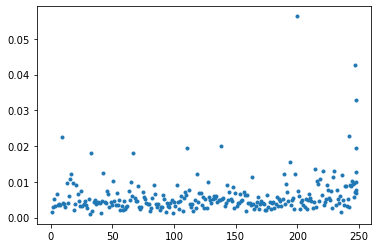

(48000219, 'e-')


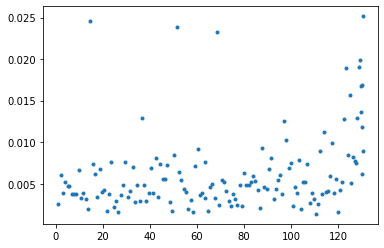

(48000220, 'e-')


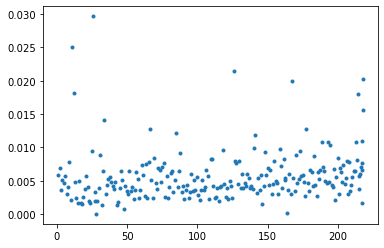

(48000221, 'e+')


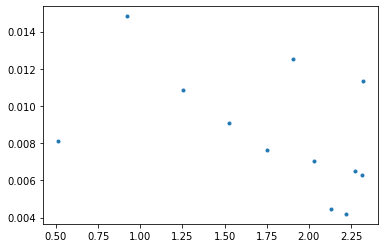

(48000221, 'e-')


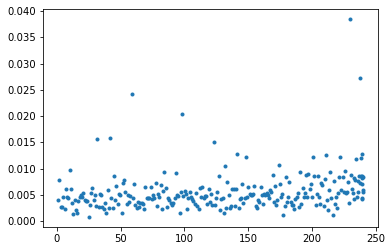

(48000222, 'e+')


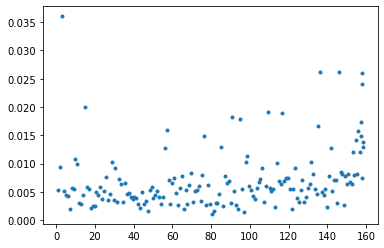

(48000222, 'e-')


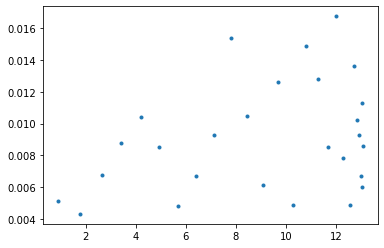

(48000223, 'e-')


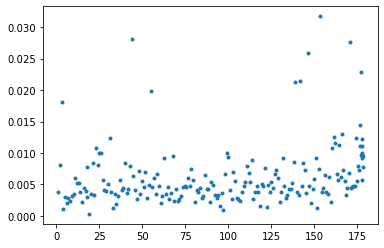

(48000224, 'e-')


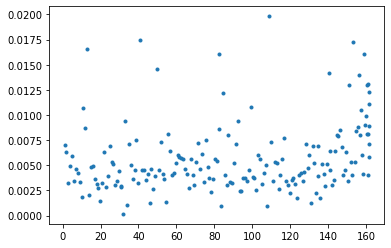

(48000225, 'e+')


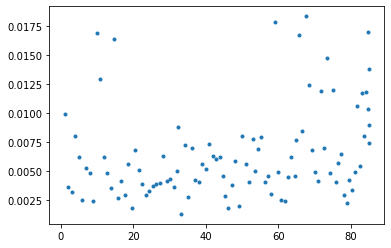

(48000225, 'e-')


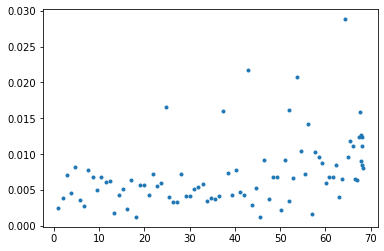

(48000226, 'e-')


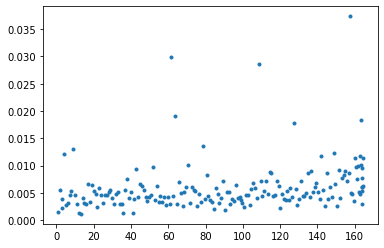

(48000228, 'e-')


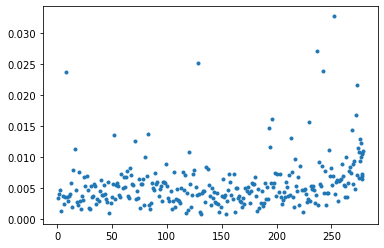

(48000229, 'e-')


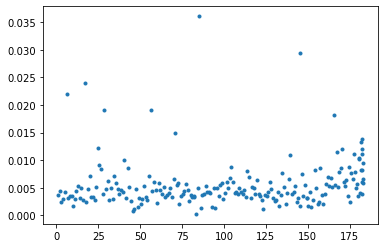

(48000230, 'e-')


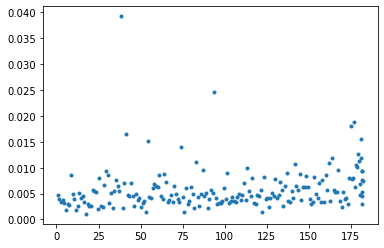

(48000231, 'e-')


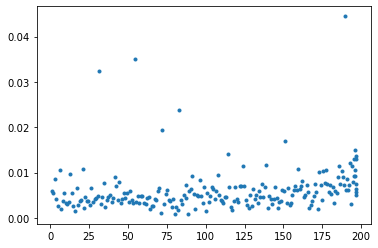

(48000232, 'e-')


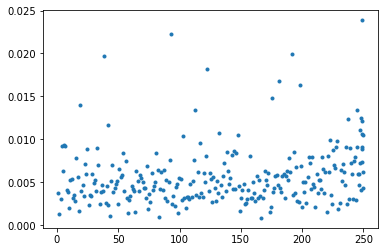

(48000233, 'e-')


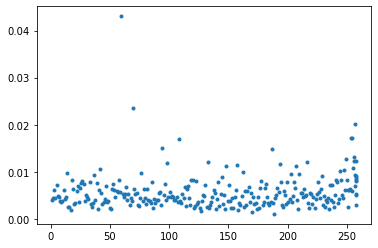

(48000234, 'e-')


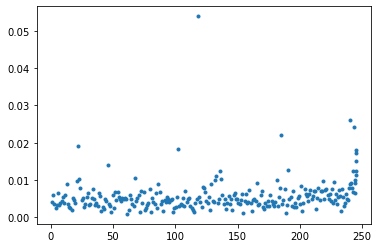

(48000235, 'e+')


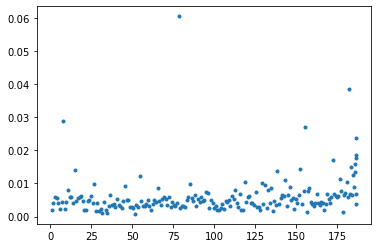

(48000235, 'e-')


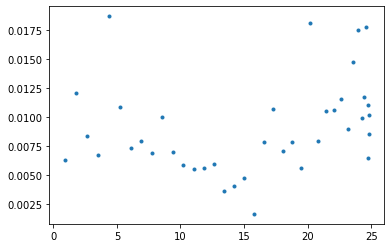

(48000236, 'e+')


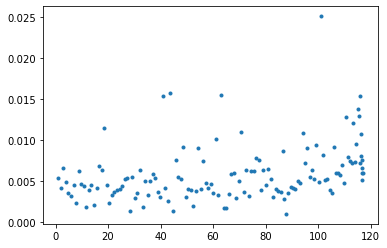

(48000236, 'e-')


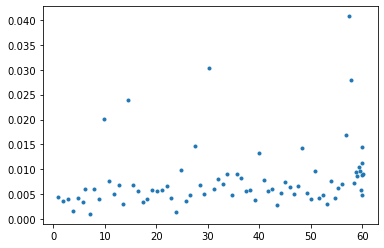

(48000237, 'e-')


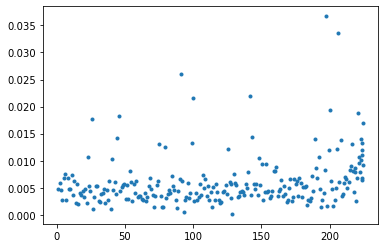

(48000238, 'e-')


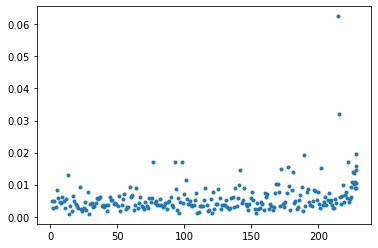

(48000239, 'e-')


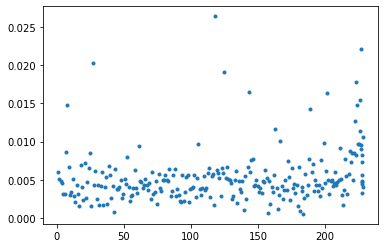

(48000240, 'e-')


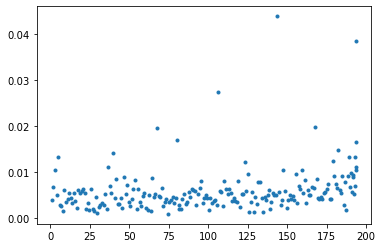

(48000241, 'e-')


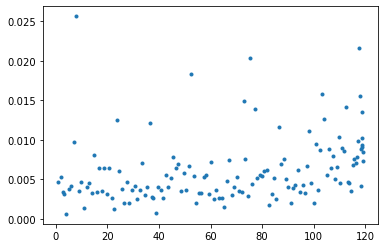

(48000242, 'e-')


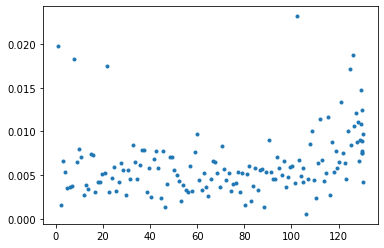

(48000243, 'e+')


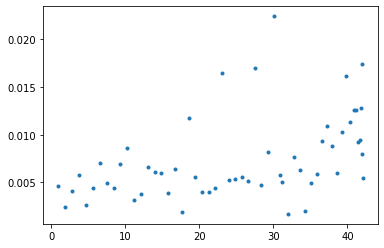

(48000243, 'e-')


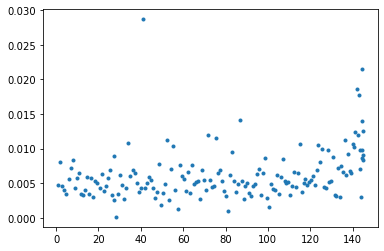

(48000244, 'e-')


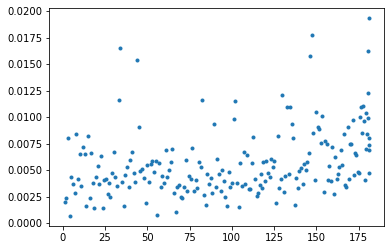

(48000245, 'e-')


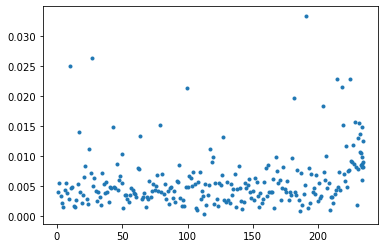

(48000246, 'e-')


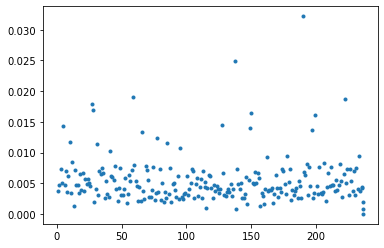

(48000247, 'e-')


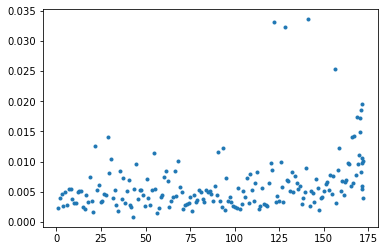

(48000248, 'e-')


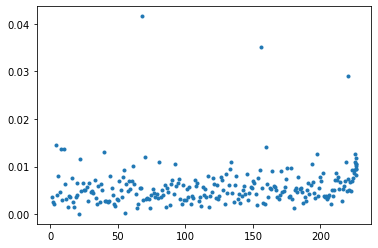

(48000249, 'e-')


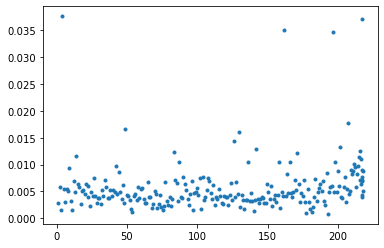

(48000250, 'e-')


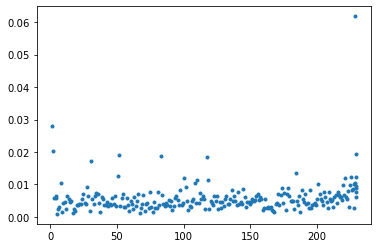

(48000251, 'e-')


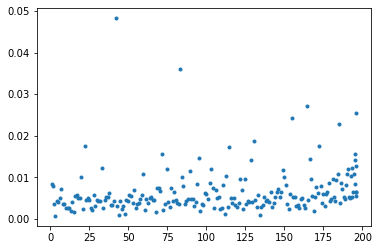

(48000252, 'e+')


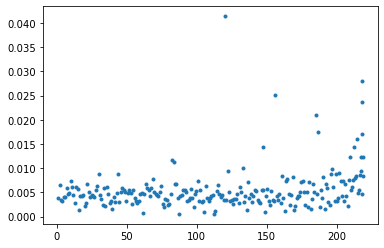

(48000252, 'e-')


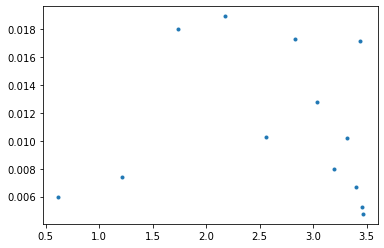

(48000253, 'e-')


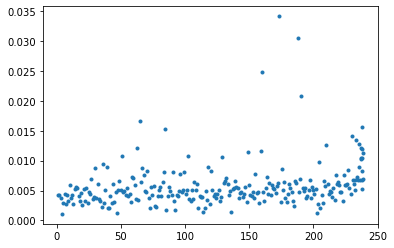

(48000254, 'e-')


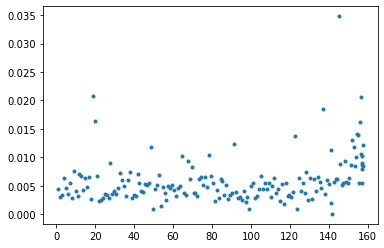

(48000255, 'e-')


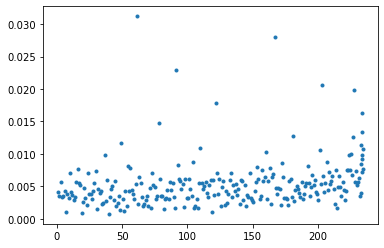

(48000256, 'e-')


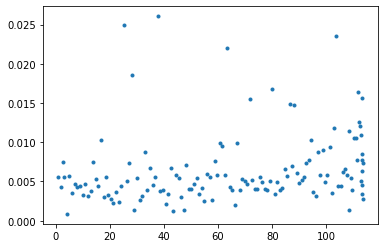

(48000257, 'e-')


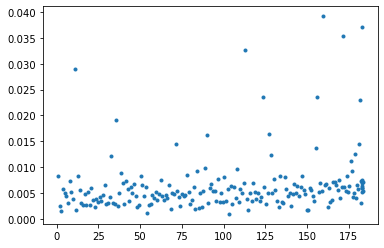

(48000258, 'e-')


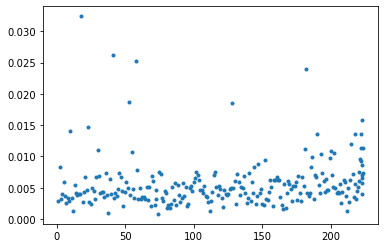

(48000259, 'e-')


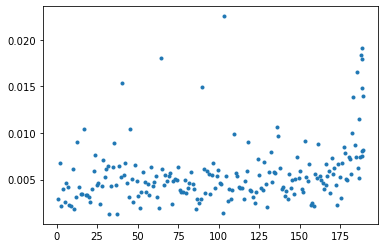

(48000260, 'e-')


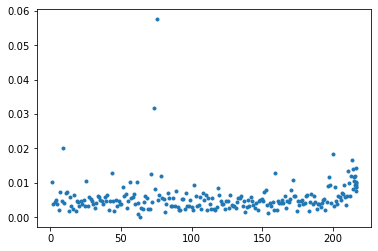

(48000261, 'e-')


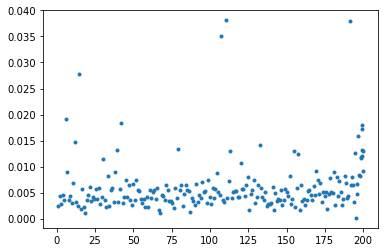

(48000262, 'e-')


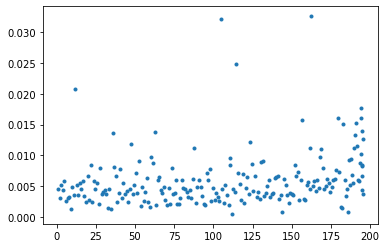

(48000263, 'e-')


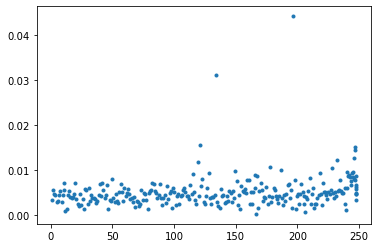

(48000264, 'e-')


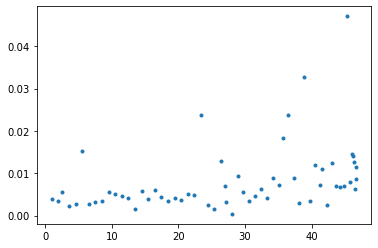

(48000265, 'e-')


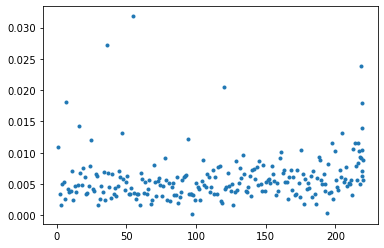

(48000266, 'e-')


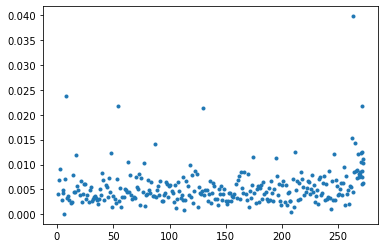

(48000267, 'e+')


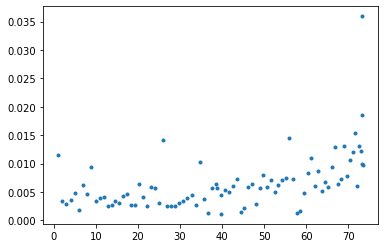

(48000267, 'e-')


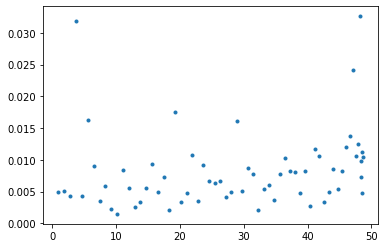

(48000268, 'e-')


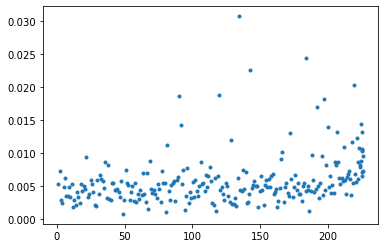

(48000269, 'e-')


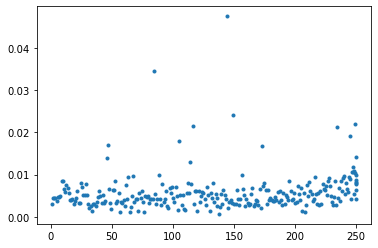

(48000270, 'e+')


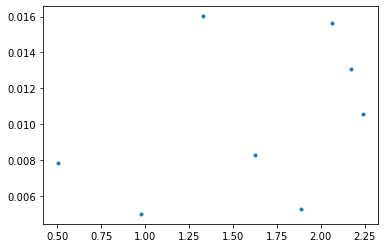

(48000270, 'e-')


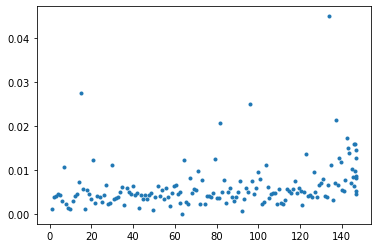

(48000271, 'e-')


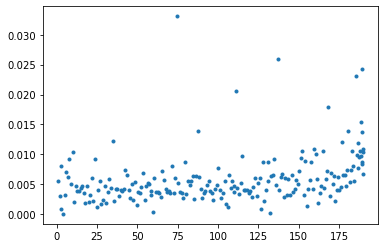

(48000272, 'e+')


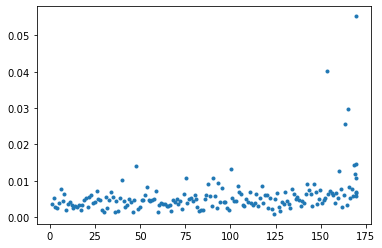

(48000272, 'e-')


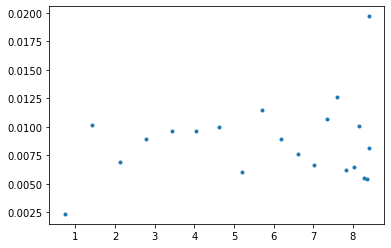

(48000273, 'e-')


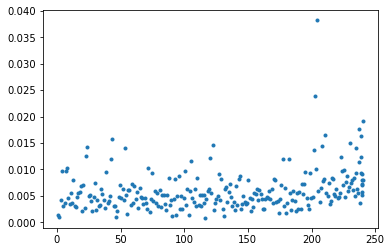

(48000274, 'e-')


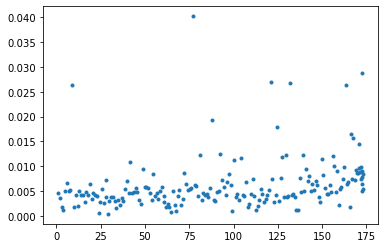

(48000275, 'e+')


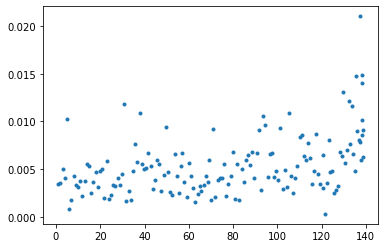

(48000275, 'e-')


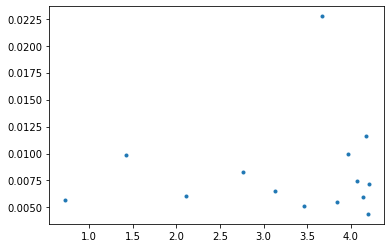

(48000276, 'e-')


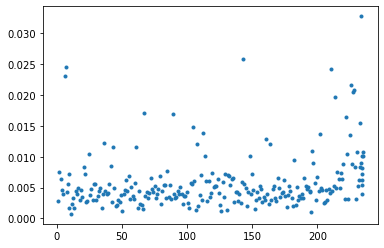

(48000277, 'e-')


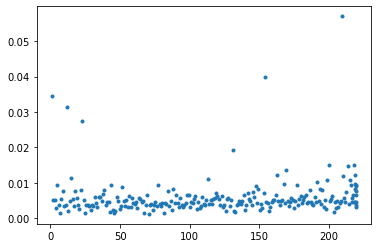

(48000278, 'e-')


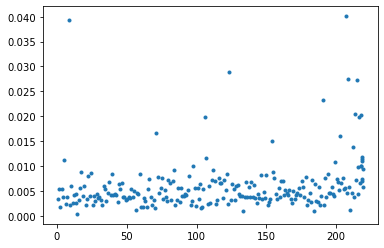

(48000279, 'e+')


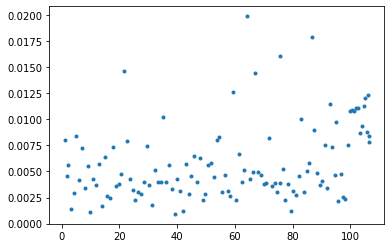

(48000279, 'e-')


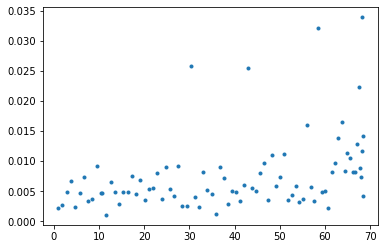

(48000280, 'e-')


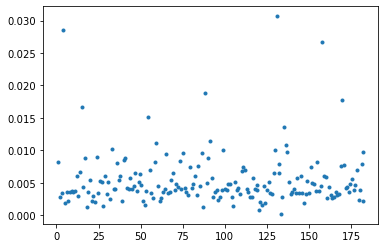

(48000281, 'e-')


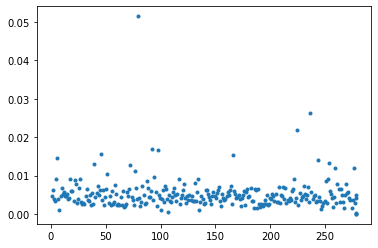

(48000282, 'e-')


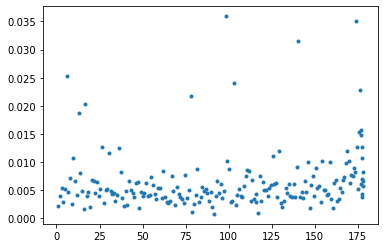

(48000283, 'e-')


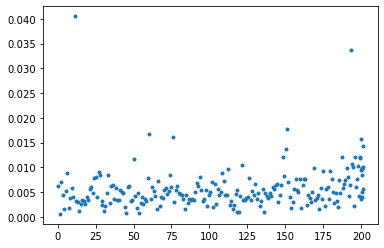

(48000285, 'e-')


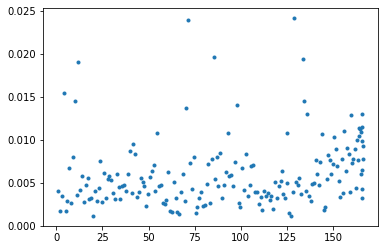

(48000286, 'e-')


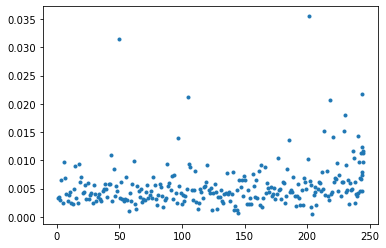

(48000287, 'e-')


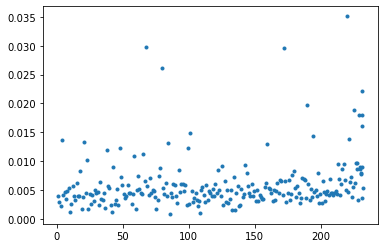

(48000288, 'e-')


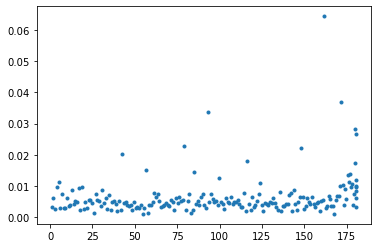

(48000289, 'e+')


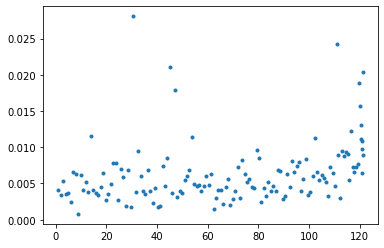

(48000289, 'e-')


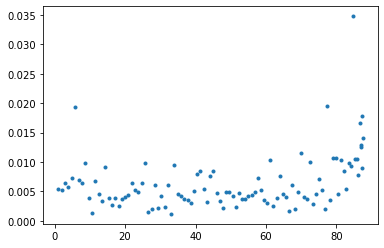

(48000290, 'e-')


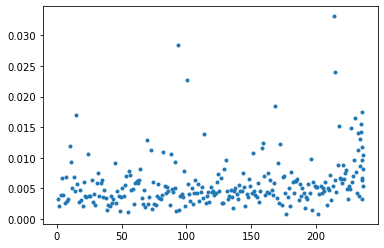

(48000291, 'e-')


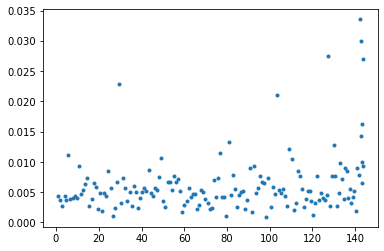

(48000292, 'e-')


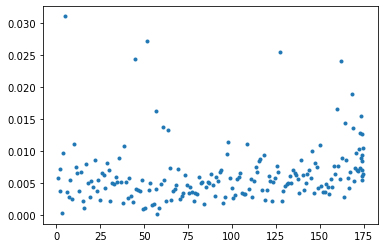

(48000293, 'e-')


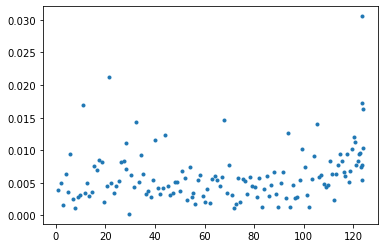

(48000294, 'e+')


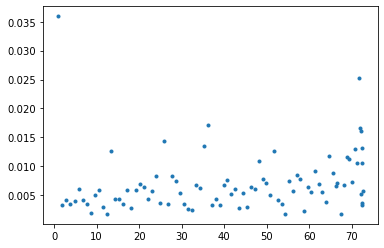

(48000294, 'e-')


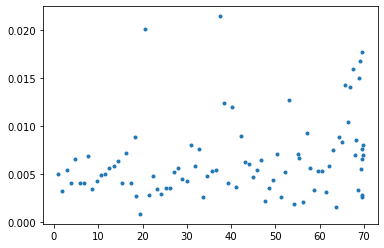

(48000295, 'e-')


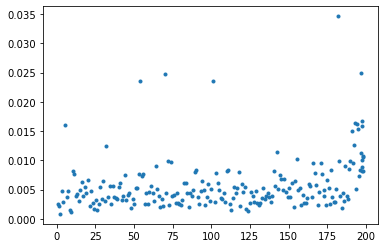

(48000296, 'e-')


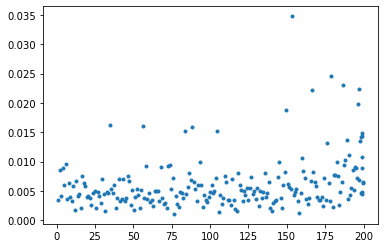

(48000297, 'e+')


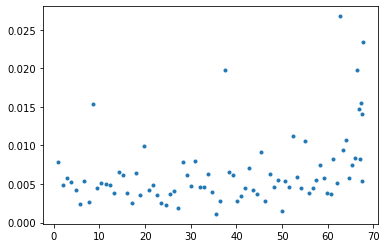

(48000297, 'e-')


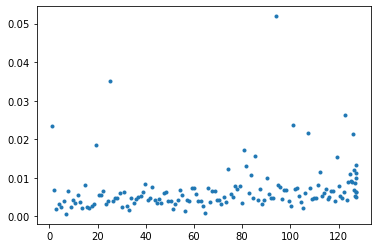

(48000298, 'e-')


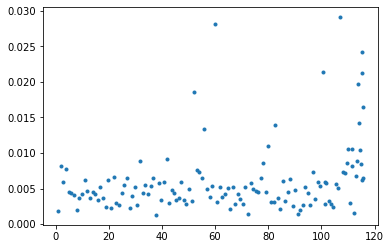

(48000299, 'e-')


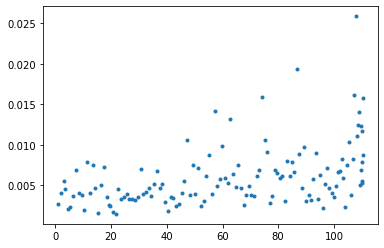

(48000300, 'e+')


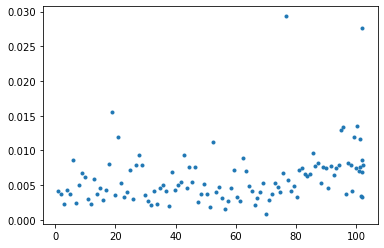

(48000300, 'e-')


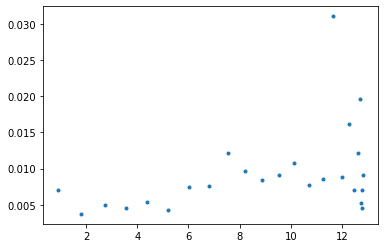

(48000301, 'e-')


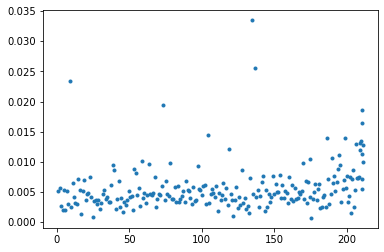

(48000302, 'e-')


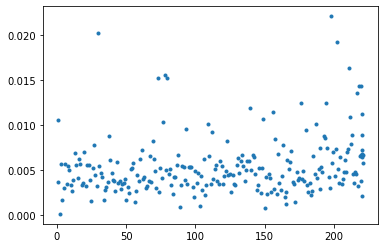

(48000303, 'e-')


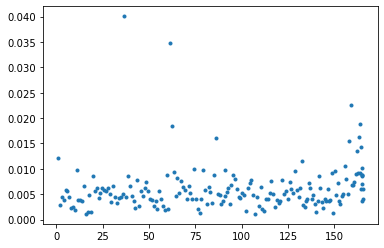

(48000304, 'e+')


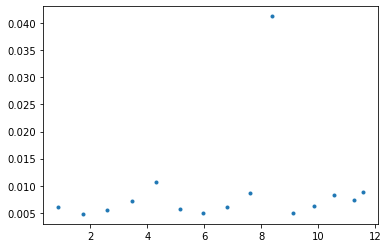

(48000304, 'e-')


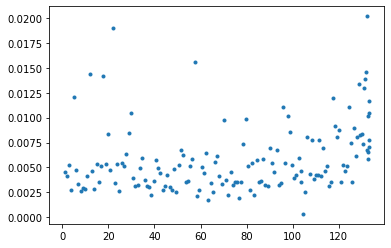

(48000305, 'e-')


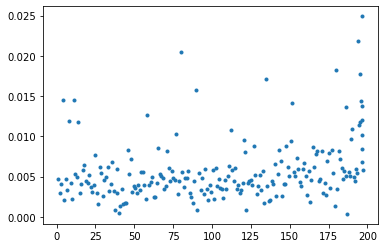

(48000306, 'e-')


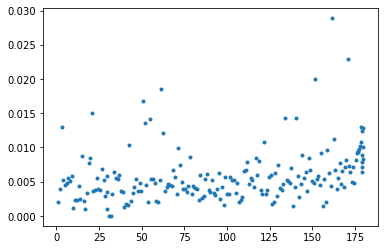

(48000307, 'e-')


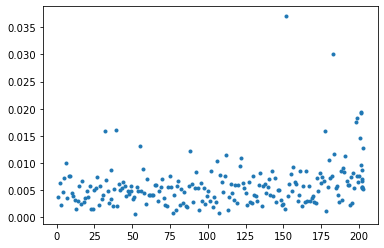

(48000308, 'e-')


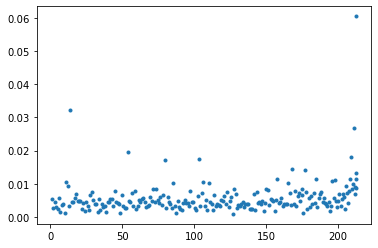

(48000309, 'e-')


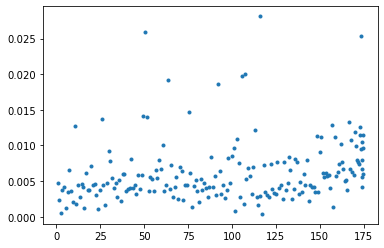

(48000310, 'e-')


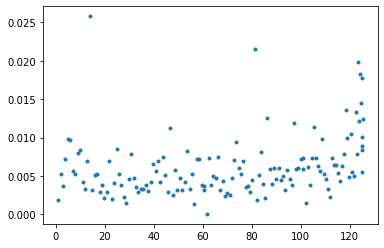

(48000311, 'e+')


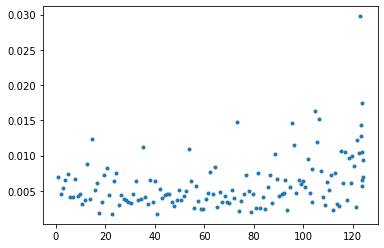

(48000311, 'e-')


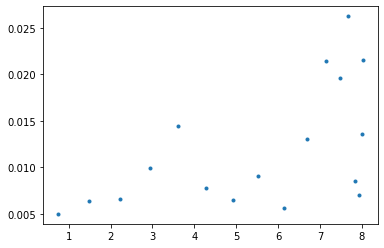

(48000312, 'e-')


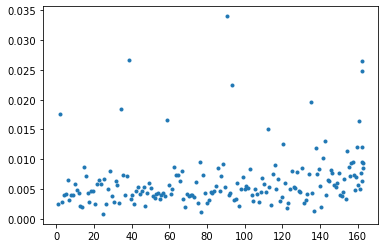

(48000313, 'e-')


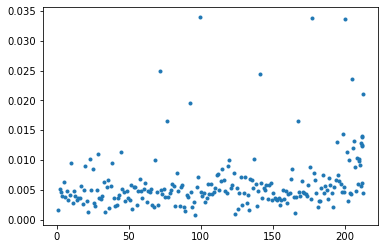

(48000314, 'e-')


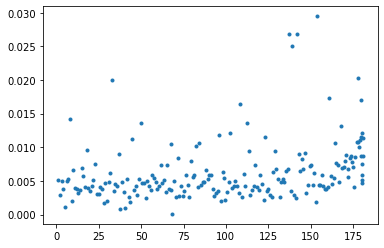

(48000315, 'e-')


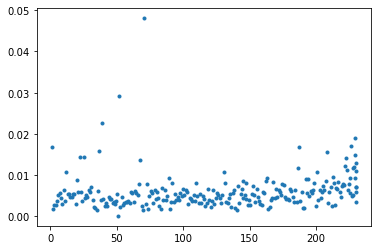

(48000316, 'e-')


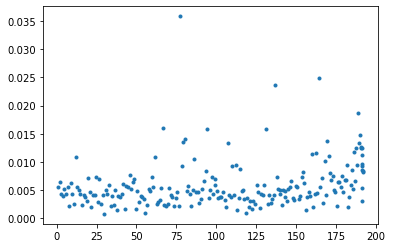

(48000317, 'e-')


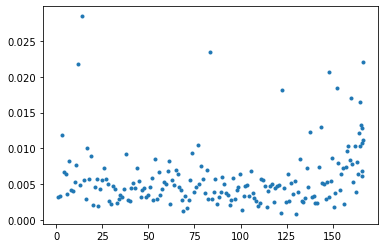

(48000318, 'e+')


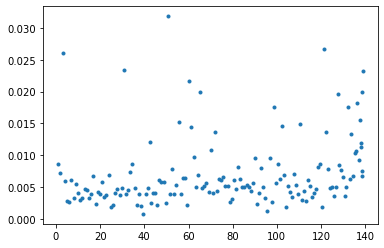

(48000318, 'e-')


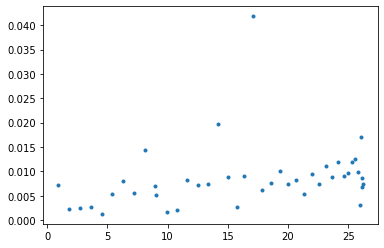

(48000319, 'e-')


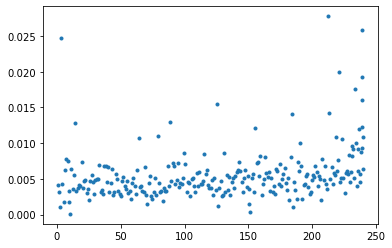

(48000320, 'e-')


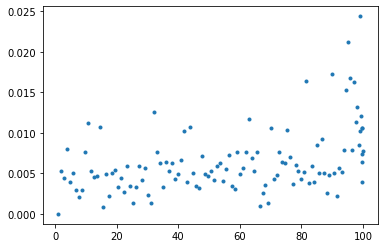

(48000321, 'e-')


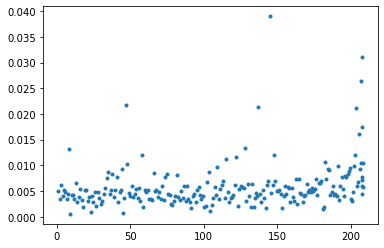

(48000322, 'e+')


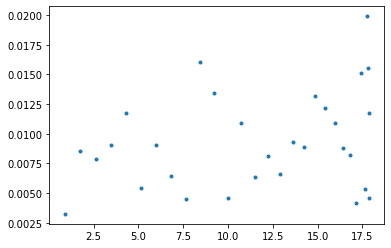

(48000322, 'e-')


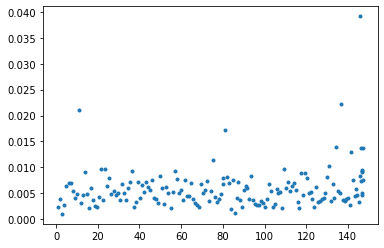

(48000323, 'e-')


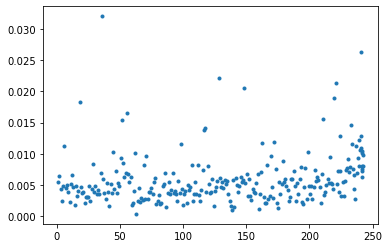

(48000324, 'e-')


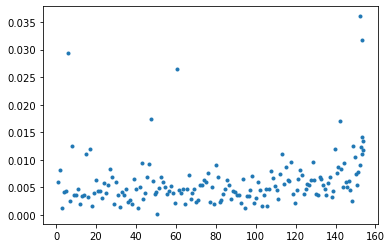

(48000325, 'e+')


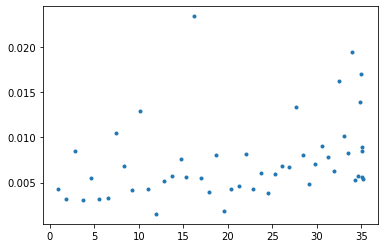

(48000325, 'e-')


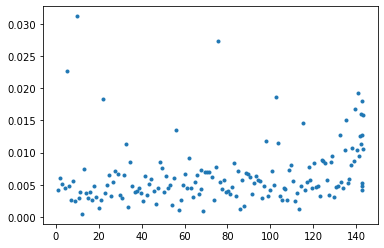

(48000326, 'e-')


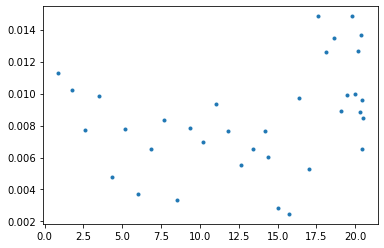

(48000327, 'e-')


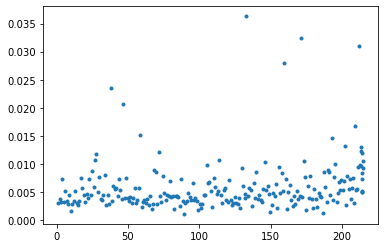

(48000328, 'e-')


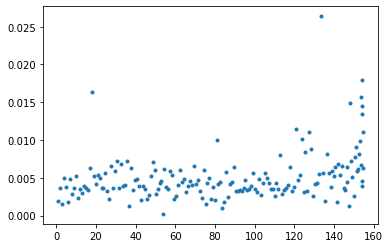

(48000329, 'e+')


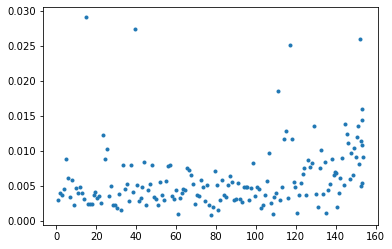

(48000329, 'e-')


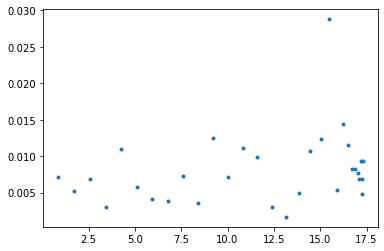

(48000331, 'e+')


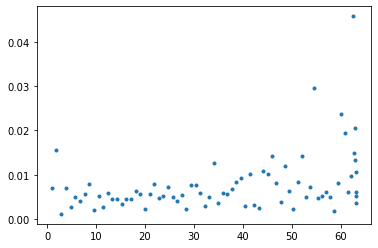

(48000331, 'e-')


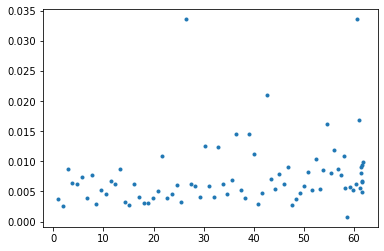

(48000332, 'e-')


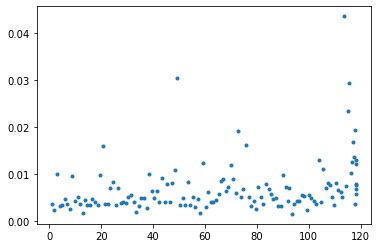

(48000333, 'e-')


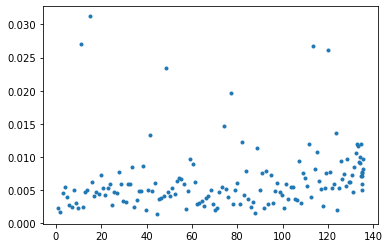

(48000334, 'e-')


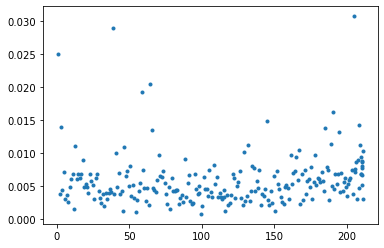

(48000335, 'e-')


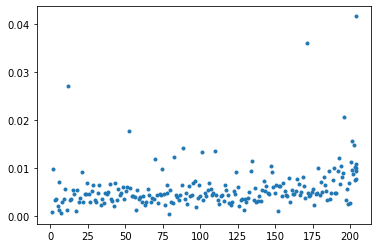

(48000336, 'e-')


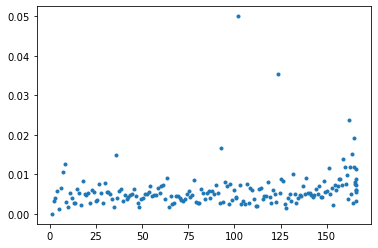

(48000337, 'e-')


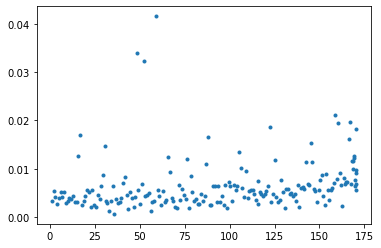

(48000338, 'e-')


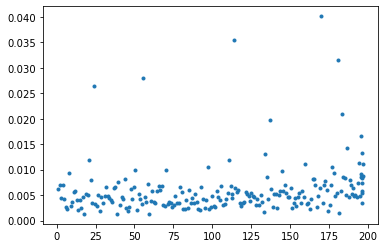

(48000339, 'e-')


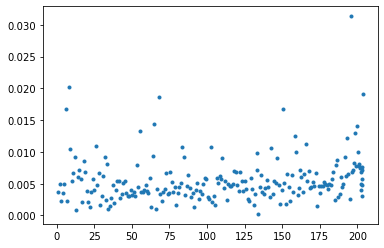

(48000340, 'e-')


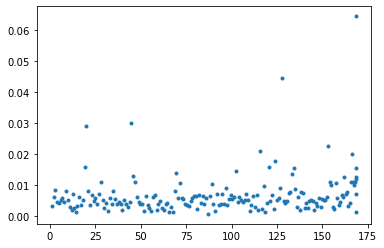

(48000341, 'e+')


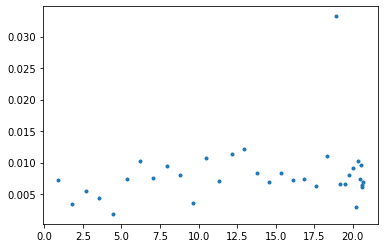

(48000341, 'e-')


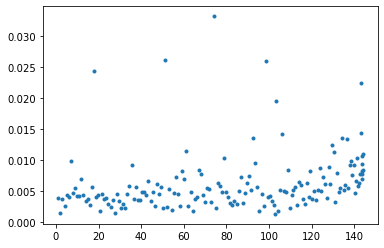

(48000342, 'e-')


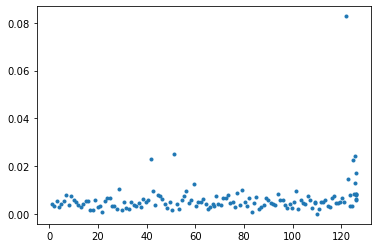

(48000343, 'e-')


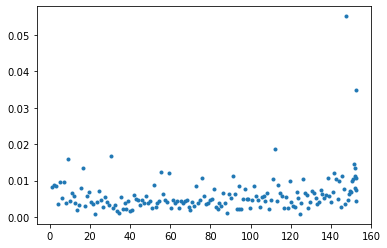

(48000344, 'e+')


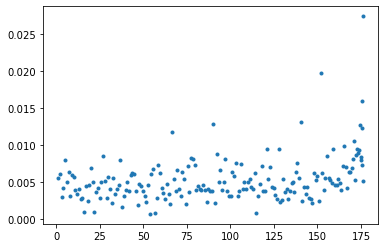

(48000344, 'e-')


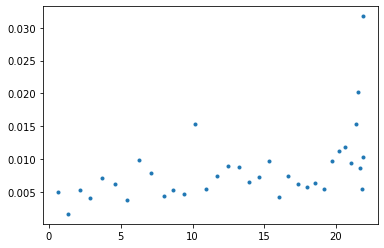

(48000345, 'e-')


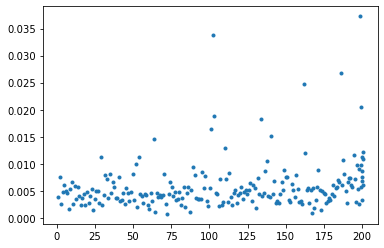

(48000347, 'e-')


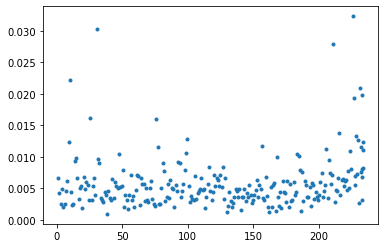

(48000348, 'e-')


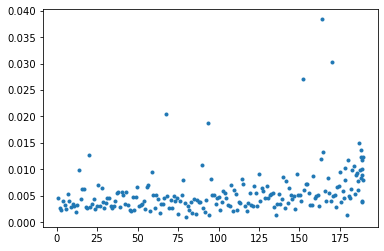

(48000349, 'e-')


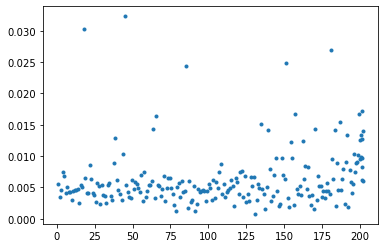

(48000350, 'e-')


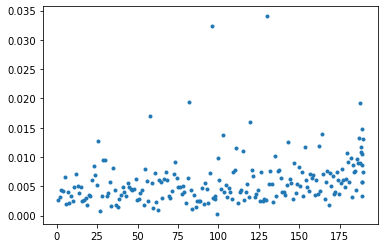

(48000351, 'e+')


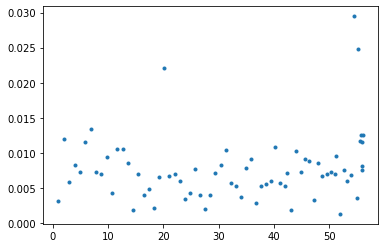

(48000351, 'e-')


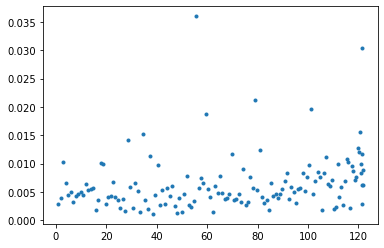

(48000352, 'e-')


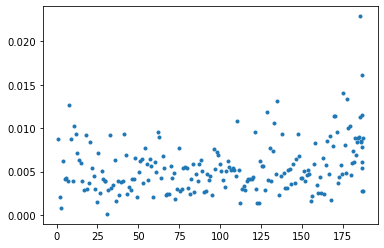

(48000353, 'e-')


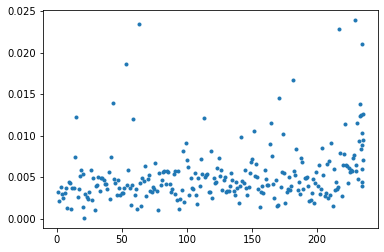

(48000354, 'e-')


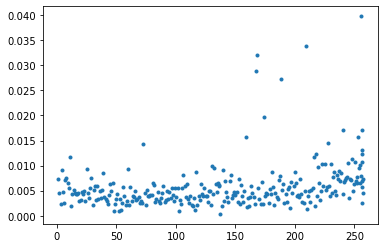

(48000355, 'e-')


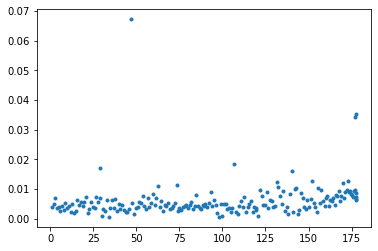

(48000356, 'e-')


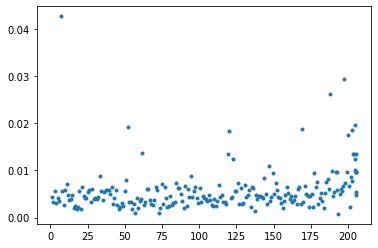

(48000357, 'e+')


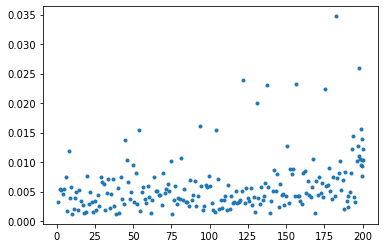

(48000357, 'e-')


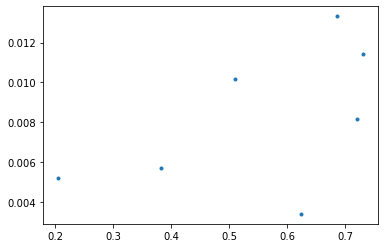

(48000358, 'e-')


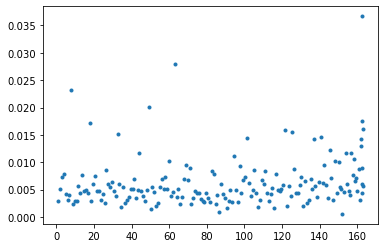

(48000359, 'e-')


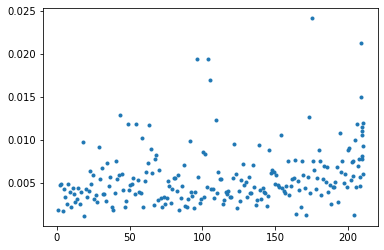

(48000360, 'e+')


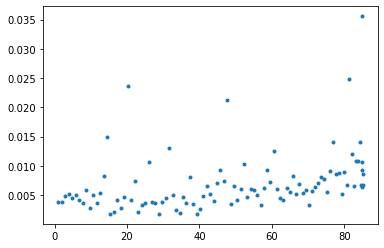

(48000360, 'e-')


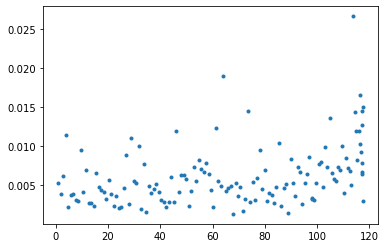

(48000361, 'e-')


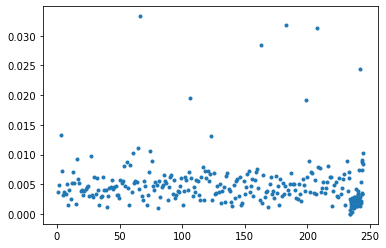

(48000362, 'e-')


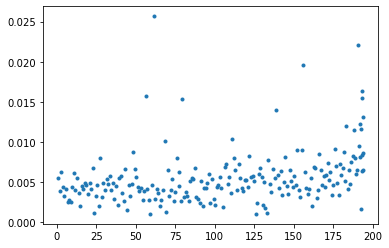

(48000363, 'e+')


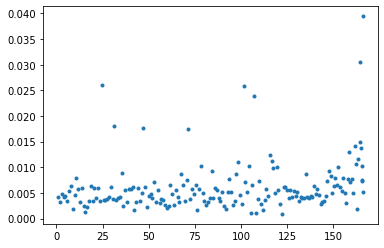

(48000363, 'e-')


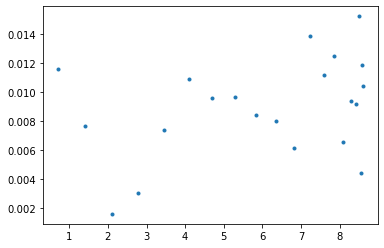

(48000364, 'e-')


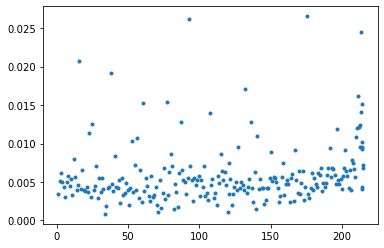

(48000365, 'e-')


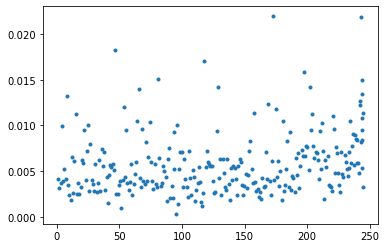

(48000366, 'e-')


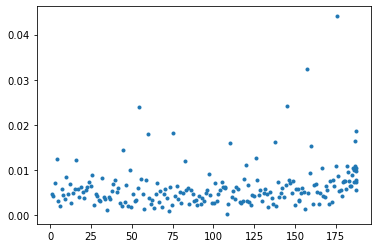

(48000367, 'e-')


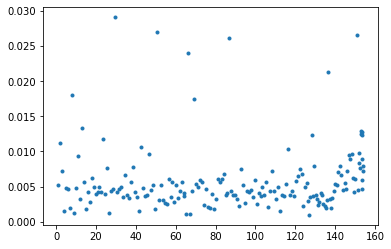

(48000368, 'e-')


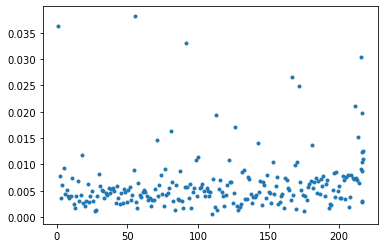

(48000369, 'e-')


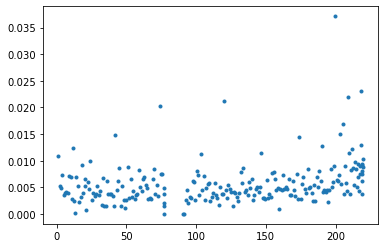

(48000370, 'e+')


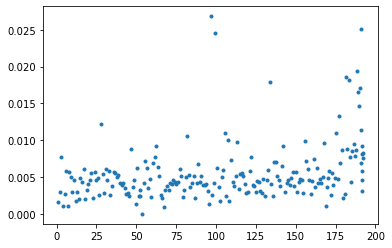

(48000370, 'e-')


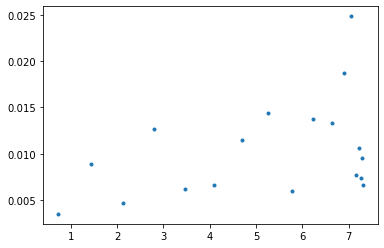

(48000371, 'e+')


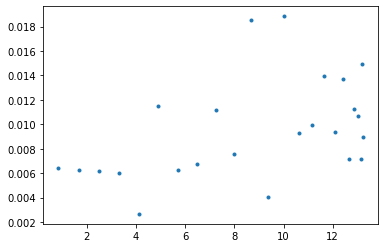

(48000371, 'e-')


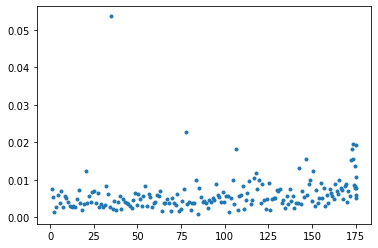

(48000372, 'e-')


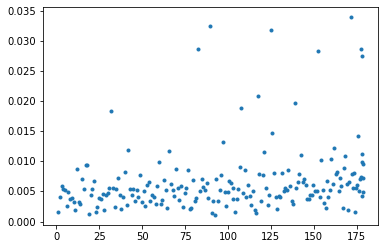

(48000373, 'e-')


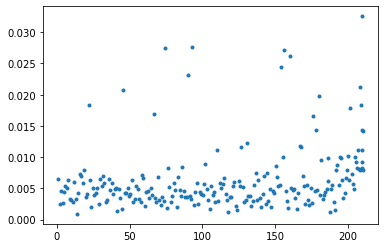

(48000374, 'e-')


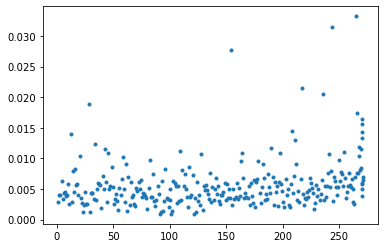

(48000375, 'e+')


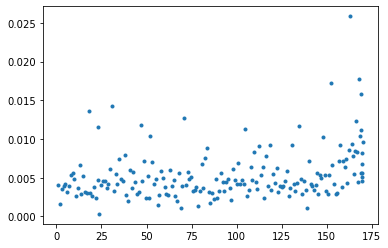

(48000375, 'e-')


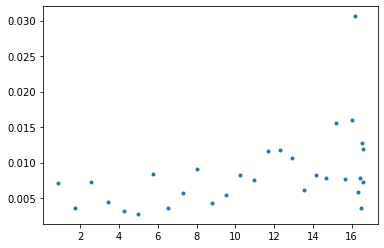

(48000376, 'e+')


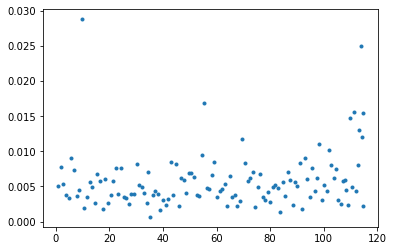

(48000376, 'e-')


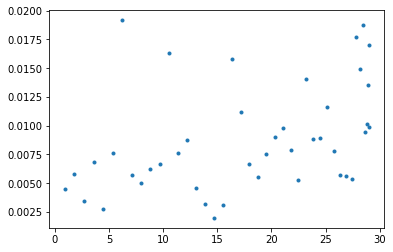

(48000377, 'e-')


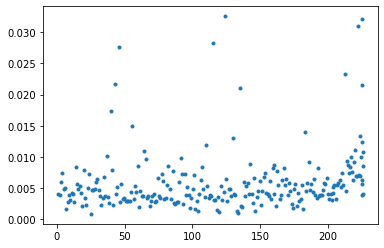

(48000378, 'e-')


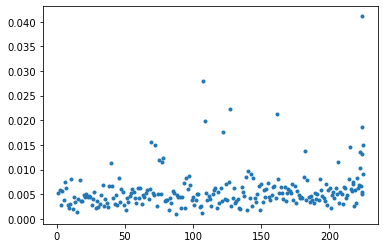

(48000379, 'e+')


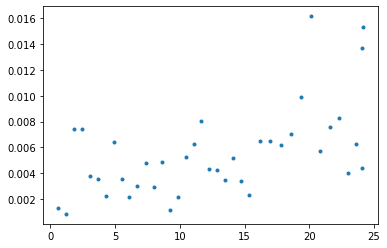

(48000379, 'e-')


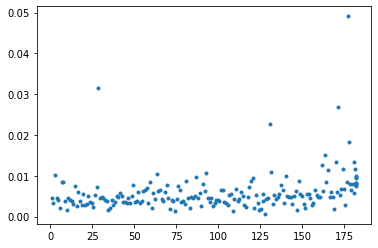

(48000381, 'e-')


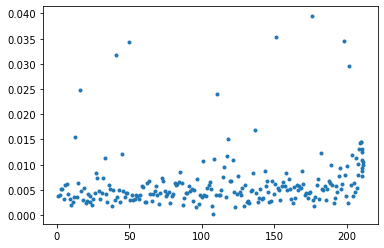

(48000382, 'e-')


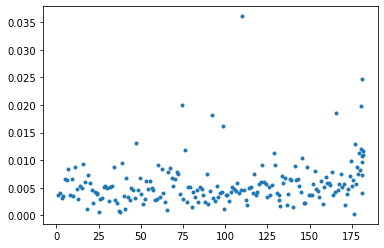

(48000383, 'e-')


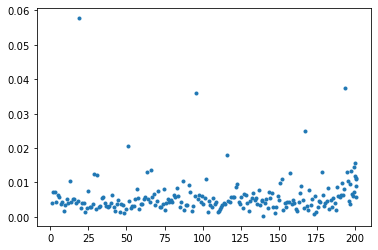

(48000384, 'e-')


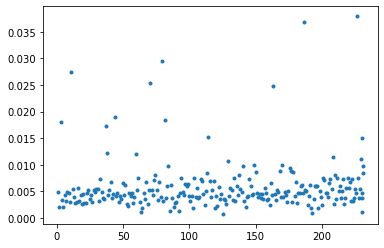

(48000385, 'e-')


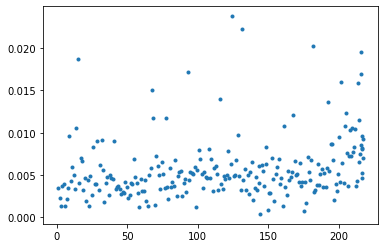

(48000386, 'e-')


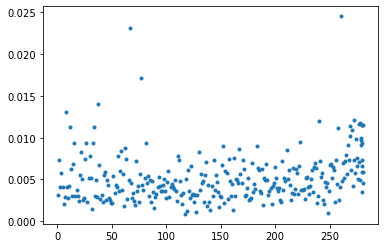

(48000387, 'e-')


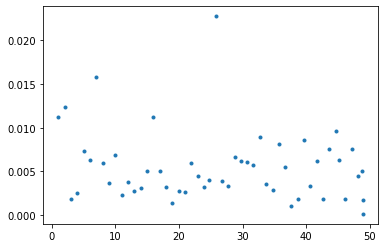

(48000388, 'e+')


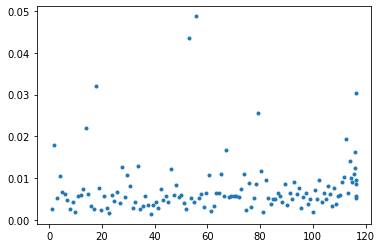

(48000388, 'e-')


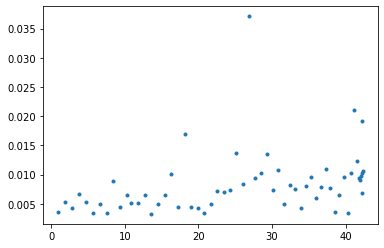

(48000389, 'e-')


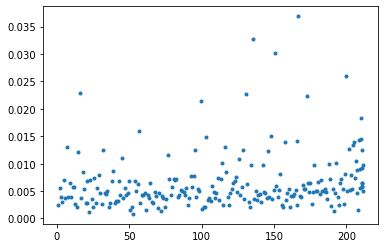

(48000390, 'e-')


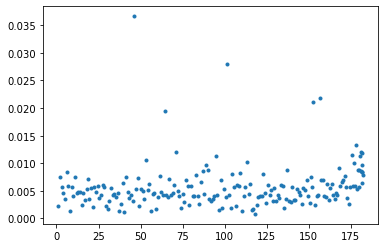

(48000391, 'e-')


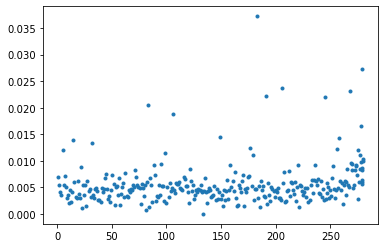

(48000392, 'e+')


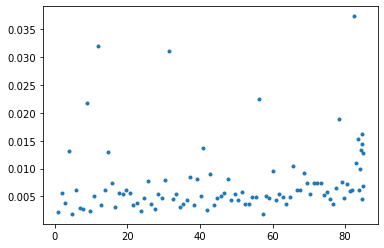

(48000392, 'e-')


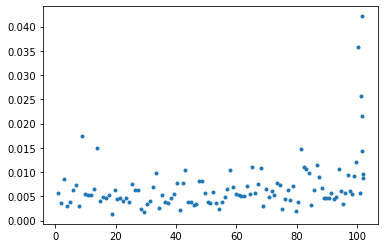

(48000393, 'e-')


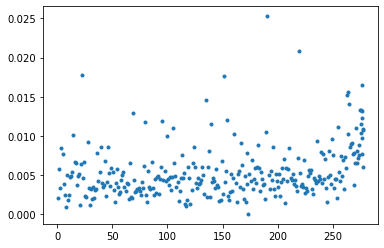

(48000394, 'e-')


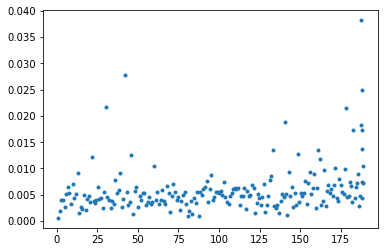

(48000395, 'e-')


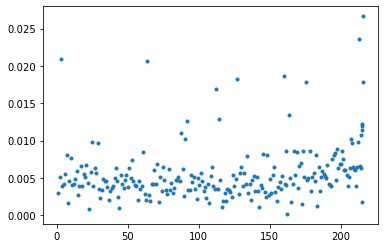

(48000396, 'e+')


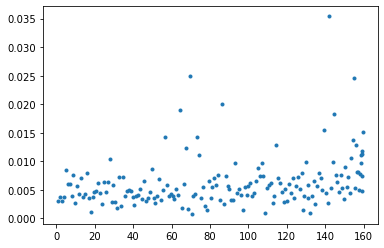

(48000396, 'e-')


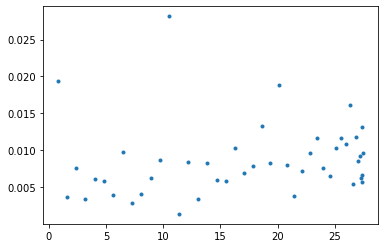

(48000397, 'e+')


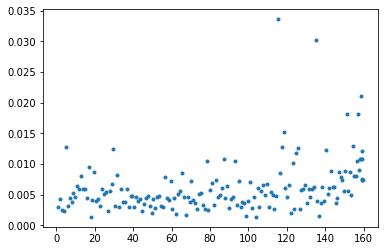

(48000397, 'e-')


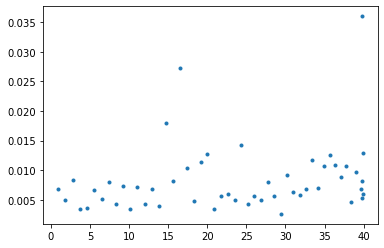

(48000398, 'e-')


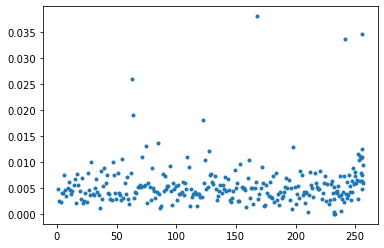

(48000399, 'e-')


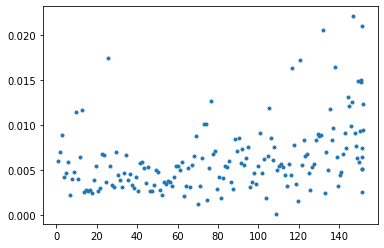

(48000400, 'e-')


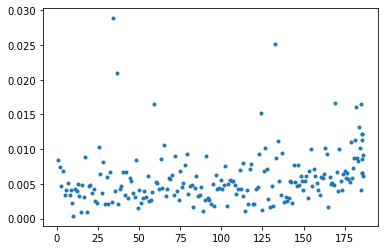

(48000401, 'e+')


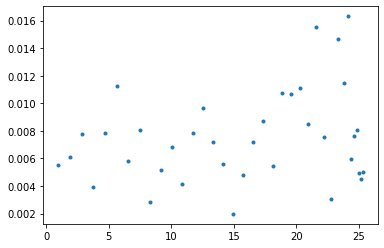

(48000401, 'e-')


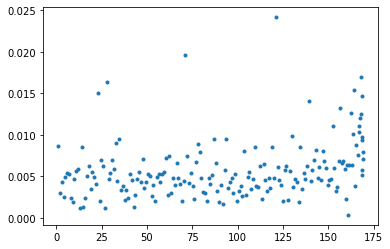

(48000402, 'e-')


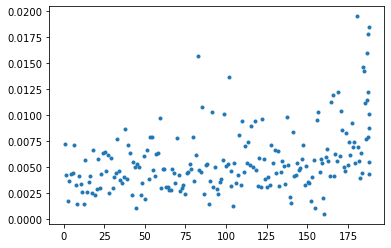

(48000403, 'e+')


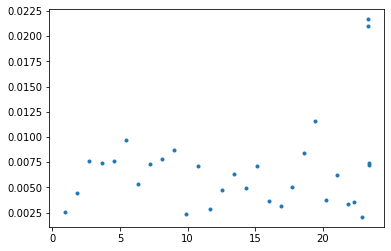

(48000403, 'e-')


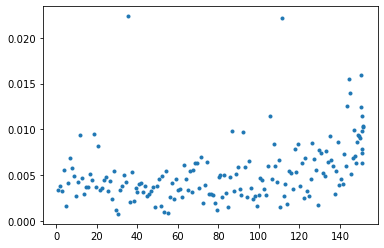

(48000404, 'e+')


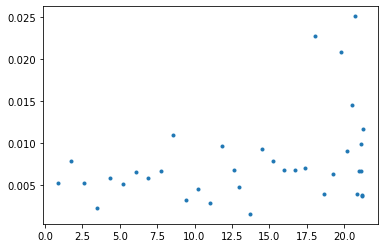

(48000404, 'e-')


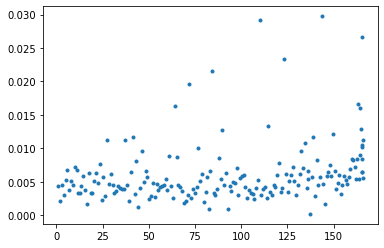

(48000405, 'e+')


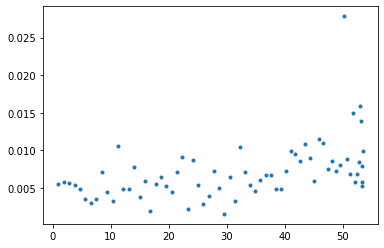

(48000405, 'e-')


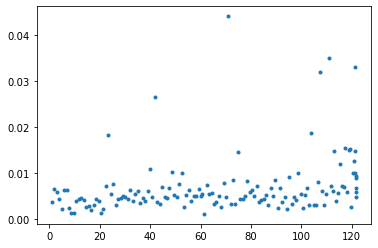

(48000406, 'e+')


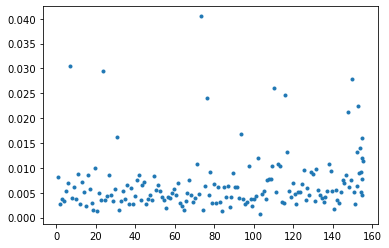

(48000406, 'e-')


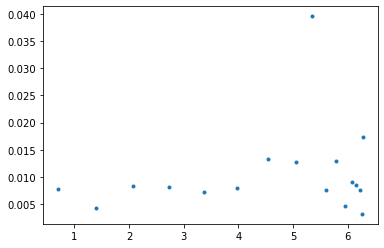

(48000407, 'e-')


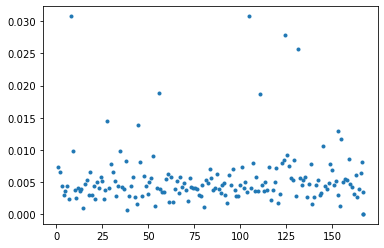

(48000408, 'e-')


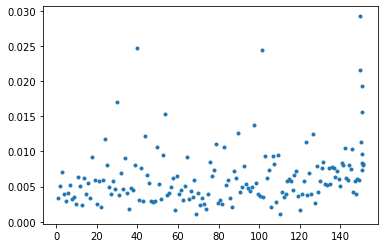

(48000409, 'e+')


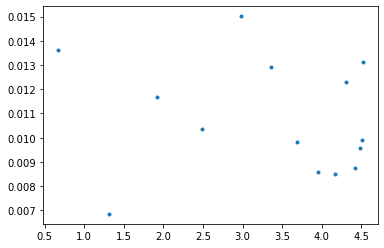

(48000409, 'e-')


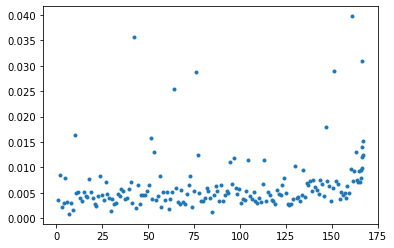

(48000410, 'e-')


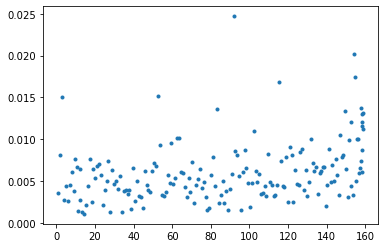

(48000411, 'e-')


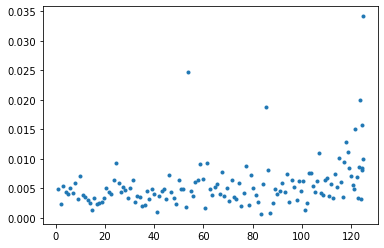

(48000412, 'e-')


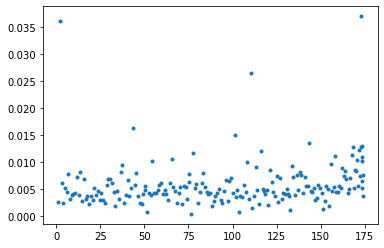

(48000413, 'e-')


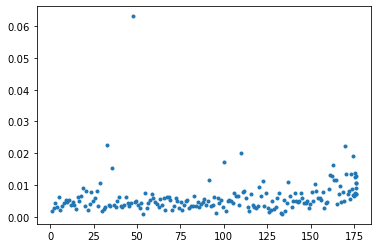

(48000414, 'e-')


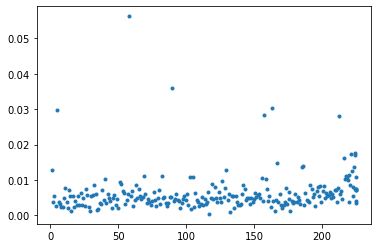

(48000415, 'e-')


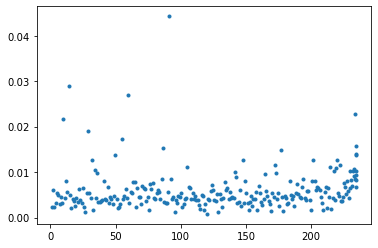

(48000416, 'e+')


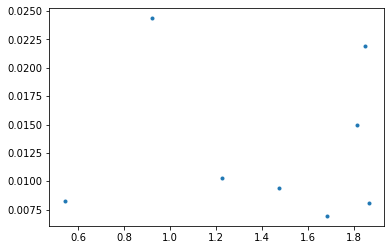

(48000416, 'e-')


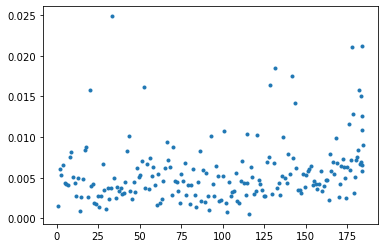

(48000417, 'e-')


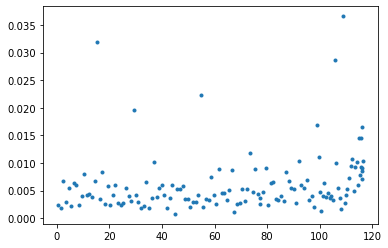

(48000418, 'e-')


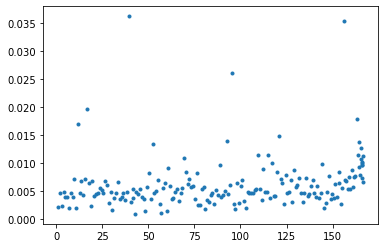

(48000419, 'e-')


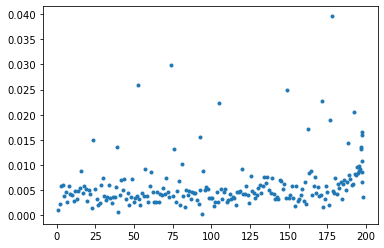

(48000420, 'e-')


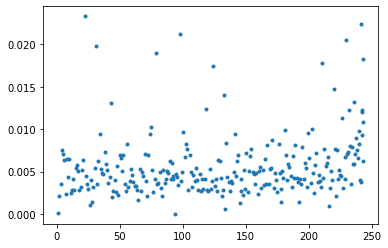

(48000421, 'e-')


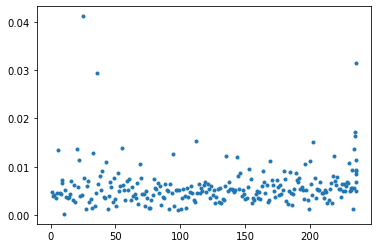

(48000422, 'e-')


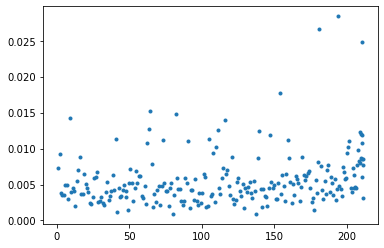

(48000423, 'e-')


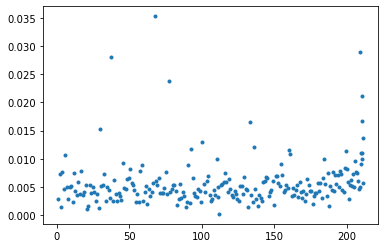

(48000424, 'e-')


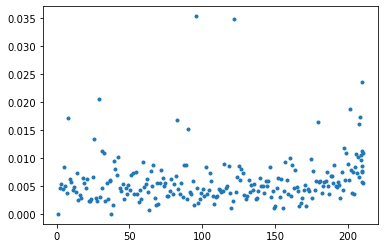

(48000425, 'e-')


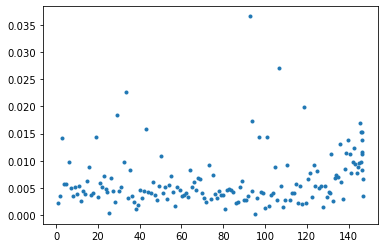

(48000426, 'e+')


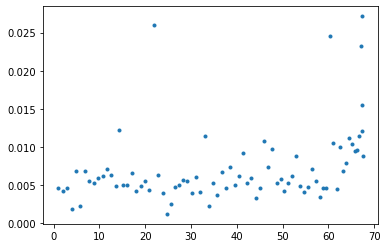

(48000426, 'e-')


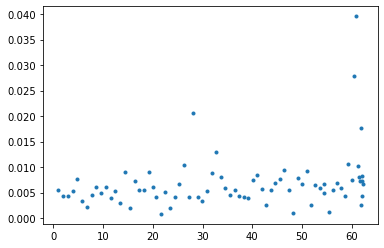

(48000427, 'e-')


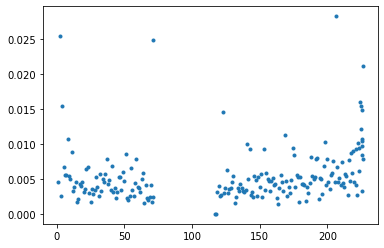

(48000428, 'e-')


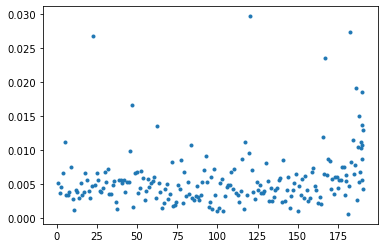

(48000429, 'e-')


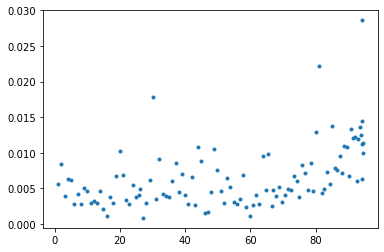

(48000430, 'e-')


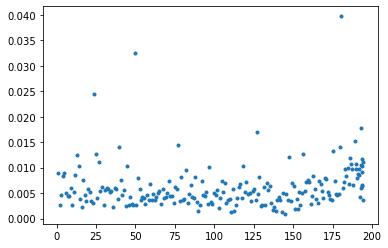

(48000431, 'e-')


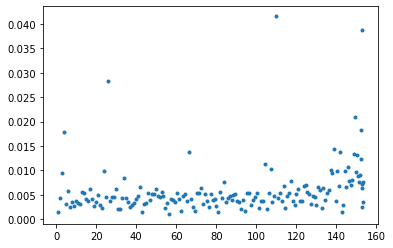

(48000432, 'e-')


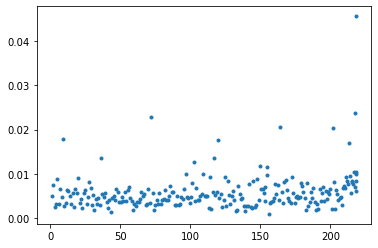

(48000433, 'e+')


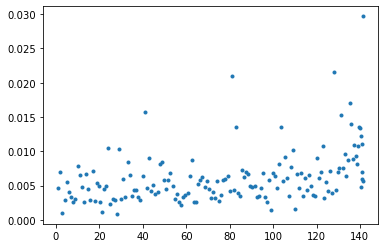

(48000433, 'e-')


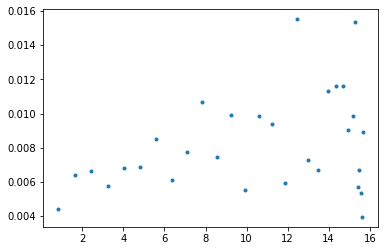

(48000434, 'e-')


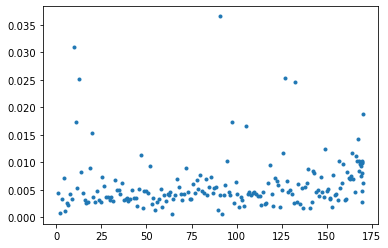

(48000435, 'e-')


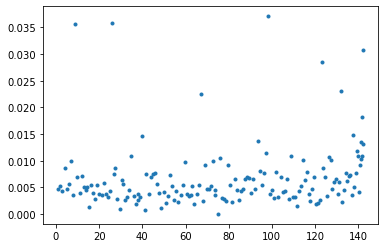

(48000436, 'e-')


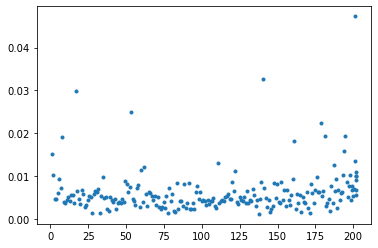

(48000437, 'e-')


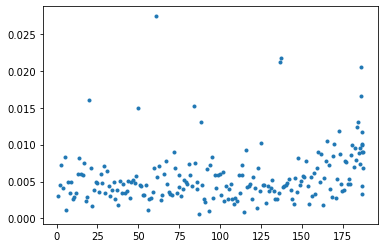

(48000439, 'e-')


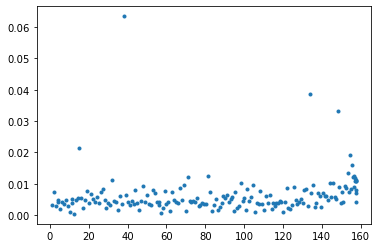

(48000440, 'e-')


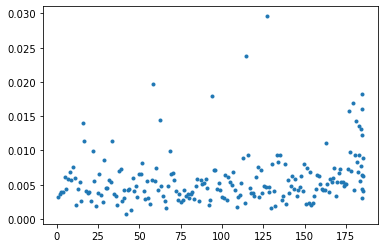

(48000441, 'e-')


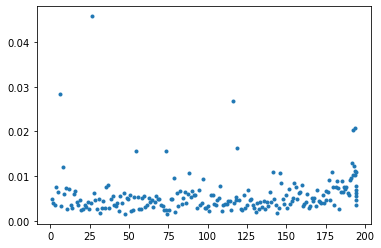

(48000442, 'e-')


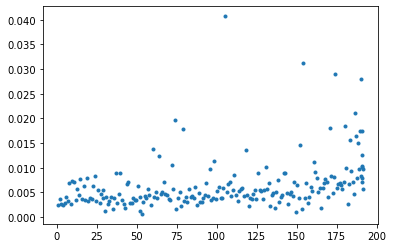

(48000443, 'e+')


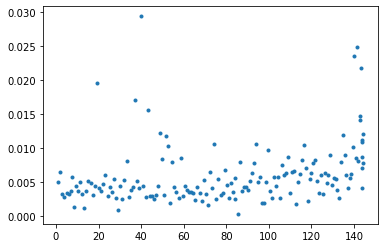

(48000443, 'e-')


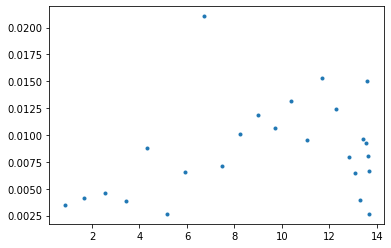

(48000444, 'e+')


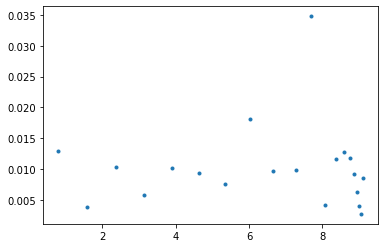

(48000444, 'e-')


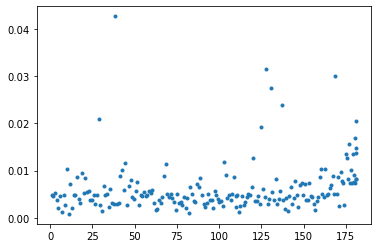

(48000445, 'e-')


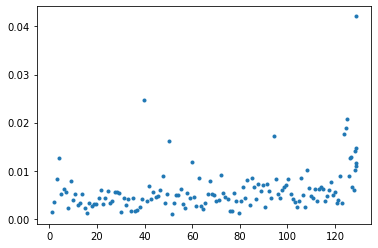

(48000446, 'e-')


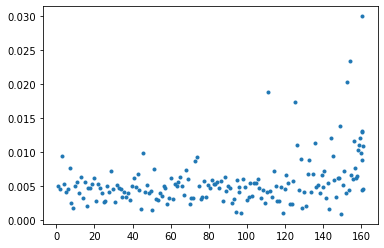

(48000447, 'e-')


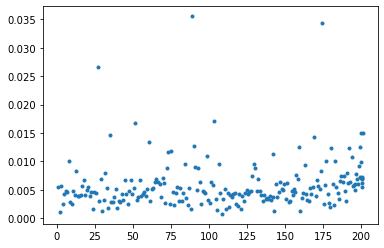

(48000448, 'e-')


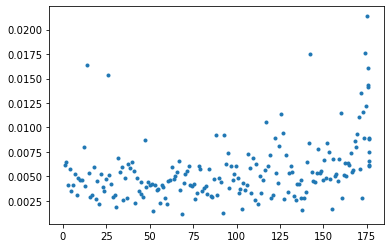

(48000449, 'e-')


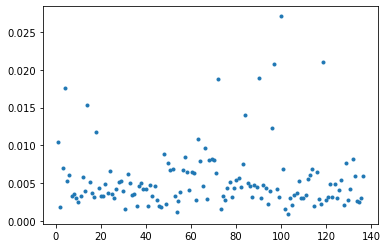

(48000450, 'e+')


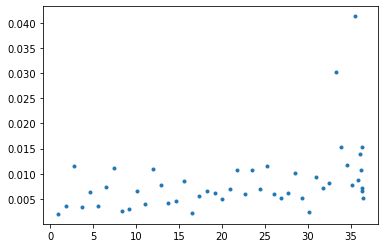

(48000450, 'e-')


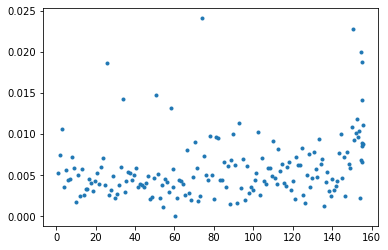

(48000451, 'e+')


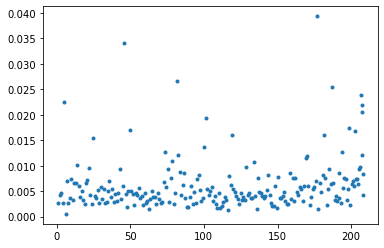

(48000451, 'e-')


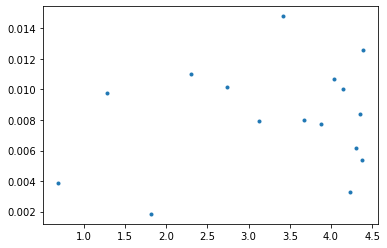

(48000452, 'e-')


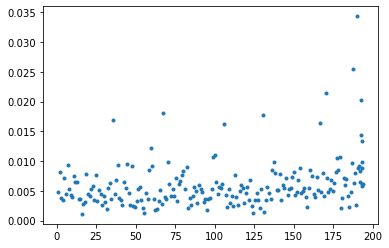

(48000453, 'e+')


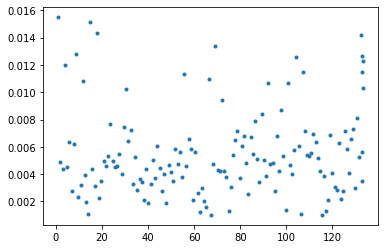

(48000453, 'e-')


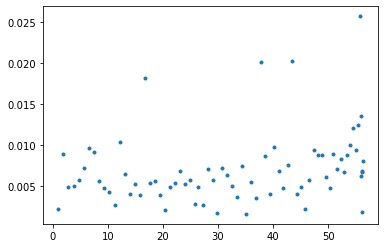

(48000454, 'e+')


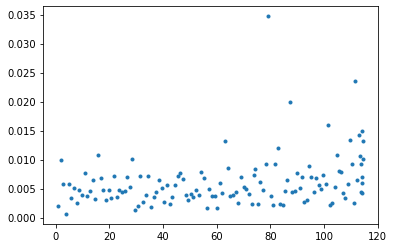

(48000454, 'e-')


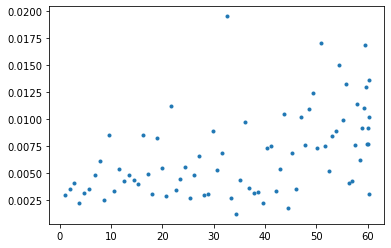

(48000455, 'e+')


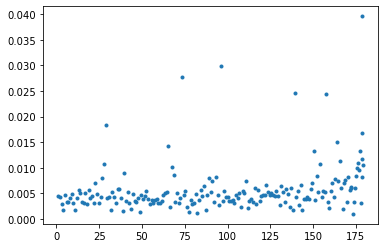

(48000455, 'e-')


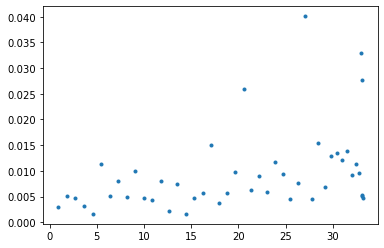

(48000457, 'e-')


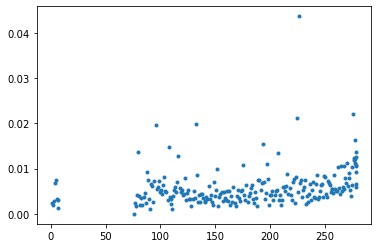

(48000458, 'e-')


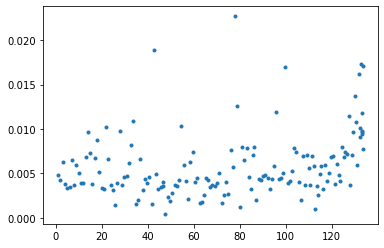

(48000459, 'e-')


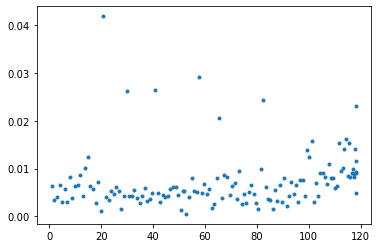

(48000460, 'e+')


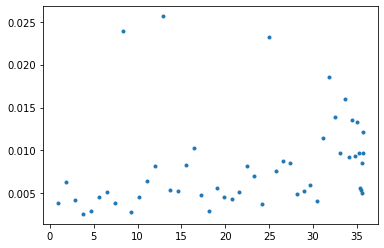

(48000460, 'e-')


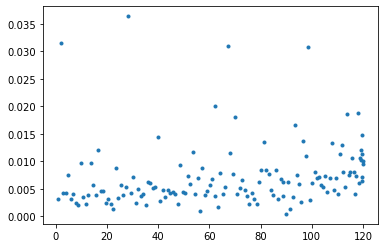

(48000461, 'e-')


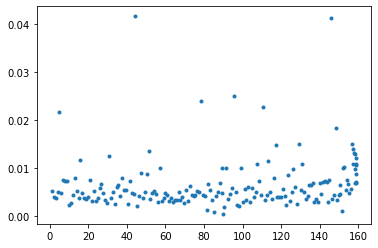

(48000462, 'e+')


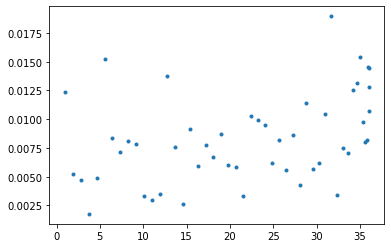

(48000462, 'e-')


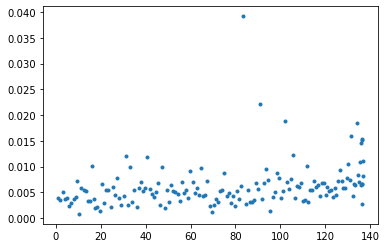

(48000464, 'e+')


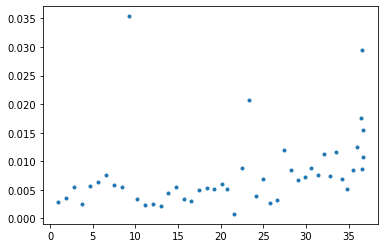

(48000464, 'e-')


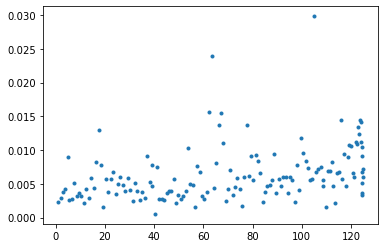

(48000465, 'e-')


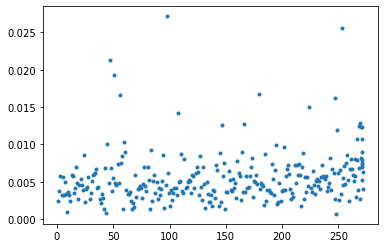

(48000466, 'e-')


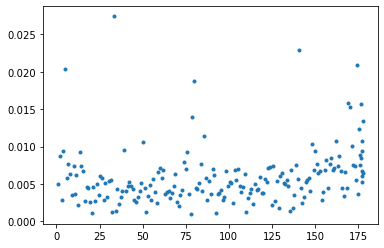

(48000467, 'e-')


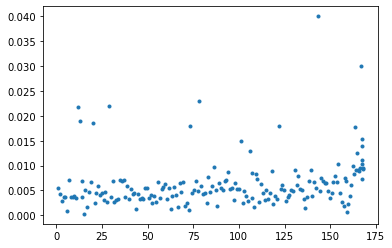

(48000468, 'e-')


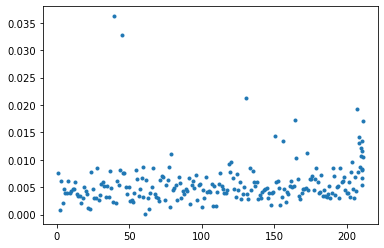

(48000469, 'e+')


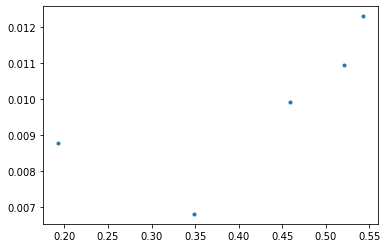

(48000469, 'e-')


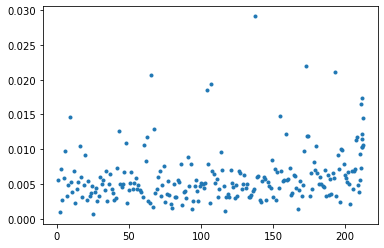

(48000470, 'e+')


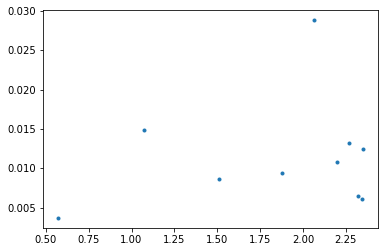

(48000470, 'e-')


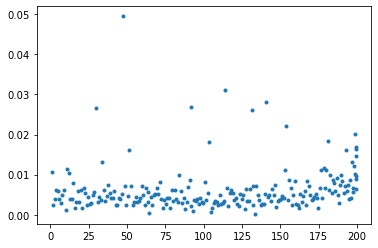

(48000471, 'e+')


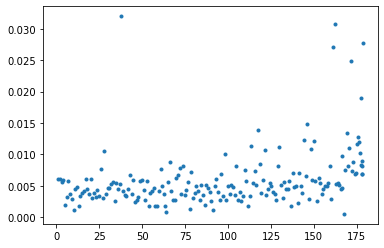

(48000471, 'e-')


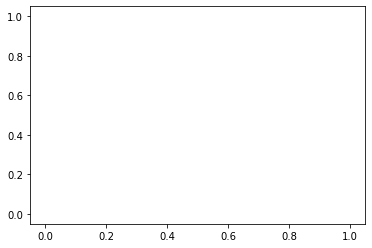

(48000472, 'e+')


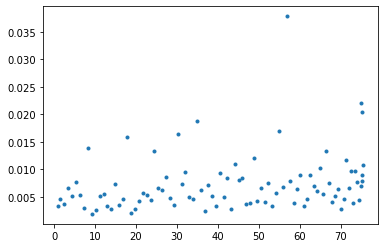

(48000472, 'e-')


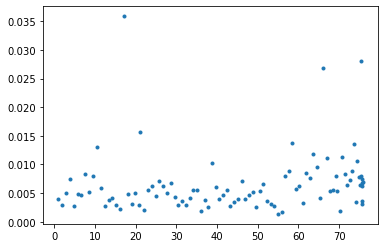

(48000473, 'e-')


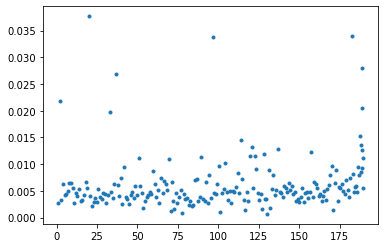

(48000474, 'e+')


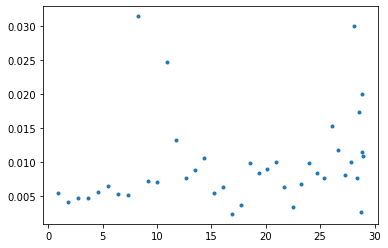

(48000474, 'e-')


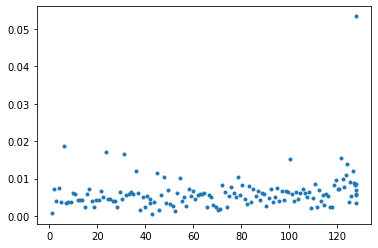

(48000475, 'e-')


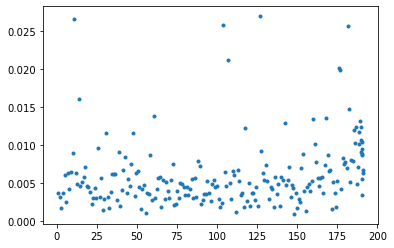

(48000476, 'e-')


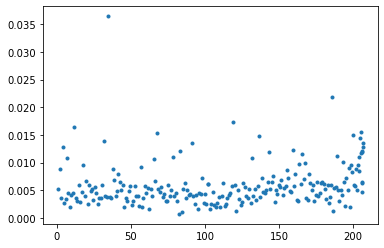

(48000477, 'e+')


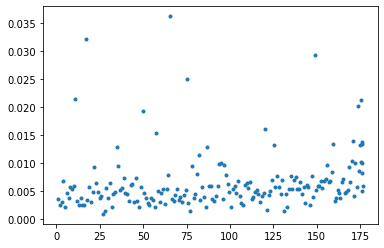

(48000477, 'e-')


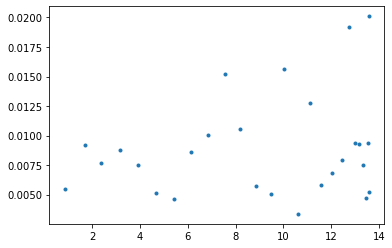

(48000478, 'e-')


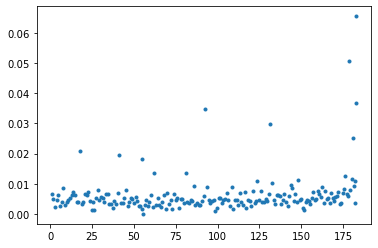

(48000479, 'e-')


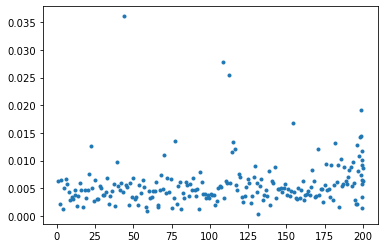

(48000480, 'e-')


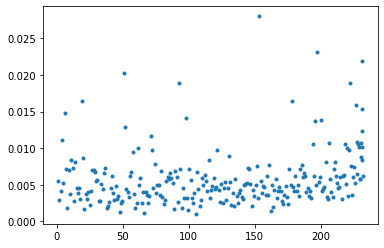

(48000481, 'e-')


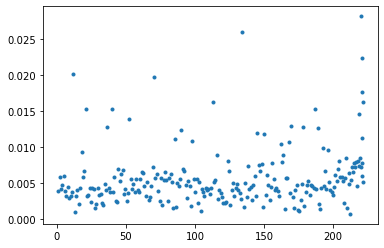

(48000482, 'e+')


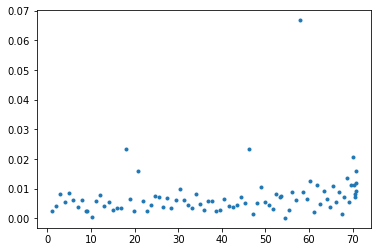

(48000482, 'e-')


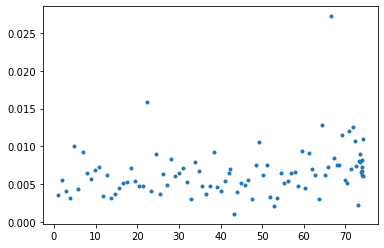

(48000483, 'e+')


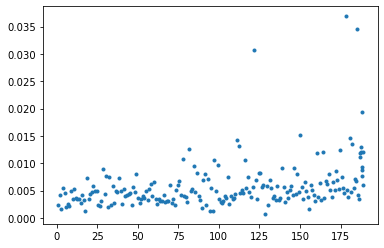

(48000483, 'e-')


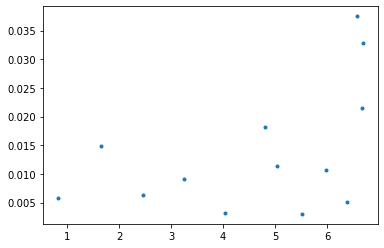

(48000484, 'e-')


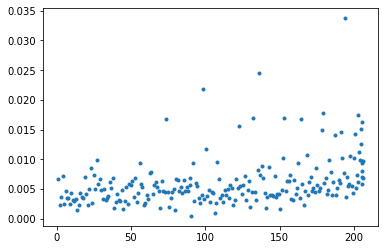

(48000485, 'e-')


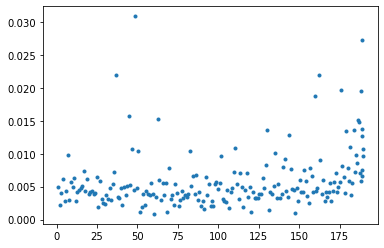

(48000486, 'e-')


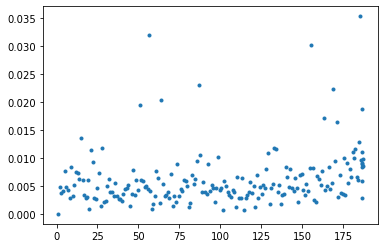

(48000487, 'e-')


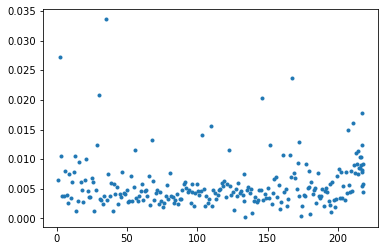

(48000488, 'e-')


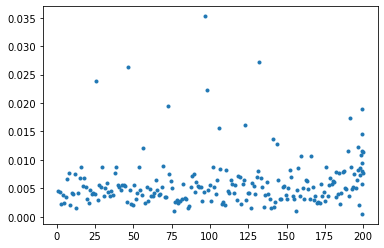

(48000489, 'e+')


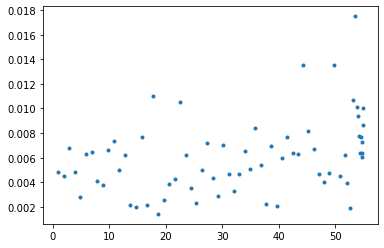

(48000489, 'e-')


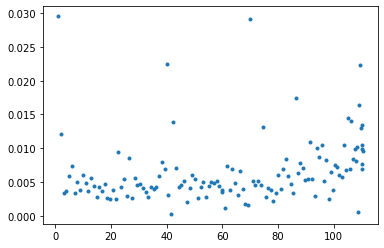

(48000490, 'e-')


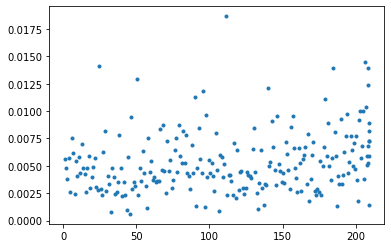

(48000491, 'e-')


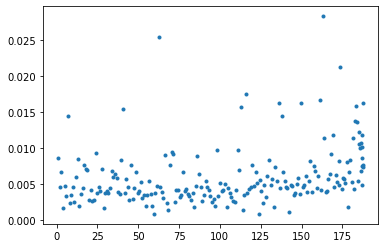

(48000492, 'e-')


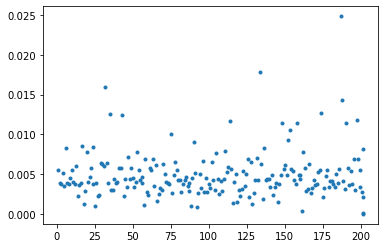

(48000493, 'e-')


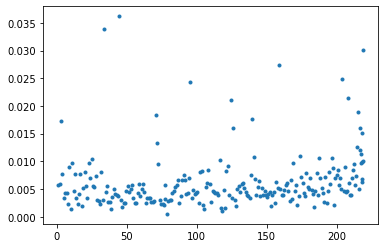

(48000494, 'e+')


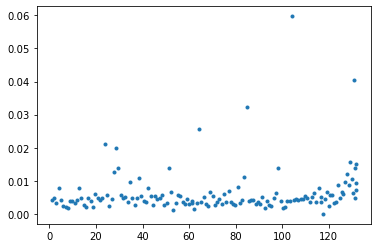

(48000494, 'e-')


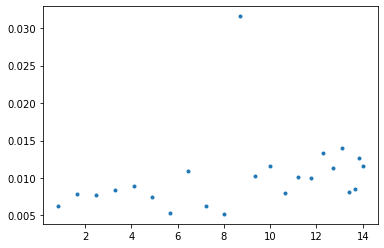

(48000495, 'e-')


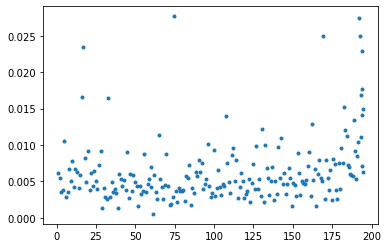

(48000496, 'e-')


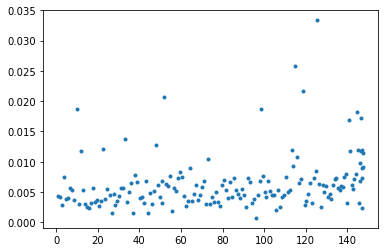

(48000497, 'e-')


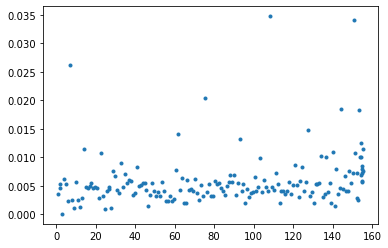

(48000498, 'e-')


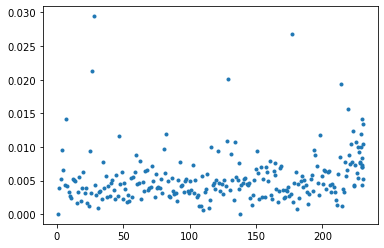

(48000499, 'e-')


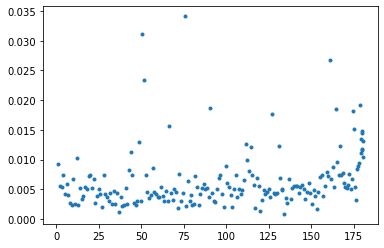

(48000500, 'e-')


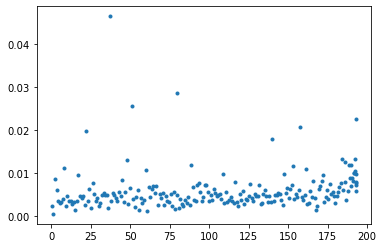

(48000501, 'e+')


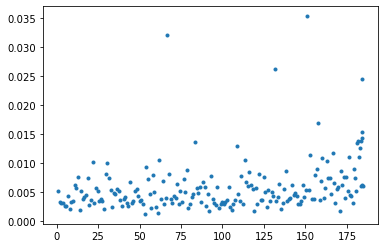

(48000501, 'e-')


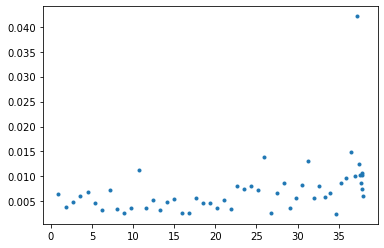

(48000502, 'e-')


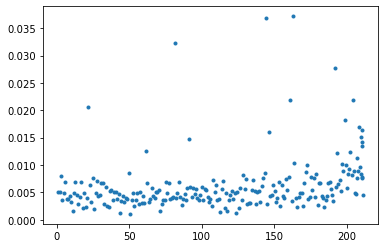

(48000503, 'e-')


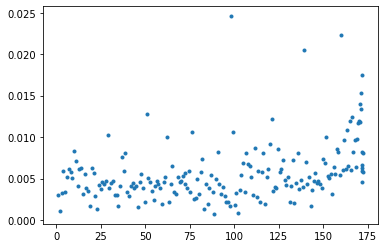

(48000504, 'e-')


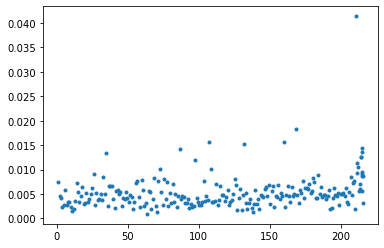

(48000505, 'e-')


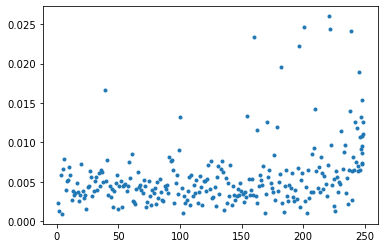

(48000506, 'e-')


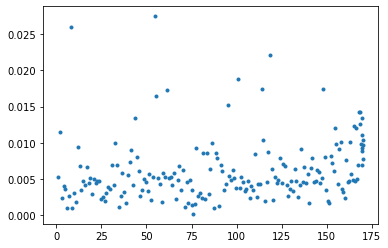

(48000507, 'e-')


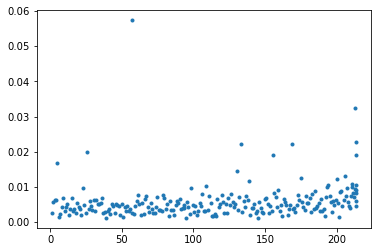

(48000508, 'e+')


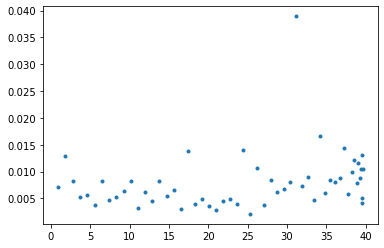

(48000508, 'e-')


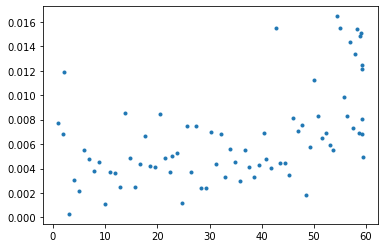

(48000509, 'e+')


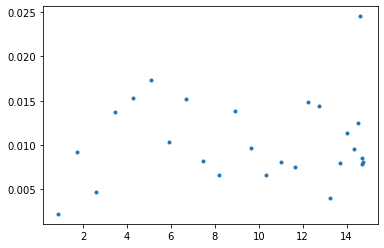

(48000509, 'e-')


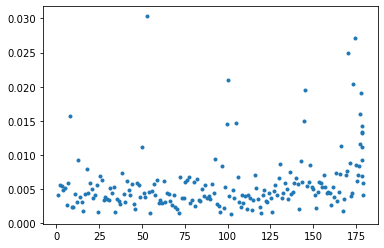

(48000510, 'e+')


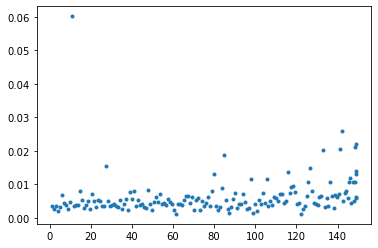

(48000510, 'e-')


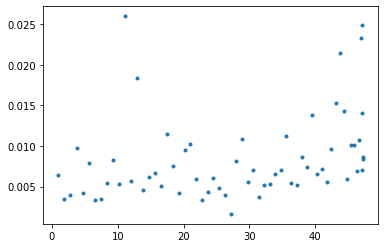

(48000511, 'e-')


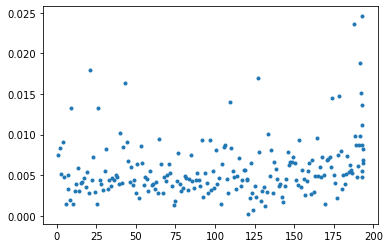

(48000512, 'e-')


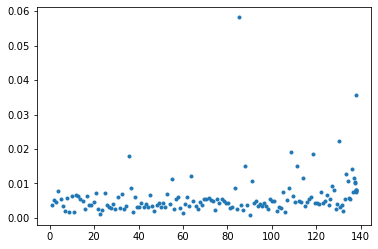

(48000513, 'e-')


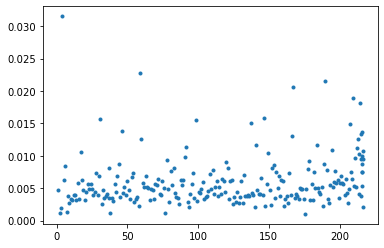

(48000514, 'e-')


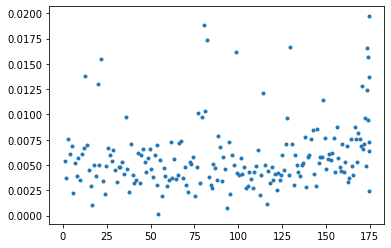

(48000515, 'e-')


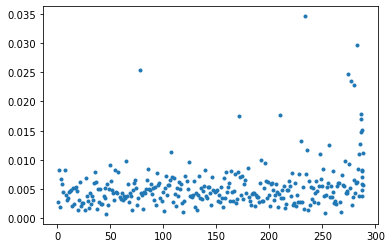

(48000516, 'e-')


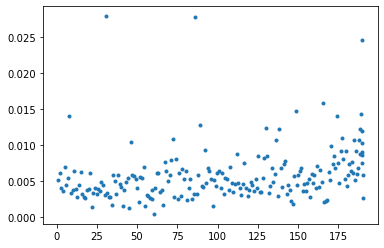

(48000517, 'e-')


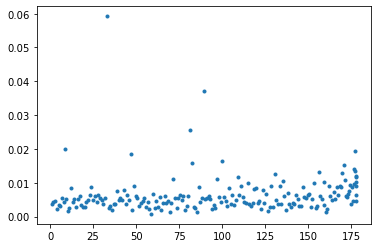

(48000518, 'e-')


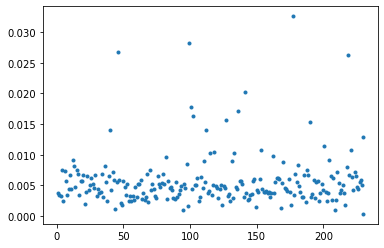

(48000519, 'e-')


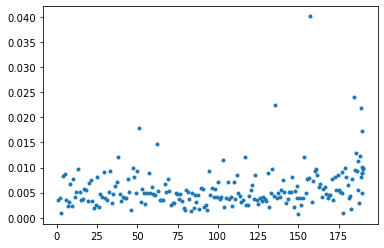

(48000520, 'e-')


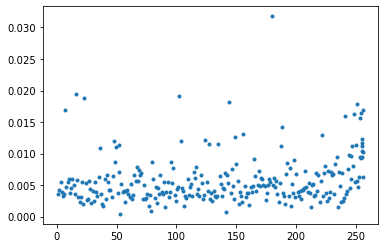

(48000521, 'e-')


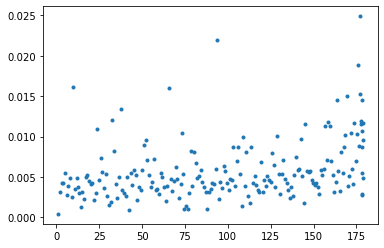

(48000522, 'e-')


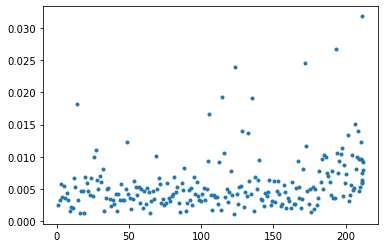

(48000523, 'e-')


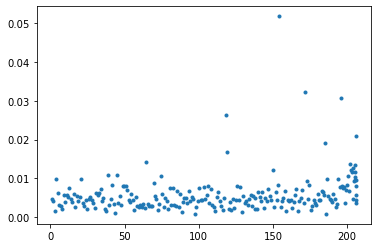

(48000524, 'e+')


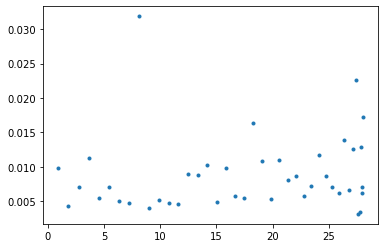

(48000524, 'e-')


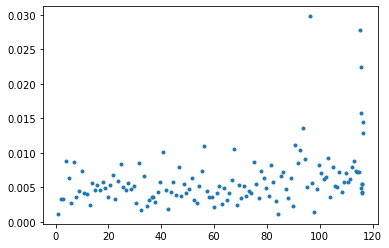

(48000525, 'e+')


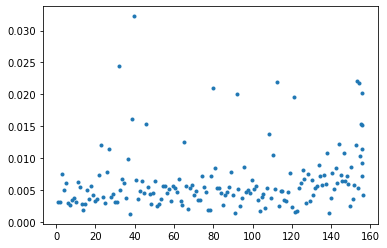

(48000525, 'e-')


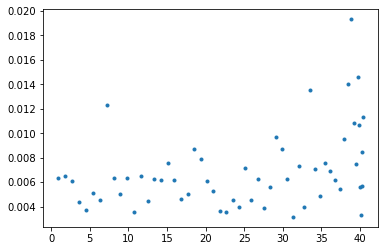

(48000526, 'e+')


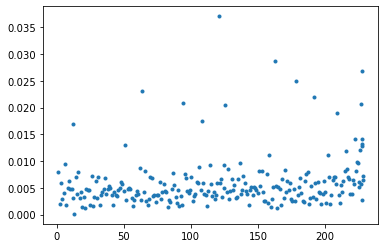

(48000526, 'e-')


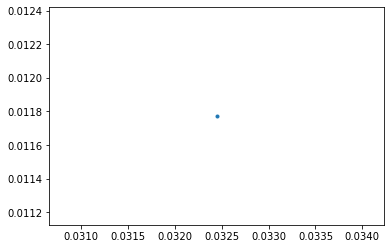

(48000527, 'e-')


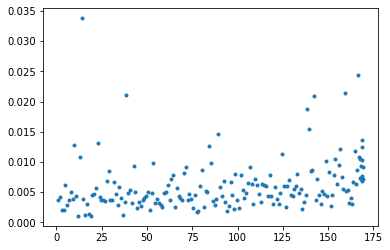

(48000528, 'e+')


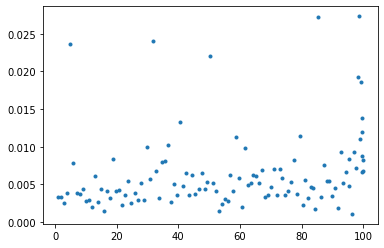

(48000528, 'e-')


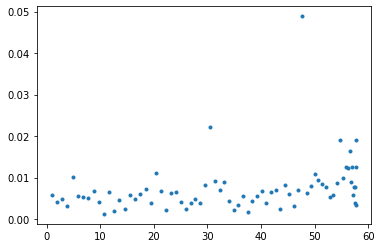

(48000529, 'e-')


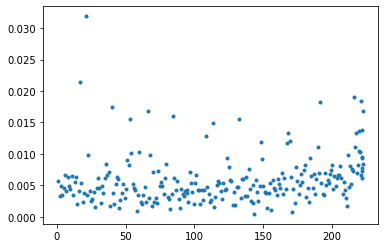

(48000530, 'e-')


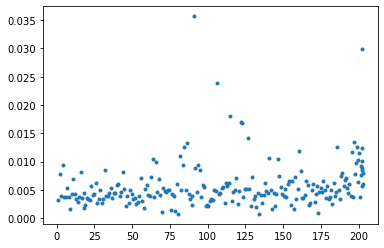

(48000531, 'e-')


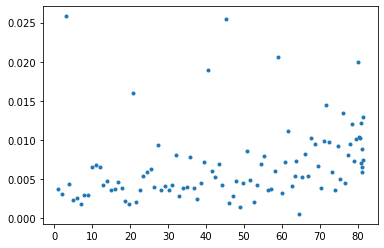

(48000532, 'e-')


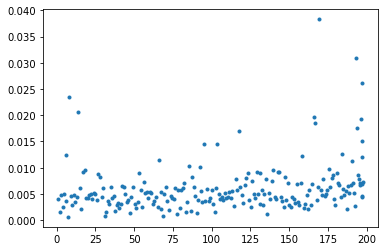

(48000533, 'e-')


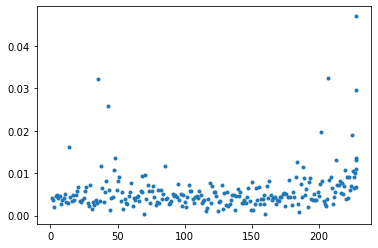

(48000535, 'e-')


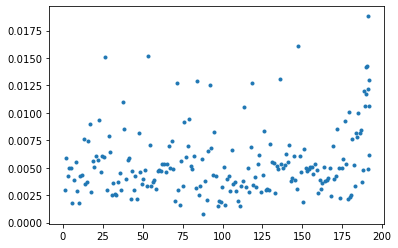

(48000536, 'e-')


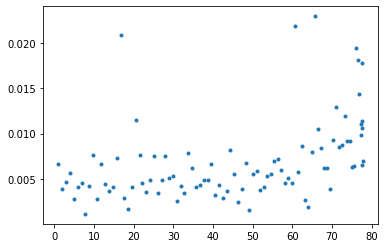

(48000537, 'e-')


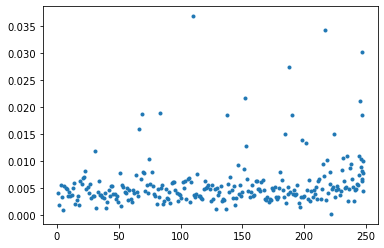

(48000538, 'e+')


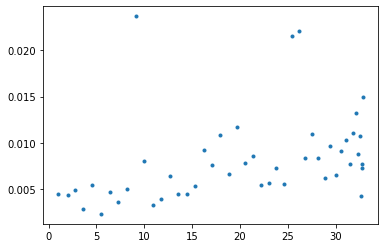

(48000538, 'e-')


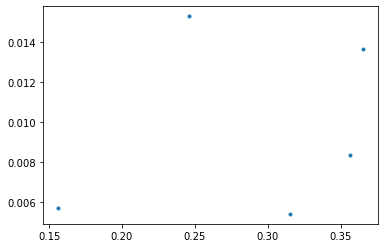

(48000539, 'e-')


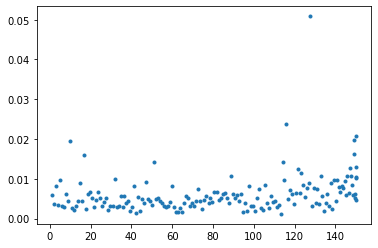

(48000540, 'e-')


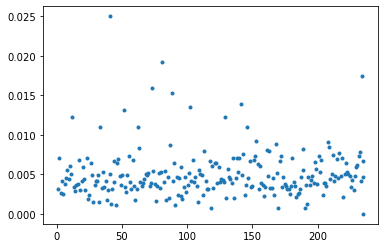

(48000541, 'e-')


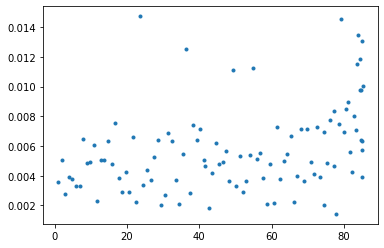

(48000542, 'e-')


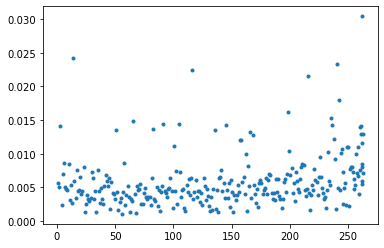

(48000543, 'e-')


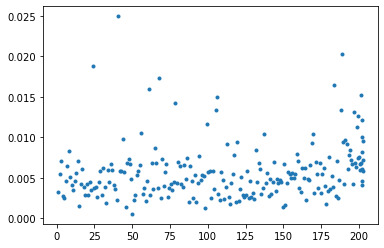

(48000544, 'e+')


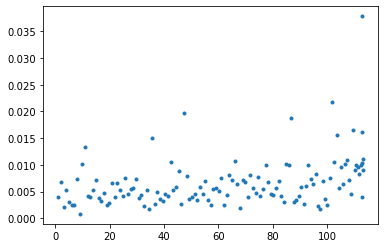

(48000544, 'e-')


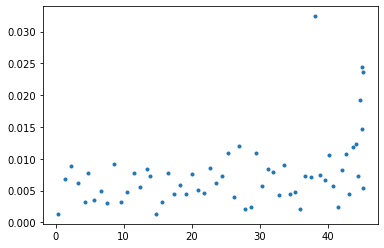

(48000545, 'e+')


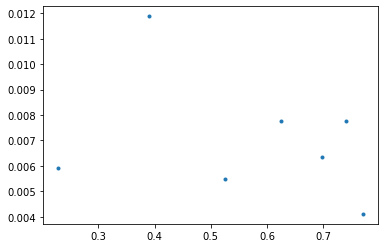

(48000545, 'e-')


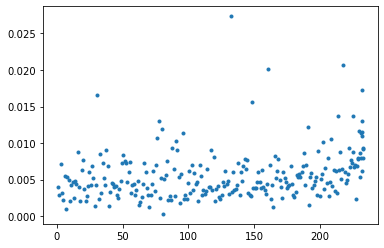

(48000546, 'e-')


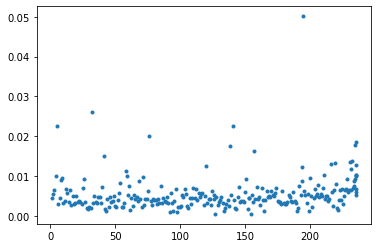

(48000547, 'e-')


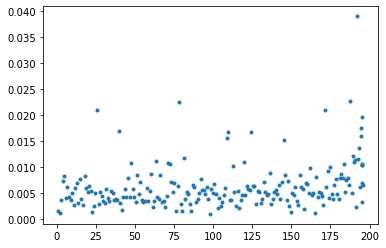

(48000548, 'e+')


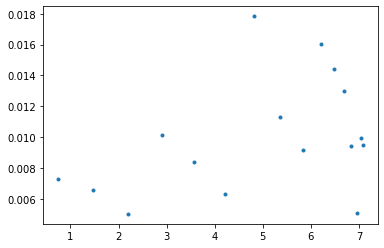

(48000548, 'e-')


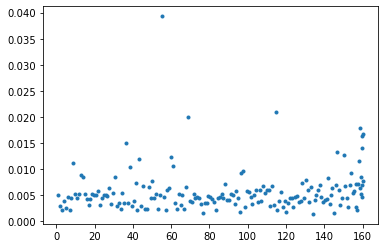

(48000549, 'e+')


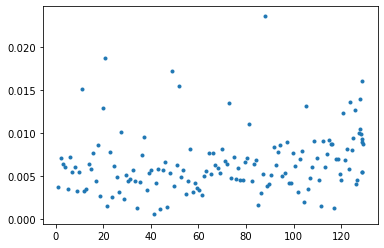

(48000549, 'e-')


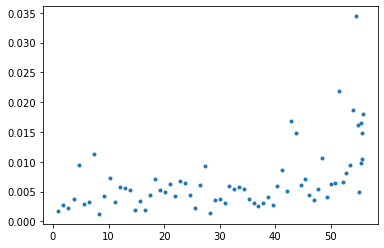

(48000550, 'e-')


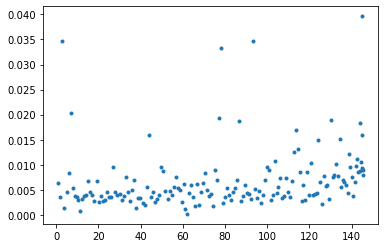

(48000551, 'e+')


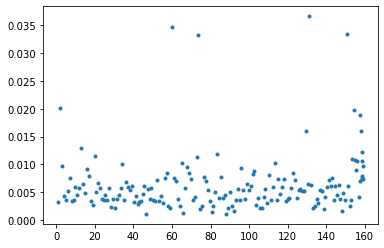

(48000551, 'e-')


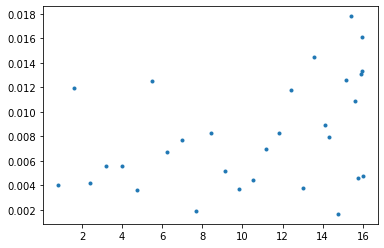

(48000552, 'e+')


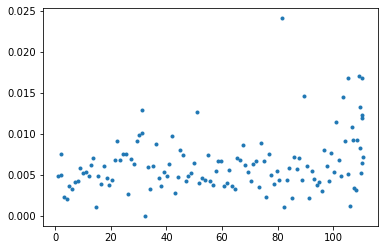

(48000552, 'e-')


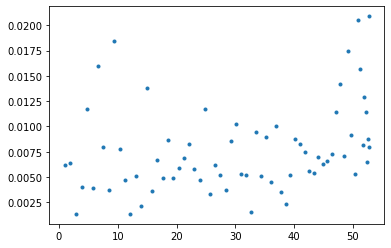

(48000553, 'e+')


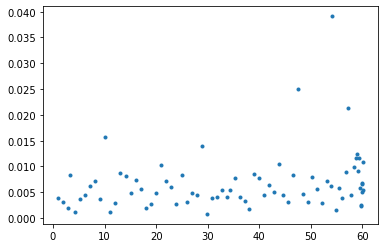

(48000553, 'e-')


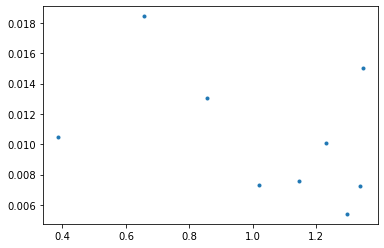

(48000554, 'e-')


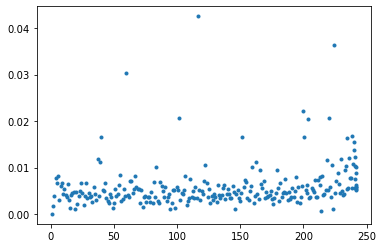

(48000555, 'e+')


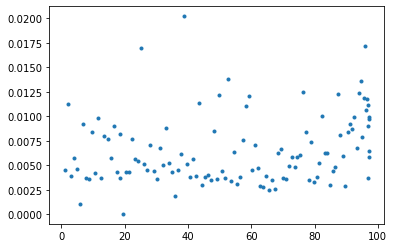

(48000555, 'e-')


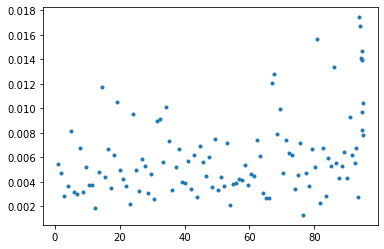

(48000556, 'e-')


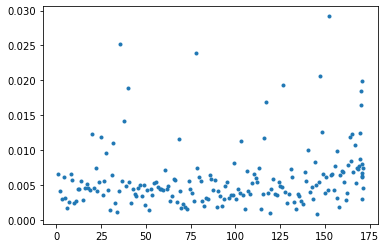

(48000557, 'e-')


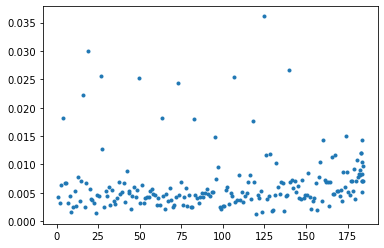

(48000558, 'e-')


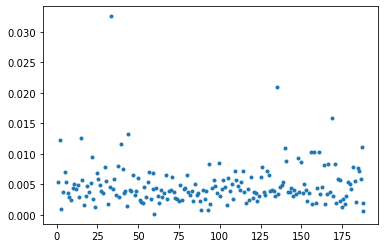

(48000559, 'e+')


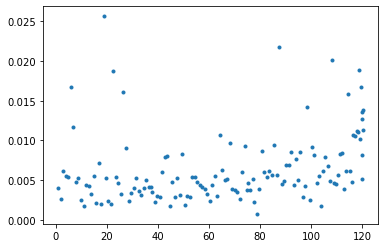

(48000559, 'e-')


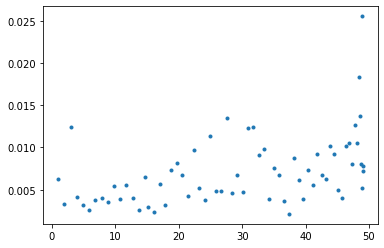

(48000560, 'e-')


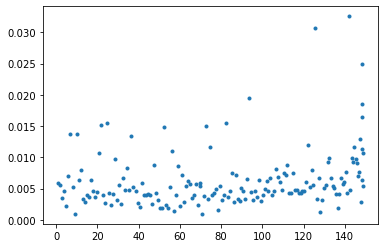

(48000561, 'e+')


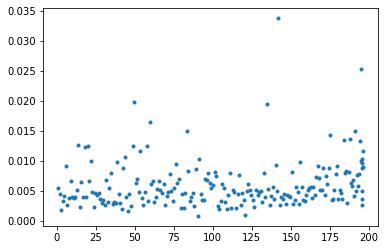

(48000561, 'e-')


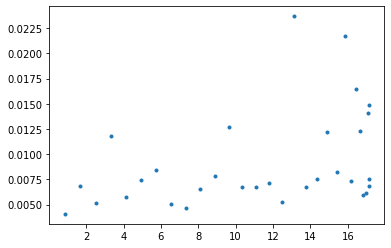

(48000562, 'e-')


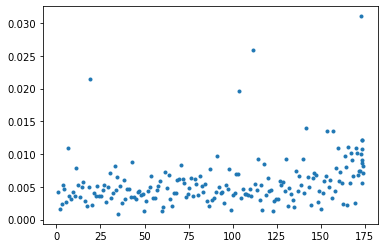

(48000563, 'e+')


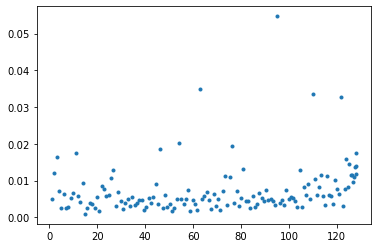

(48000563, 'e-')


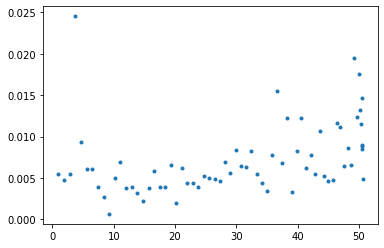

(48000564, 'e+')


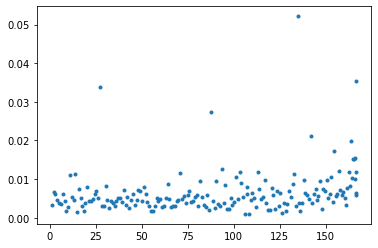

(48000564, 'e-')


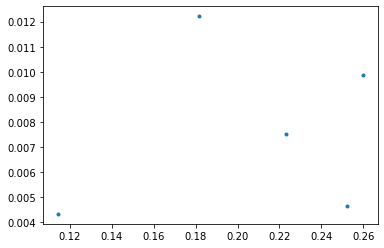

(48000565, 'e-')


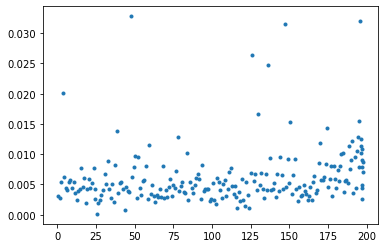

(48000566, 'e+')


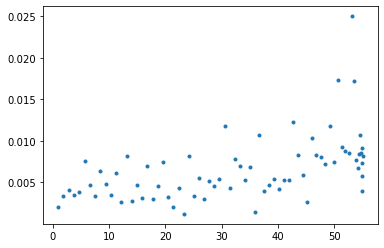

(48000566, 'e-')


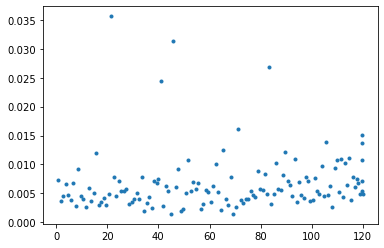

(48000568, 'e-')


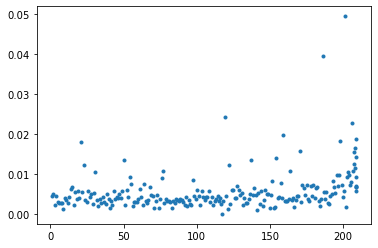

(48000569, 'e-')


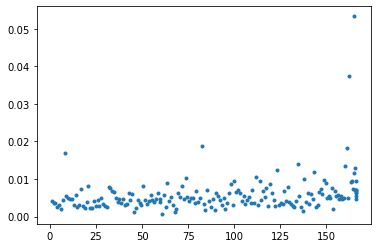

(48000570, 'e-')


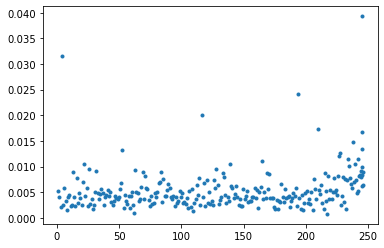

(48000571, 'e-')


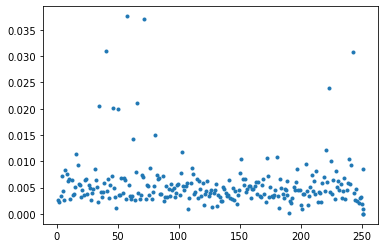

(48000572, 'e-')


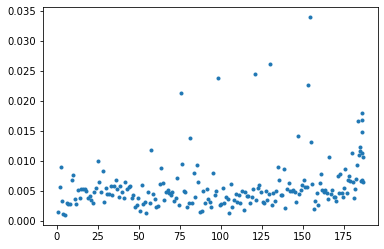

(48000573, 'e+')


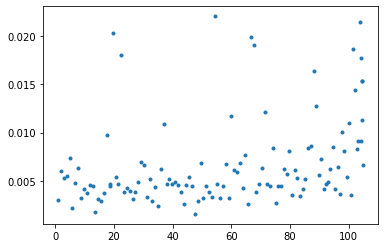

(48000573, 'e-')


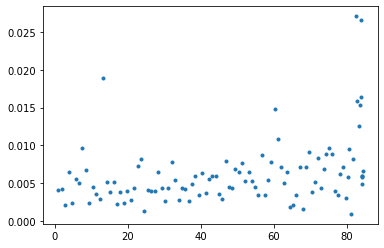

(48000574, 'e+')


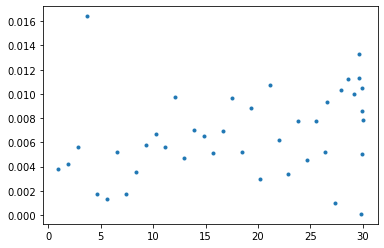

(48000574, 'e-')


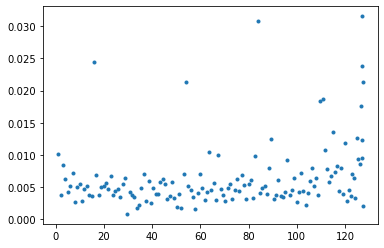

(48000575, 'e-')


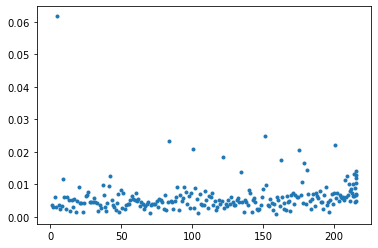

(48000576, 'e-')


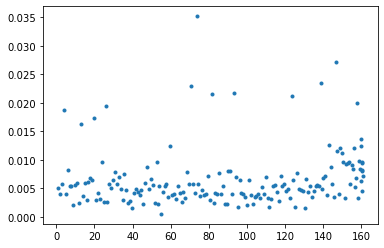

(48000577, 'e-')


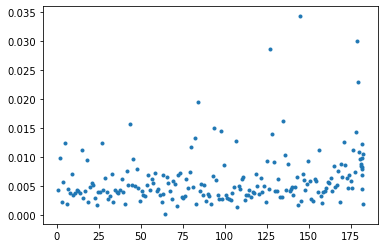

(48000578, 'e+')


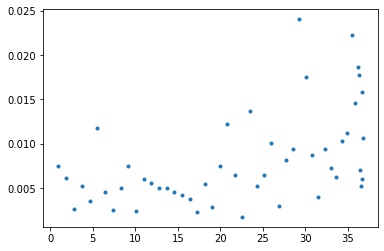

(48000578, 'e-')


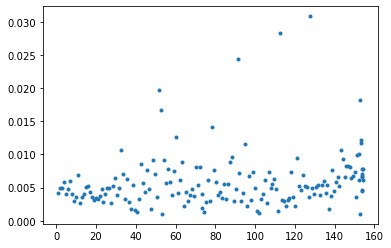

(48000579, 'e-')


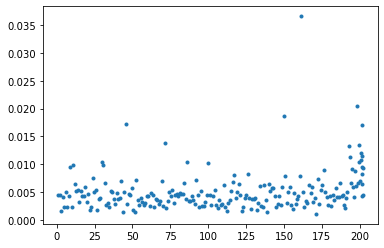

(48000580, 'e-')


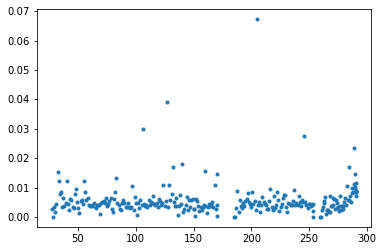

(48000581, 'e-')


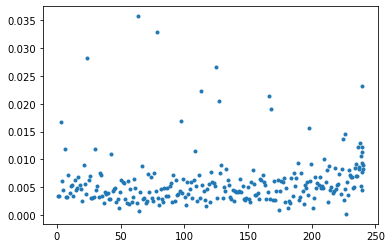

(48000582, 'e-')


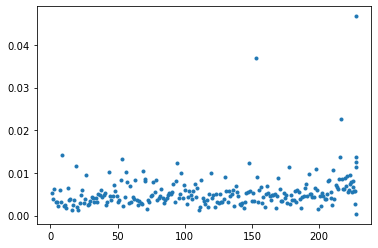

(48000583, 'e+')


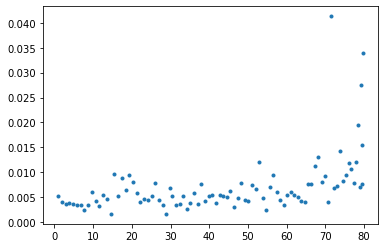

(48000583, 'e-')


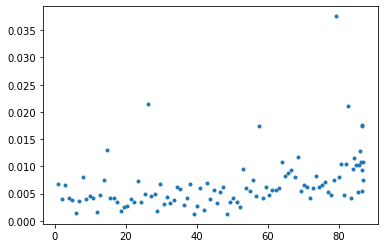

(48000584, 'e-')


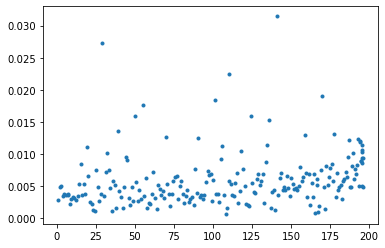

(48000585, 'e-')


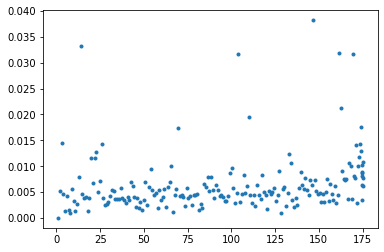

(48000586, 'e-')


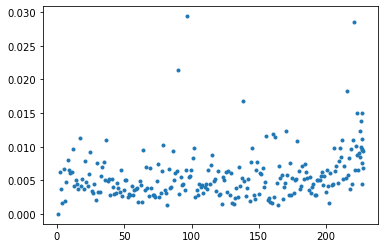

(48000587, 'e+')


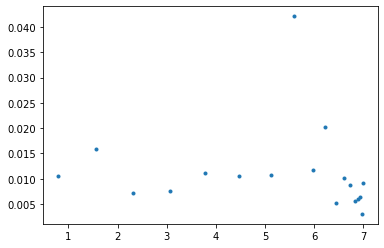

(48000587, 'e-')


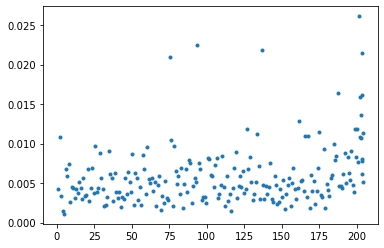

(48000588, 'e-')


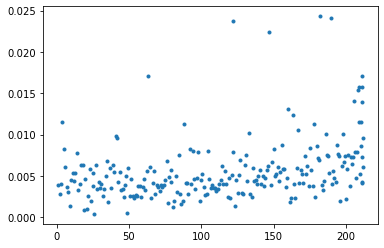

(48000590, 'e-')


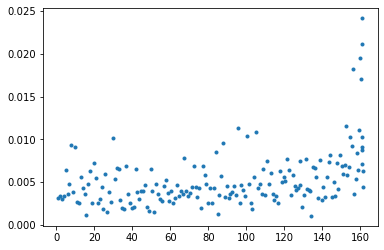

(48000591, 'e-')


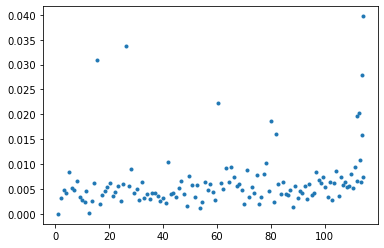

(48000592, 'e+')


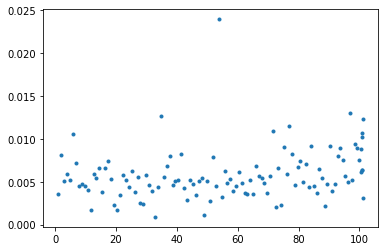

(48000592, 'e-')


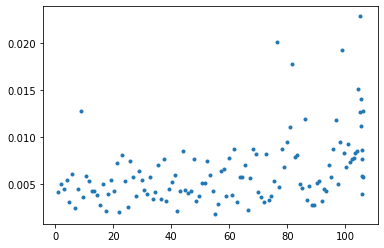

(48000593, 'e-')


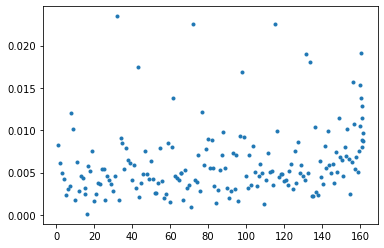

(48000595, 'e+')


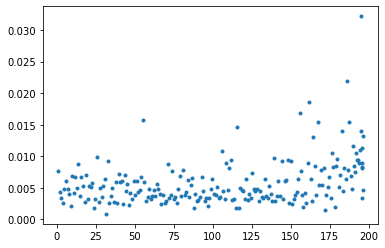

(48000595, 'e-')


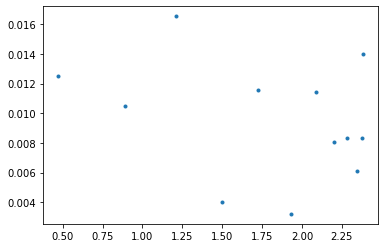

(48000596, 'e-')


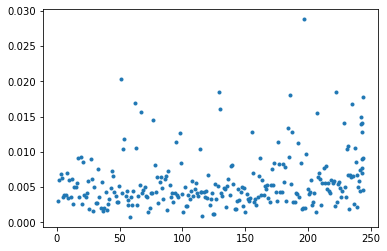

(48000597, 'e-')


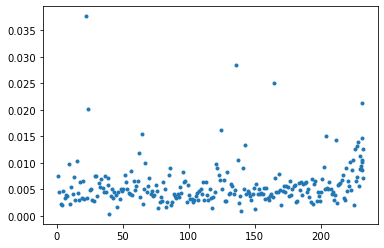

In [198]:
import matplotlib.pyplot as plt

for event_id, df in track_hits.groupby(['event_id', 'particle_name']):
    print(event_id)
    plt.plot(df.cumdist[:-1], df.energy[:-1], '.')
    plt.show()

In [200]:
def plot_3d_hits(hits, value='energy', coords = ['x', 'y', 'z'], cmap = mpl.cm.jet):
    fig  = plt.figure(figsize=(15, 15), frameon=False)
    gs   = fig.add_gridspec(2, 40)
    ax   = fig.add_subplot(gs[0, 0:16], projection = '3d')
    axcb = fig.add_subplot(gs[0, 18])
    norm = mpl.colors.Normalize(vmin=hits.loc[:, value].min(), vmax=hits.loc[:, value].max())

    m    = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

    colors = np.asarray(np.vectorize(m.to_rgba)(hits.loc[:, value]))
    colors = np.rollaxis(colors, 0, 2)

    ax.scatter(hits[coords[0]], hits[coords[1]], hits[coords[2]], c=colors, marker='o')
    cb = mpl.colorbar.ColorbarBase(axcb, cmap=cmap, norm=norm, orientation='vertical')


    ax.set_xlabel('X ')
    ax.set_ylabel('Y ')
    ax.set_zlabel('Z ')
    cb.set_label (value)

    plt.show()

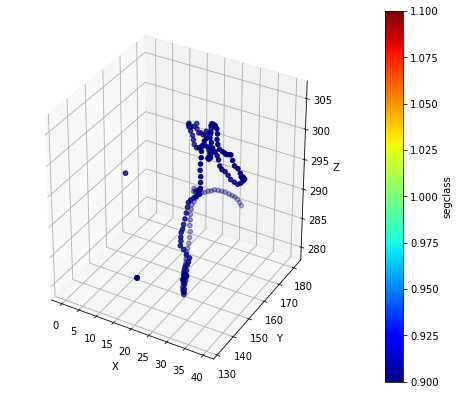

In [204]:
plot_3d_hits(label_hits.loc[(label_hits.event_id == 48000024)], value = 'segclass')

# Proceso

Lo que se hace entonces es:

- Para un fichero, obtenemos los datos de hits de MC y sus partículas.
- Con un cierto energy threshold y la función add_hits_labels_MC obtenemos ya todos los hits con clase de segmentación (más las distancias de hits de cada traza)
- Luego iterando en el df de hits labelleados, groupby('event_id') recorremos las coords, eners y etiquetas (segclass) de cada evento.
- Con voxel_labelling_MC hacemos el voxelizado y asignamos una etiqueta a cada voxel basándonos en el tipo de partícula que deposita más energía. De aquí salen histogramas.
- Finalmente, tomamos los histogramas y los pasamos a coordenadas con histog_to_coord


## QUIZÁS ES PROCESO DE VOXELIZADO Y LABELLING DE VOXELES PODAMOS HACERLO DE FORMA MÁS AUTOMÁTICA, Y NO SOLO CON UN HIT DIGO YO...

Por ahora el procesado para un fichero me lo hace la función labelling: toma un fichero, hace ya el labelling de los hits, y luego coge evento a evento y voxeliza y labellea voxeles, extrae las coordenadas y devuelve un df con dichas coordenadas de voxeles de todos los eventos del fichero.

In [189]:
mccoors, mcenes, labels, binclass = get_mchits_info(nevent, label_hits, identifyer = 'segclass', binclass = True)

In [190]:
label_histo, ener_histo, ratio_histo = voxel_labelling_MC(detector_frame, mccoors, mcenes, labels, detector_bins)

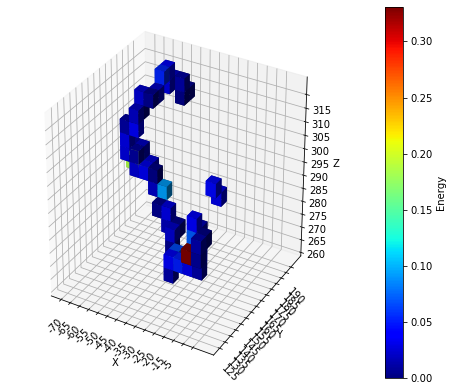

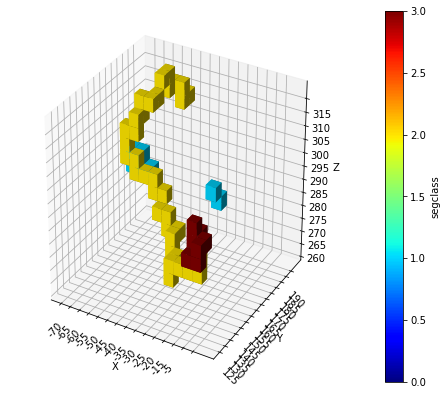

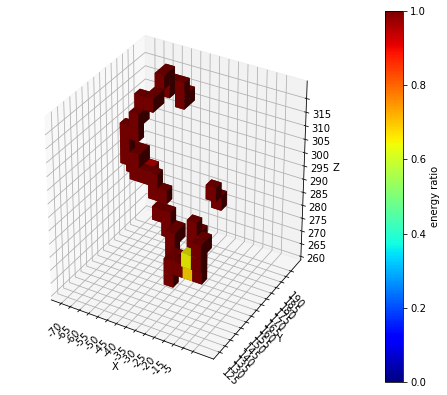

In [191]:
plot_3d_histo_vox(ener_histo,  detector_bins)
plot_3d_histo_vox(label_histo, detector_bins, clabel = 'segclass')
plot_3d_histo_vox(ratio_histo, detector_bins, clabel = 'energy ratio')

In [64]:
histog_to_coord(nevent, label_histo, ener_histo, ratio_histo, detector_bins, binnum = binclass)

event_id     x      y      z      ener     ratio  segclass  binclass
0   48000057 -70.0  160.0  290.0  0.027571  1.000000       2.0         0
1   48000057 -70.0  160.0  295.0  0.030416  1.000000       2.0         0
2   48000057 -70.0  160.0  300.0  0.011133  1.000000       2.0         0
3   48000057 -70.0  165.0  285.0  0.184994  1.000000       1.0         0
4   48000057 -70.0  165.0  290.0  0.010019  1.000000       1.0         0
5   48000057 -65.0  160.0  285.0  0.025464  1.000000       2.0         0
6   48000057 -65.0  160.0  290.0  0.010113  1.000000       2.0         0
7   48000057 -65.0  160.0  300.0  0.035806  1.000000       2.0         0
8   48000057 -65.0  160.0  305.0  0.020910  1.000000       2.0         0
9   48000057 -65.0  165.0  285.0  0.067770  0.962050       1.0         0
10  48000057 -65.0  165.0  290.0  0.021148  1.000000       1.0         0
11  48000057 -65.0  165.0  305.0  0.003413  1.000000       2.0         0
12  48000057 -65.0  165.0  310.0  0.024944  1.000000       2.0         0
13  48000057 -60.0  160.0  285.0  0.032387  1.000000       2.0         0
14  48000057 -60.0  165.0  285.0  0.027010  0.945119       1.0         0
15  48000057 -60.0  165.0  310.0  0.005974  1.000000       2.0         0
16  48000057 -60.0  170.0  310.0  0.022359  1.000000       2.0         0
17  48000057 -60.0  175.0  315.0  0.053461  1.000000       2.0         0
18  48000057 -60.0  180.0  310.0  0.028045  1.000000       2.0         0
19  48000057 -60.0  180.0  315.0  0.038858  1.000000       2.0         0
20  48000057 -60.0  185.0  310.0  0.020788  1.000000       2.0         0
21  48000057 -55.0  160.0  280.0  0.021776  1.000000       2.0         0
22  48000057 -55.0  160.0  285.0  0.003659  1.000000       2.0         0
23  48000057 -55.0  185.0  305.0  0.003760  1.000000       2.0         0
24  48000057 -55.0  185.0  310.0  0.011670  1.000000       2.0         0
25  48000057 -55.0  190.0  305.0  0.007710  1.000000       2.0         0
26  48000057 -50.0  155.0  275.0  0.006051  1.000000       2.0         0
27  48000057 -50.0  160.0  280.0  0.093429  1.000000       2.0         0
28  48000057 -45.0  155.0  270.0  0.017042  1.000000       2.0         0
29  48000057 -45.0  155.0  275.0  0.030170  1.000000       2.0         0
30  48000057 -40.0  150.0  265.0  0.005567  1.000000       2.0         0
31  48000057 -40.0  150.0  270.0  0.023592  1.000000       2.0         0
32  48000057 -40.0  155.0  270.0  0.006084  1.000000       2.0         0
33  48000057 -35.0  140.0  260.0  0.013073  1.000000       2.0         0
34  48000057 -35.0  140.0  265.0  0.035362  1.000000       2.0         0
35  48000057 -35.0  145.0  265.0  0.066164  1.000000       2.0         0
36  48000057 -30.0  140.0  265.0  0.050690  1.000000       2.0         0
37  48000057 -25.0  140.0  265.0  0.031607  0.685202       2.0         0
38  48000057 -20.0  130.0  275.0  0.330583  0.647335       3.0         0
39  48000057 -20.0  135.0  280.0  0.072127  1.000000       3.0         0
40  48000057 -20.0  135.0  285.0  0.037955  1.000000       3.0         0
41  48000057 -20.0  140.0  265.0  0.012806  1.000000       2.0         0
42  48000057 -20.0  140.0  270.0  0.032158  1.000000       2.0         0
43  48000057 -20.0  140.0  275.0  0.038555  0.740449       3.0         0
44  48000057 -20.0  140.0  280.0  0.017325  1.000000       3.0         0
45  48000057 -15.0  130.0  275.0  0.008516  1.000000       3.0         0
46  48000057 -15.0  130.0  280.0  0.013511  1.000000       3.0         0
47  48000057 -15.0  135.0  280.0  0.003232  1.000000       3.0         0
48  48000057  -5.0  125.0  305.0  0.042627  1.000000       1.0         0
49  48000057  -5.0  130.0  300.0  0.029781  1.000000       1.0         0

# Hacemos una función que haga el voxel labelling y extraiga las coord (con histog_to_coord) para TODOS los eventos de un fichero

Parto de tener todos los eventos

In [269]:
mcpart = dio.load_dst(dir_beersh, 'MC', 'particles') 
mchits = dio.load_dst(dir_beersh, 'MC', 'hits') 

Hago el label binary y segmentation

In [270]:
label_hits = add_hits_labels(mchits, mcpart)

## FIJO Q HAY UNA FORMA RAPIDA DE HACER ESTO, COMO HICE ANTES...

In [134]:
def labelling_MC(directory, total_size, voxel_size, start_bin, identifyer = 'segclass', blob_energy_th = 0.4):
    '''
    Performs hit labelling (binclass and segclass), voxelization of the hits (gives us the energy 
    per voxel, adding up all the hits that fall inside a voxel) and voxel segclass labelling. 

    Args:
        directory: STR
    Contains the directory of a file with several events with Monte Carlo information.
    
        total_size: TUPLE 
    Contains the max size of the detector.
    
        voxel_size: TUPLE
    Contains the voxel size of the detector for each coordinate.
    
        start_bin: TUPLE
    Contains the first voxel position for each coordinate.
        
        identifyer: STR
    Desired feature to perform the voxel labelling. It will be segclass, but also particle_id for some reason.
    
        binclass: BOOL
    Used to decide whether we want the binclass information in the output or we dont.
    
        blob_energy_th: FLOAT
    Energy threshold for the last hits of a track to become blob class.
    
    RETURNS:
        voxelization_df: DATAFRAME
    It contains the positions, energies and labels for each voxel of each event in a single file.
    
    '''
    #Creo el frame del detector y obtengo sus bins
    img  = container_creator(total_size, voxel_size)
    bins = bin_creator(img, steps = voxel_size, x0 = start_bin)

    #Obtenemos la información de partíuclas y hits de un fichero en concreto
    mcpart = dio.load_dst(directory, 'MC', 'particles') 
    mchits = dio.load_dst(directory, 'MC', 'hits') 
    
    #Etiquetamos los hits 
    labelled_hits = add_hits_labels_MC(mchits, mcpart, blob_energy_th = blob_energy_th)
    
    #Creamos el df donde vamos a añadir la información de los voxeles etiquetados
    voxelization_df = pd.DataFrame()
    
    #Recorremos evento a evento el DF con los hits etiquetados para hacerle a cada uno su histograma y
    #finalmente extraer las coordenadas
    for event_id, event_hits in labelled_hits.groupby('event_id'):
        xhits, yhits, zhits = event_hits['x'], event_hits['y'], event_hits['z']
    
        mccoors  = np.array([xhits, yhits, zhits]).T 
        mcenes   = np.array(event_hits['energy'])
        labels   = np.array(event_hits['segclass'])
        binclass = np.array(event_hits['binclass'])[0]
        
        label_histo, ener_histo, ratio_histo = voxel_labelling_MC(img, mccoors, mcenes, labels, bins)
        
        voxelization_df = voxelization_df.append(histog_to_coord(event_id, label_histo, ener_histo, ratio_histo, bins, binnum = binclass))
    
    voxelization_df.reset_index()
    
    return voxelization_df

In [130]:
def labelling_test():
    return

In [133]:
start = time.time()
voxelization_df  = labelling_MC(dir_beersh, total_size, voxel_size, start_bin)
print(time.time()-start, 'sec for', len(mchits.event_id.unique()), 'events')

37.882957220077515 sec for 571 events


In [124]:
voxelization_df

event_id     x      y      z      ener  ratio  segclass  binclass
0   48000024  -5.0  165.0  285.0  0.029452    1.0       1.0         0
1   48000024  15.0  160.0  275.0  0.004629    1.0       1.0         0
2   48000024  15.0  160.0  280.0  0.022082    1.0       1.0         0
3   48000024  15.0  165.0  280.0  0.015947    1.0       1.0         0
4   48000024  15.0  165.0  285.0  0.026925    1.0       1.0         0
..       ...   ...    ...    ...       ...    ...       ...       ...
57  48000597  40.0  -30.0  300.0  0.004106    1.0       2.0         0
58  48000597  40.0  -25.0  300.0  0.028640    1.0       2.0         0
59  48000597  40.0  -20.0  295.0  0.011978    1.0       2.0         0
60  48000597  40.0  -20.0  300.0  0.008966    1.0       2.0         0
61  48000597  40.0  -15.0  295.0  0.000070    1.0       1.0         0

[29375 rows x 8 columns]

## Ejemplo de como hago el merge de hits y particulas... simplemente a todos los hits de cierta partícula le añade la información que se trae de ella (nombre, energía total... etc)

In [ ]:
A = pd.DataFrame({'event_id': [1, 1, 1, 2, 2, 3, 3, 3, 3, 4],
                  'particle_id': [8, 12, 12, 4, 4, 12, 13, 13, 14, 17],
                  'hit_id': [0, 0, 1, 0, 1, 0, 0, 1, 0, 0],
                  'energy': [100, 200, 200, 110, 120, 12, 130, 400, 20, 350]})
A

In [ ]:
B = pd.DataFrame({'event_id': [1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4],
                  'particle_id': [8, 9, 10, 11, 12, 2, 3, 4, 5, 12, 13, 14, 16, 17, 18],
                  'particle_name': ['a', 'b', 'c', 'd', 'e', 'i', 'j', 'k', 'l', 'x', 'y', 'z', 'o', 'p', 'q']})
B

In [ ]:
pd.merge(A, B, on = ['event_id', 'particle_id'])

In [ ]:
pb208_id = int(mcpart_event.loc[mcpart_event.particle_name == 'Pb208[2614.522]'].particle_id)

In [ ]:
pb208_id

In [ ]:
pb208_sons = mcpart_event.loc[mcpart_event.mother_id == int(pb208_id)]
pb208_sons

In [ ]:
gamma_id = pb208_sons.loc[pb208_sons.particle_name == 'gamma'].particle_id

In [ ]:
gamma_sons = mcpart_event.loc[mcpart_event.mother_id == int(gamma_id)]
gamma_sons_ids = np.array(gamma_sons.particle_id)
gamma_sons

In [ ]:
np.isin('e+', gamma_sons.particle_name)

Aqui hacer division: 
- si gamma_sons tiene un e+, debemos coger y etiquetar el evento como double_scape (añadir en summary una columna por ejemplo), así como coger los id del e- y e+ resultantes para luego hacer cosites con los hits (hacer label de track/non-track)

- si gamma_sons no tiene e+, etiquetamos el evento como bkg, miramos cual de los sons tiene más hits y más energía y cogemos su id (como antes, para hacer cosites con los hits)

In [ ]:
gamma_sons_ids

In [ ]:
#gamma_sons.assign(cosa = 1) #añadir columnas :)

In [ ]:
#plot_3d_hits_double(mchits_event, None, double = False, value = 'particle_id')

En los eventos double_scape es facil la cosa creo. El gamma siempre va a dar dos hijos, un e- y un e+, por tanto automáticamente tenemos las dos trazas.

Para los bkg, el gamma dará varios e- y supongo que el principal será el que tiene + hits, ie más energía...

Directamente parece q los e- que no so el principal ni tienen hits, solo se producen y punto, pero tpoco me fio demasiado asi q no se...

In [ ]:
for i in gamma_sons_ids:
    print(i, len(mchits_event.loc[mchits_event.particle_id == i]), float(gamma_sons.loc[gamma_sons.particle_id == i].kin_energy)) 

In [ ]:
gamma_sons_ids[np.isin(gamma_sons_ids, mchits_event.particle_id)]

In [ ]:
def event_classification(directory):
    event_summary = dio.load_dst(directory, 'Summary', 'Events')
    mcpart = dio.load_dst(dir_beersh, 'MC', 'particles') 
    mchits = dio.load_dst(dir_beersh, 'MC', 'hits') 
    
    #aqui usaria la funcion add_binclass para añadir a mchits y event_summary la binclass i guess
    
    event_numbers = event_summary.event.unique()
    for nevent in event_numbers:
        mcpart_event = mcpart.loc[mcpart.event_id == nevent]
        mchits_event = mchits.loc[mchits.event_id == nevent]
        
        pb208_id = int(mcpart_event.loc[mcpart_event.particle_name == 'Pb208[2614.522]'].particle_id)
        pb208_sons = mcpart_event.loc[mcpart_event.mother_id == pb208_id]

        gamma_id = pb208_sons.loc[pb208_sons.particle_name == 'gamma'].particle_id
        
        gamma_sons = mcpart_event.loc[mcpart_event.mother_id == int(gamma_id)]
        gamma_sons_ids = np.array(gamma_sons.particle_id)
        
        if np.isin('e+', gamma_sons.particle_name):
            